In [1]:
!pip install numpy torch sympy mod blobfile pandas seaborn matplotlib tqdm einops wandb

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from contextlib import suppress
from dataclasses import dataclass, asdict
from datetime import datetime
from typing import Callable, Literal, Optional, Union, Tuple, List
from copy import deepcopy

import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim
import wandb
from tqdm.notebook import tqdm
import ipywidgets as widgets
import wandb

import matplotlib as mpl
from matplotlib.colors import LogNorm
import seaborn as sns
import matplotlib.pyplot as plt

from patterns.dataset import ModularArithmetic, Operator
from patterns.transformer import Transformer
from patterns.utils import generate_run_name
from patterns.learner import Config

from toy_models.fit import rescale_run, Pattern, PatternLearningModel
from unifying.sweep import get_history, handle_outliers
from unifying.plotting import BLUE, RED

DEFAULT_MODULUS = 113
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sns.set_theme(style="darkgrid")


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
def plot_patterns(pl_model, run, log=False):
    ts = run["_step"].values
    train_preds = [pl_model(t).detach().numpy() for t in ts]
    test_preds = [pl_model.test(t).detach().numpy() for t in ts]
    train_ys = torch.tensor(run["train/acc"].values).float()
    test_ys = torch.tensor(run["test/acc"].values).float()
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].plot(ts, train_preds, label="train", color="blue")
    axes[0].plot(ts, test_preds, label="test", color="red")

    axes[1].plot(ts, train_ys, label="train", color="blue")
    axes[1].plot(ts, test_ys, label="test", color="red")

    axes[0].set_title("Predictions")
    axes[1].set_title("True values")

    if log:
        axes[0].set_xscale("log")
        axes[1].set_xscale("log")

In [120]:


def get_history(
    *sweep_ids,
    unique_cols: Union[List[str], str] = "weight_decay",
    entity: str = "jqhoogland",
    project: str = "grokking",
    allow_duplicates=False,
    combine_seeds=False,
    metrics=METRICS
):
    """
    Gathers all the runs from a series of sweeps and combines them into a single dataframe.

    `unique_col` is used to identify duplicate runs. By default, `"_step"` is added.
    If there are duplicates, the run from the last sweep is kept.
    """
    api = wandb.Api()
    unique_cols = unique_cols if isinstance(unique_cols, list) else [unique_cols]

    def _get_history(sweep_id):
        """Get a dataframe for a single sweep."""
        sweep = api.sweep(f"{entity}/{project}/{sweep_id}")
        runs = sweep.runs

        def create_run_df(history, config):
            for k, v in config.items():
                if k == "momentum" and isinstance(v, list):
                    v = [tuple(v)] * len(history)
                history[k] = v

            return history

        return pd.concat([create_run_df(run.history(), run.config) for run in runs])

    histories = pd.concat([_get_history(sweep_id) for sweep_id in sweep_ids])

    if not allow_duplicates:
        histories = histories.drop_duplicates(["_step", *unique_cols], keep="last")

    # Change step 0 to 1 to avoid issues with log plots
    histories.loc[histories._step == 0, "_step"] = 1

    # Fix types
    histories.applymap(lambda x: x.item() if isinstance(x, np.generic) else x)
    non_numeric_columns = histories.select_dtypes(
        exclude=["int", "float", "int64", "float64"]
    ).columns
    histories = histories.drop(columns=non_numeric_columns)

    # Sort
    histories = histories.sort_values(by=[*unique_cols, "_step"])

    if combine_seeds:
        assert (
            len(unique_cols) == 1
        ), "Can only combine seeds if there is a single unique column"

        unique_col = unique_cols[0]
        unique_vals = histories[unique_col].unique()

        for val in unique_vals:
            runs = histories[histories[unique_col] == val]
            seeds = runs.seed.unique()

            if len(seeds) > 1:
                # Define the metrics that need to be averaged
                for metric in metrics:
                    # Calculate the mean value for each metric and _step
                    means_groups = runs.groupby("_step")[metric]

                    means = means_groups.apply(
                        lambda x: x.ffill().bfill().mean() if x.isna().any() else x
                    )

                    # Update the histories dataframe
                    for _step, mean_value in means.items():
                        mask = (histories[unique_col] == val) & (
                            histories._step == _step
                        )
                        histories.loc[mask, metric] = mean_value

        # Remove duplicate rows
        histories = histories.drop_duplicates(subset=[*unique_cols, "_step"])

    return histories

In [121]:
from unifying.sweep import get_pivot, METRICS

INTERP_SWEEPS = ["kodd01ka", "wecya83q", "wqnakkjd"] #, "awxzpem1"]
interp_sweep = get_history(*INTERP_SWEEPS, project="mnist-grokking", allow_duplicates=True, combine_seeds=True)
# # interp_sweep.drop(["weight/cos_sim_with_init", "test/efficiency", "train/efficiency", "weight/dist_from_init"])

In [115]:
interp_sweep_og = interp_sweep.copy()
interp_sweep.loc[:, METRICS]

train/acc  test/acc    train/loss     test/loss  corrupted/acc   
0     0.123752  0.143713  10332.297331  10201.696856            NaN  \
0     0.123752  0.143713  10332.297331  10201.696856            NaN   
1     0.123752  0.155689  10246.328189  10116.588323            NaN   
0     0.123752  0.143713  10332.297331  10201.696856            NaN   
1     0.057884  0.071856  10570.136699  10396.254491            NaN   
..         ...       ...           ...           ...            ...   
195   1.000000  0.149701      0.000356     29.355416            NaN   
62    1.000000  0.245509      0.000702      4.111345            NaN   
469   1.000000  0.143713      0.001663     22.351434            NaN   
195   1.000000  0.455090      0.000030      0.830855            NaN   
306   0.997006  0.377246      0.011039      0.929823            1.0   

     uncorrupted/acc  
0                NaN  
0                NaN  
1                NaN  
0                NaN  
1                NaN  
..               ...  
195              NaN  
62               NaN  
469              NaN  
195              NaN  
306         0.996583  

[24000 rows x 6 columns]

In [123]:
unique_cols = ["lr_factor"]
histories = interp_sweep
metrics = METRICS

assert (
    len(unique_cols) == 1
), "Can only combine seeds if there is a single unique column"

unique_col = unique_cols[0]
unique_vals = histories[unique_col].unique()

for val in unique_vals:
    runs = histories[histories[unique_col] == val]
    seeds = runs.seed.unique()

    if len(seeds) > 1:
        # Define the metrics that need to be averaged
        for metric in metrics:
            # Calculate the mean value for each metric and _step
            means_groups = runs.groupby("_step")[metric]

            means = means_groups.apply(
                lambda x: x.ffill().bfill().mean() if x.isna().any() else x.mean()
            )

            # Update the histories dataframe
            for _step, mean_value in means.items():
                mask = (histories[unique_col] == val) & (
                    histories._step == _step
                )
                histories.loc[mask, metric] = mean_value

# Remove duplicate rows
histories = histories.drop_duplicates(subset=[*unique_cols, "_step"])
histories

_step  test/acc  train/acc  weight/cos_sim_with_init    _timestamp   
1         1  0.125749   0.105788                  0.999982  1.684030e+09  \
1         1  0.155689   0.126747                  1.000000  1.684021e+09   
1         1  0.149701   0.123752                  1.000000  1.684003e+09   
0         1  0.143713   0.123752                       NaN  1.684132e+09   
1         1  0.065868   0.052894                       NaN  1.684119e+09   
..      ...       ...        ...                       ...           ...   
195  499998  0.377246   1.000000                       NaN  1.684106e+09   
172  499998  0.461078   0.994012                       NaN  1.684093e+09   
338  499998  0.407186   0.998004                       NaN  1.684088e+09   
74   499998  0.347305   0.996008                       NaN  1.684207e+09   
299  499998  0.455090   0.998337                       NaN  1.684159e+09   

     test/efficiency  weight/dist_from_init     test/loss    train/loss   
1          48.739998               0.442810   3585.467814   3752.327012  \
1         125.057498               0.046879   9199.832335   9330.661665   
1         138.202099               0.001376  10166.866766  10296.906462   
0                NaN                    NaN  10201.696856  10332.297331   
1                NaN                    NaN   4689.938249   4887.076776   
..               ...                    ...           ...           ...   
195              NaN                    NaN      0.998514      0.000401   
172              NaN                    NaN      0.994860      0.014984   
338              NaN                    NaN      0.940503      0.004458   
74               NaN                    NaN      0.947130      0.006998   
299              NaN                    NaN      0.830873      0.006082   

        _runtime  ...  num_classes  log_interval  weight_decay   
1       1.879519  ...           10            10          0.01  \
1       1.750930  ...           10            10          0.01   
1       1.867149  ...           10            10          0.01   
0       1.654984  ...           10            10          0.01   
1       1.712589  ...           10            10          0.01   
..           ...  ...          ...           ...           ...   
195  4305.895925  ...           10            10          0.01   
172  4424.421635  ...           10            10          0.01   
338  4314.263286  ...           10            10          0.01   
74   4703.369252  ...           10            10          0.01   
299  4744.252392  ...           10            10          0.01   

     frac_label_noise  num_training_steps  test_acc_criterion  corrupted/acc   
1                 0.1              500000                   1            NaN  \
1                 0.1              500000                   1            NaN   
1                 0.1              500000                   1            NaN   
0                 0.1              500000                   1            NaN   
1                 0.1              500000                   1            NaN   
..                ...                 ...                 ...            ...   
195               0.1              500000                   1            NaN   
172               0.1              500000                   1            NaN   
338               0.1              500000                   1            NaN   
74                0.1              500000                   1            1.0   
299               0.1              500000                   1            1.0   

     corrupted/loss  uncorrupted/loss  uncorrupted/acc  
1               NaN               NaN              NaN  
1               NaN               NaN              NaN  
1               NaN               NaN              NaN  
0               NaN               NaN              NaN  
1               NaN               NaN              NaN  
..              ...               ...              ...  
195             NaN               NaN  

In [140]:
interp_sweep = histories

# Drop _step == 0
interp_sweep = interp_sweep[interp_sweep._step != 0]

# Set "corrupted/acc" etc. = 0.1 at _step == 1
# for m in ["corrupted/acc", "uncorrupted/acc", "test/acc", "train/acc"]:
#   interp_sweep.loc[interp_sweep._step == 1, m] = 0.1

interp_sweep[interp_sweep["corrupted/acc"].notna()]

_step  test/acc  train/acc  weight/cos_sim_with_init    _timestamp   
1         1  0.080838   0.102295                       NaN  1.684221e+09  \
1         1  0.115768   0.104125                       NaN  1.684207e+09   
1         1  0.107784   0.094810                       NaN  1.684183e+09   
2         2  0.107784   0.116766                       NaN  1.684221e+09   
2         2  0.101796   0.117764                       NaN  1.684174e+09   
..      ...       ...        ...                       ...           ...   
168  499000  0.401198   0.991018                       NaN  1.684149e+09   
37   499000  0.335329   0.995010                       NaN  1.684178e+09   
51   499000  0.431138   0.998004                       NaN  1.684154e+09   
74   499998  0.347305   0.996008                       NaN  1.684207e+09   
299  499998  0.455090   0.998337                       NaN  1.684159e+09   

     test/efficiency  weight/dist_from_init    test/loss   train/loss   
1                NaN                    NaN  3698.929079  3620.545605  \
1                NaN                    NaN  3229.115831  3120.264311   
1                NaN                    NaN  2393.747754  2378.949694   
2                NaN                    NaN  1551.978293  1585.552334   
2                NaN                    NaN  1582.946108  1617.264948   
..               ...                    ...          ...          ...   
168              NaN                    NaN     0.857553     0.032994   
37               NaN                    NaN     0.913730     0.006465   
51               NaN                    NaN     0.862611     0.004992   
74               NaN                    NaN     0.947130     0.006998   
299              NaN                    NaN     0.830873     0.006082   

        _runtime  ...  num_classes  log_interval  weight_decay   
1      78.629566  ...           10            10          0.01  \
1      78.398219  ...           10            10          0.01   
1      77.348731  ...           10            10          0.01   
2      78.743418  ...           10            10          0.01   
2      76.988809  ...           10            10          0.01   
..           ...  ...          ...           ...           ...   
168  4552.726928  ...           10            10          0.01   
37   4752.549206  ...           10            10          0.01   
51   4695.901765  ...           10            10          0.01   
74   4703.369252  ...           10            10          0.01   
299  4744.252392  ...           10            10          0.01   

     frac_label_noise  num_training_steps  test_acc_criterion  corrupted/acc   
1                 0.1              500000                   1       0.112903  \
1                 0.1              500000                   1       0.080645   
1                 0.1              500000                   1       0.080645   
2                 0.1              500000                   1       0.088710   
2                 0.1              500000                   1       0.096774   
..                ...                 ...                 ...            ...   
168               0.1              500000                   1       0.983871   
37                0.1              500000                   1       1.000000   
51                0.1              500000                   1       1.000000   
74                0.1              500000                   1       1.000000   
299               0.1              500000                   1       1.000000   

     corrupted/loss  uncorrupted/loss  uncorrupted/acc  
1       1987.143901       1895.024487         0.100797  
1       3192.513105       2965.337699         0.107441  
1       2562.854335       2352.976936         0.096811  
2       1664.053427       1574.465547         0.120729  
2       1696.424143       1606.085279         0.120729  
..              ...               ...              ...  
168        0.040553               NaN              NaN  
37    

In [143]:
from scipy.ndimage import gaussian_filter1d, gaussian_filter

# Get pivot_table
df = get_pivot(interp_sweep, "lr_factor", METRICS, reindex=True, interpolate=True) 
lr_factors = sorted(interp_sweep["lr_factor"].unique())
df

corrupted/acc                                          test/acc   
lr_factor         5.375     5.500     5.625     5.750     7.000     1.000   
_step                                                                       
1              0.112903  0.080645  0.108871  0.080645  0.080645  0.149701  \
2              0.088710  0.096774  0.108871  0.100806  0.080645  0.150898   
3              0.088710  0.096774  0.108871  0.120968  0.080645  0.152096   
4              0.088710  0.096774  0.125000  0.102151  0.080645  0.153293   
5              0.088710  0.096774  0.088710  0.083333  0.080645  0.154491   
...                 ...       ...       ...       ...       ...       ...   
499994         1.000000  1.000000  1.000000  0.999989  0.983871  0.107784   
499995         1.000000  1.000000  1.000000  0.999992  0.983871  0.107784   
499996         1.000000  1.000000  1.000000  0.999995  0.983871  0.107784   
499997         1.000000  1.000000  1.000000  0.999997  0.983871  0.107784   
499998         1.000000  1.000000  1.000000  1.000000  0.983871  0.107784   

                                                   ...   train/loss   
lr_factor     1.250     1.500     1.750     2.000  ...        6.375   
_step                                              ...                
1          0.155689  0.149701  0.149701  0.149701  ...  6162.162739  \
2          0.155689  0.149701  0.149701  0.149701  ...  6162.162739   
3          0.155689  0.149701  0.149701  0.149701  ...  5551.058037   
4          0.155689  0.149701  0.149701  0.149701  ...  4939.953335   
5          0.155689  0.149701  0.149701  0.149701  ...  4328.848633   
...             ...       ...       ...       ...  ...          ...   
499994     0.143713  0.143713  0.137725  0.245509  ...     0.012708   
499995     0.143713  0.143713  0.137725  0.245509  ...     0.012708   
499996     0.143713  0.143713  0.137725  0.245509  ...     0.012708   
499997     0.143713  0.143713  0.137725  0.245509  ...     0.012708   
499998     0.143713  0.143713  0.137725  0.245509  ...     0.012708   

                                                                               
lr_factor         6.500        6.625         6.750        6.875        7.000   
_step                                                                          
1          10332.297331  1993.233374  17519.918620  4189.398974  3736.937514  \
2           9631.413398  1993.233374  15696.542580  4189.398974  3736.937514   
3           8930.529465  1993.233374  13873.166540  4189.398974  3736.937514   
4           8229.645532  1993.233374  12049.790500  4189.398974  3736.937514   
5           7528.761599  1993.233374  10226.414460  3438.461512  3736.937514   
...                 ...          ...           ...          ...          ...   
499994         0.000523     0.015493      0.014975     0.021771     0.032994   
499995         0.000523     0.015494      0.014977     0.021771     0.032994   
499996         0.000523     0.015494      0.014979     0.021771     0.032994   
499997         0.000523     0.015494      0.014981     0.021771     0.032994   
499998         0.000523     0.015494      0.014984     0.021771     0.032994   

          uncorrupted/acc                                
lr_factor           5.375     5.500     5.625     5.750  
_step                                                    
1                0.100797  0.096811  0.109339  0.107441  
2                0.120729  0.120729  0.109339  0.108675  
3                0.115604  0.115793  0.109339  0.109909  
4                0.110478  0.110858  0.101367  0.110858  
5                0.105353  0.105923  0.103645  0.111807  
...                   ...       ...       ...       ...  
499994           0.998861  0.994305  0.998100  0.995442  
499995           0.998861  0.994305  0.998101  0.995442  
499996           0.998861  0.994305  0.998101  0.995443  
499997           0.998861  0.994305  0.998101  0.995444  
499998           0.998861  0.994305  0.998102  0.995444  

[4

In [144]:
from scipy.ndimage import gaussian_filter1d, gaussian_filter

df_smoothed = df.copy()

for m in METRICS:
    unique_vals = [c[1] for c in df.columns if c[0] == m]
    _df = gaussian_filter(df[m], sigma=(10., 1.5))

    for i, unique_val in enumerate(unique_vals):
        df_smoothed[(m, unique_val)] = _df[:, i]


In [145]:
df_smoothed

corrupted/acc                                          test/acc   
lr_factor         5.375     5.500     5.625     5.750     7.000     1.000   
_step                                                                       
1              0.097513  0.099338  0.100405  0.098775  0.096251  0.153733  \
2              0.097573  0.099393  0.100455  0.098826  0.096306  0.153734   
3              0.097693  0.099502  0.100554  0.098925  0.096414  0.153737   
4              0.097869  0.099663  0.100698  0.099072  0.096574  0.153740   
5              0.098098  0.099869  0.100884  0.099261  0.096781  0.153742   
...                 ...       ...       ...       ...       ...       ...   
499994         0.999842  0.999293  0.997651  0.994795  0.992268  0.127566   
499995         0.999842  0.999293  0.997651  0.994795  0.992268  0.127566   
499996         0.999842  0.999293  0.997651  0.994795  0.992269  0.127566   
499997         0.999842  0.999293  0.997651  0.994795  0.992269  0.127566   
499998         0.999842  0.999293  0.997651  0.994795  0.992269  0.127566   

                                                   ...   train/loss   
lr_factor     1.250     1.500     1.750     2.000  ...        6.375   
_step                                              ...                
1          0.152713  0.150671  0.147204  0.141074  ...  3340.619724  \
2          0.152709  0.150655  0.147167  0.141005  ...  3318.863897   
3          0.152700  0.150623  0.147092  0.140869  ...  3275.827836   
4          0.152687  0.150574  0.146981  0.140666  ...  3212.444708   
5          0.152667  0.150509  0.146834  0.140400  ...  3130.070174   
...             ...       ...       ...       ...  ...          ...   
499994     0.138396  0.165306  0.221888  0.314291  ...     0.009398   
499995     0.138396  0.165306  0.221888  0.314291  ...     0.009398   
499996     0.138396  0.165306  0.221888  0.314291  ...     0.009398   
499997     0.138396  0.165306  0.221888  0.314291  ...     0.009398   
499998     0.138396  0.165306  0.221888  0.314291  ...     0.009398   

                                                                             
lr_factor        6.500        6.625        6.750        6.875        7.000   
_step                                                                        
1          3694.601309  3881.234623  3801.353151  3441.797964  3081.455993  \
2          3669.653034  3854.069276  3774.109887  3417.305891  3060.101163   
3          3620.303301  3800.344356  3720.238874  3368.867449  3017.852104   
4          3547.625228  3721.248403  3640.947502  3297.553401  2955.613192   
5          3453.178267  3618.507931  3537.989030  3204.919359  2874.699769   
...                ...          ...          ...          ...          ...   
499994        0.010049     0.012934     0.017454     0.022340     0.025688   
499995        0.010049     0.012934     0.017454     0.022340     0.025689   
499996        0.010049     0.012934     0.017454     0.022340     0.025689   
499997        0.010049     0.012934     0.017454     0.022340     0.025689   
499998        0.010049     0.012934     0.017454     0.022340     0.025689   

          uncorrupted/acc                                
lr_factor           5.375     5.500     5.625     5.750  
_step                                                    
1                0.102819  0.103186  0.103687  0.104081  
2                0.102808  0.103172  0.103668  0.104057  
3                0.102786  0.103147  0.103632  0.104010  
4                0.102756  0.103110  0.103580  0.103942  
5                0.102719  0.103065  0.103514  0.103855  
...                   ...       ...       ...       ...  
499994           0.997102  0.996806  0.996487  0.996309  
499995           0.997102  0.996806  0.996488  0.996309  
499996           0.997102  0.996806  0.996488  0.996310  
499997           0.997102  0.996806  0.996488  0.996310  
499998           0.997102  0.996806  0.996488  0.996310  

[499998 rows x 133 columns]

In [146]:
# df = df_filtered.reindex(np.arange(df_filtered._step.min(), df_filtered._step.max() + 1))
# df = df.interpolate(method="linear", axis=0, inplace=True).fillna(method="bfill")
LR_FACTOR = 5.625
run = df[[col for col in df.columns if col[1] == LR_FACTOR]]
# run = interp_sweep.loc[interp_sweep.lr_factor == LR_FACTOR, :]
# steps = sorted(run.index.unique())
# run = run[steps, :]
# Convert back to non-pivot
run = pd.DataFrame(run.stack().reset_index())
run

_step  lr_factor  corrupted/acc  test/acc    test/loss  train/acc   
0            1      5.625       0.108871  0.071856  3038.337762   0.055888  \
1            2      5.625       0.108871  0.071856  3038.337762   0.055888   
2            3      5.625       0.108871  0.116766  1653.366954   0.109281   
3            4      5.625       0.125000  0.104790  1535.033776   0.104291   
4            5      5.625       0.088710  0.125749  1386.334768   0.101796   
...        ...        ...            ...       ...          ...        ...   
499993  499994      5.625       1.000000  0.454994     0.831000   0.998335   
499994  499995      5.625       1.000000  0.455018     0.830968   0.998336   
499995  499996      5.625       1.000000  0.455042     0.830937   0.998336   
499996  499997      5.625       1.000000  0.455066     0.830905   0.998336   
499997  499998      5.625       1.000000  0.455090     0.830873   0.998337   

         train/loss  uncorrupted/acc  
0       3076.802543         0.109339  
1       3076.802543         0.109339  
2       1654.338244         0.109339  
3       1523.149656         0.101367  
4       1410.088188         0.103645  
...             ...              ...  
499993     0.006078         0.998100  
499994     0.006079         0.998101  
499995     0.006080         0.998101  
499996     0.006081         0.998101  
499997     0.006082         0.998102  

[499998 rows x 8 columns]

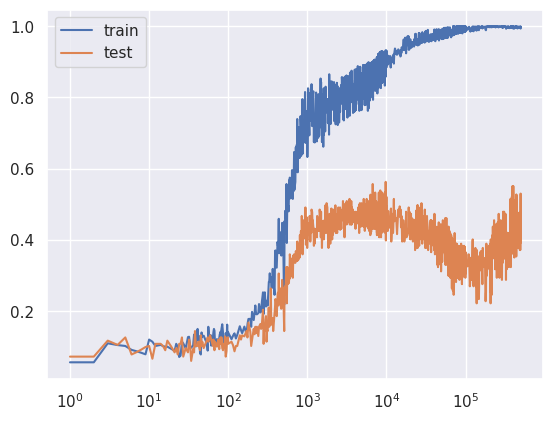

In [147]:
plt.plot(run._step, run["train/acc"], label="train")
# plt.plot(run.index, run["train/acc"], label="smoothed")
plt.plot(run._step, run["test/acc"], label="test")
# plt.plot(run.index, run["test/acc"], label="smoothed")
plt.xscale("log")
plt.legend()
plt.show()

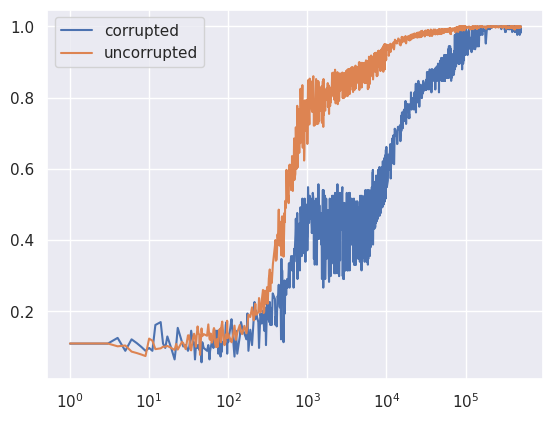

In [148]:
plt.plot(run._step, run["corrupted/acc"], label="corrupted")
# plt.plot(run.index, run["train/acc"], label="smoothed")
plt.plot(run._step, run["uncorrupted/acc"], label="uncorrupted")
# plt.plot(run.index, run["test/acc"], label="smoothed")
plt.xscale("log")
plt.legend()
plt.show()

In [175]:
from scipy.ndimage import gaussian_filter1d

steps = run._step.unique()
og_steps = interp_sweep.loc[interp_sweep.lr_factor == LR_FACTOR]._step.unique()
og_steps = np.array([s - 1 for s in og_steps])

In [173]:
steps

array([     1,      2,      3, ..., 499996, 499997, 499998])

_step  lr_factor  corrupted/acc  test/acc    test/loss   
1         0.000400      5.625       0.108871  0.071856  3038.337762  \
2         0.000600      5.625       0.108871  0.116766  1653.366954   
3         0.000800      5.625       0.125000  0.104790  1535.033776   
4         0.001000      5.625       0.088710  0.125749  1386.334768   
5         0.001200      5.625       0.120968  0.077844  1136.366954   
...            ...        ...            ...       ...          ...   
495999   99.200397      5.625       1.000000  0.529940     0.758644   
496999   99.400398      5.625       1.000000  0.455090     0.823732   
497999   99.600398      5.625       1.000000  0.425150     0.833405   
498999   99.800399      5.625       1.000000  0.431138     0.862611   
499997  100.000000      5.625       1.000000  0.455090     0.830873   

        train/acc   train/loss  uncorrupted/acc  
1        0.055888  3076.802543         0.109339  
2        0.109281  1654.338244         0.109339  
3        0.104291  1523.149656         0.101367  
4        0.101796  1410.088188         0.103645  
5        0.090818  1102.007433         0.086560  
...           ...          ...              ...  
495999   0.998004     0.005087         1.000000  
496999   0.999002     0.002955         0.998861  
497999   0.998004     0.005557         0.997722  
498999   0.998004     0.004992         0.997722  
499997   0.998337     0.006082         0.998102  

[1857 rows x 8 columns]

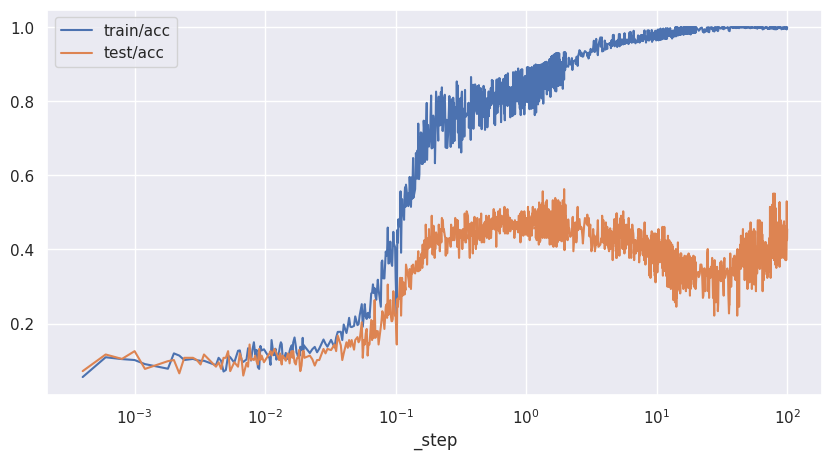

In [177]:
run_sample = run.loc[og_steps, :]
rescaled_run = rescale_run(run_sample, new_max=100., log=False) 

# for metric in METRICS:
#     rescaled_run.loc[metric, :] = gaussian_filter1d(rescaled_run.loc[metric,:])

rescaled_run.plot(x="_step", y=["train/acc", "test/acc"], logx=True, figsize=(10, 5))
rescaled_run

ModuleList(
  (0): Pattern(strength=0.5, speed=50.0, onset=0.10000000149011612, generalization=0.5)
  (1): Pattern(strength=0.5, speed=5.0, onset=2.5, generalization=0.5)
  (2): Pattern(strength=0.5, speed=0.5, onset=62.5, generalization=0.5)
)


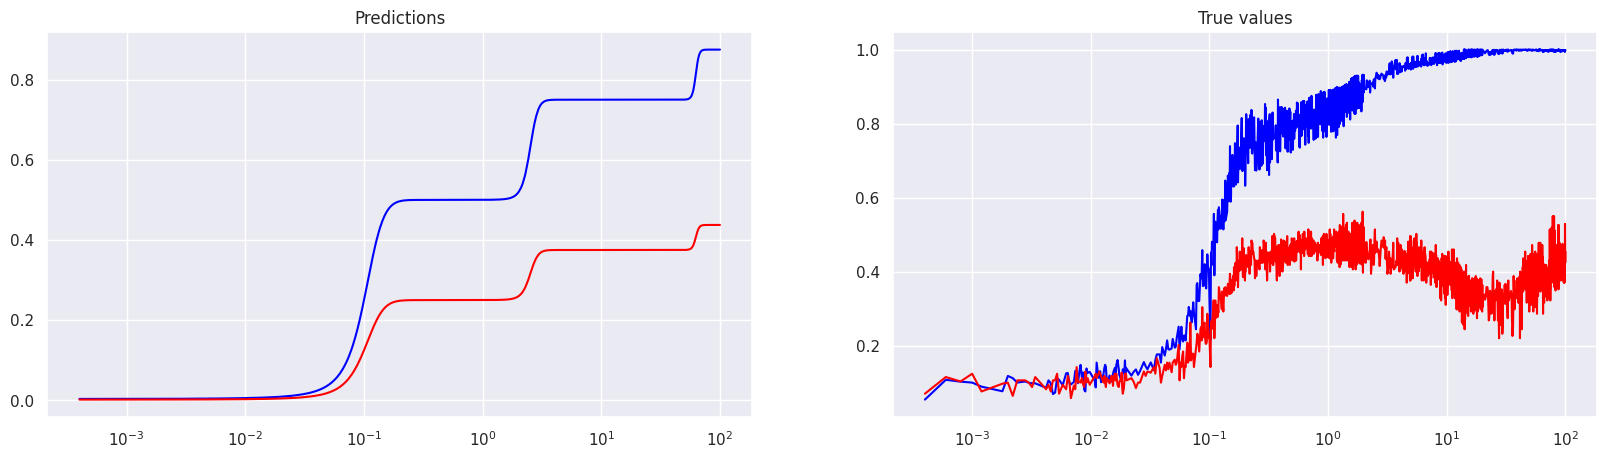

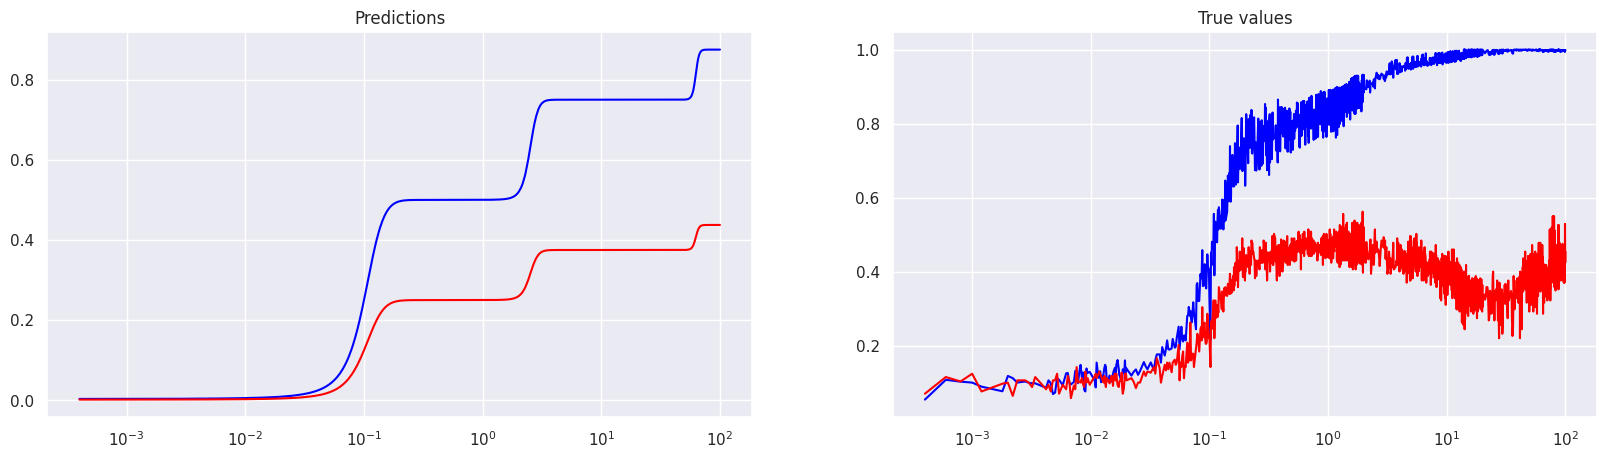

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 - loss: 0.09007862210273743


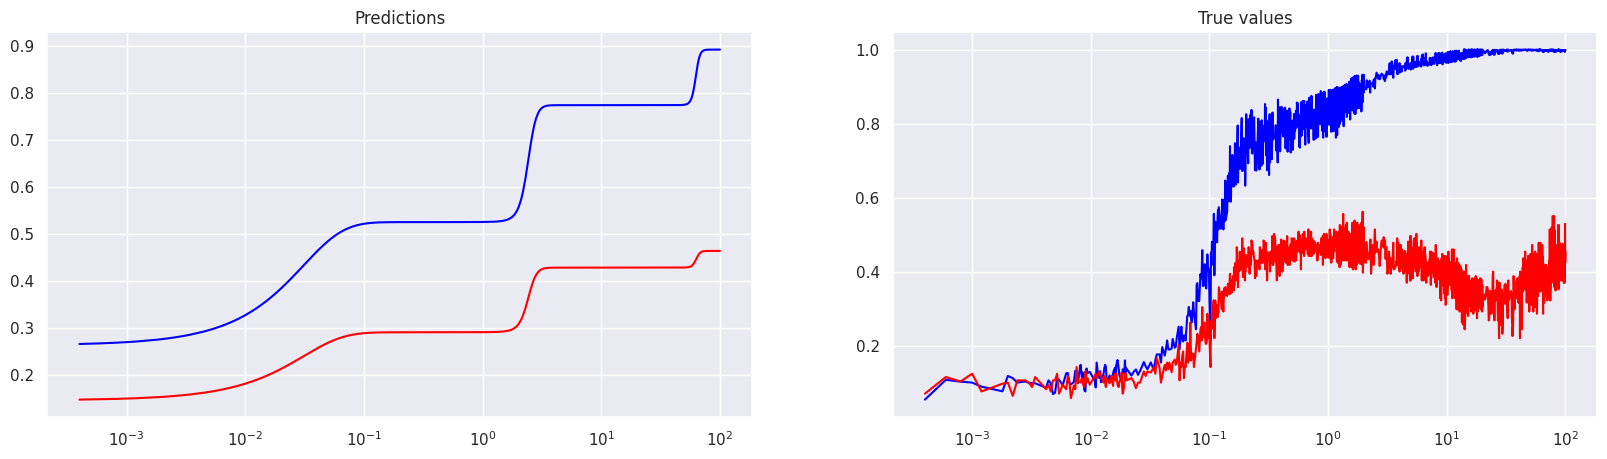

Epoch 1 - loss: 0.07444638013839722
Epoch 2 - loss: 0.05748167634010315
Epoch 3 - loss: 0.045160144567489624
Epoch 4 - loss: 0.03797464817762375
Epoch 5 - loss: 0.027902524918317795
Epoch 6 - loss: 0.014117157086730003
Epoch 7 - loss: 0.01016795914620161
Epoch 8 - loss: 0.009510312229394913
Epoch 9 - loss: 0.006752224639058113
Epoch 10 - loss: 0.0069890571758151054
Epoch 11 - loss: 0.006457556039094925
Epoch 12 - loss: 0.005921044386923313
Epoch 13 - loss: 0.004978554788976908
Epoch 14 - loss: 0.0057689836248755455
Epoch 15 - loss: 0.00541793555021286
Epoch 16 - loss: 0.005185070913285017
Epoch 17 - loss: 0.005481563042849302
Epoch 18 - loss: 0.005749971140176058
Epoch 19 - loss: 0.0055533889681100845
Epoch 20 - loss: 0.005282241851091385
Epoch 21 - loss: 0.0056554293259978294
Epoch 22 - loss: 0.005690337158739567
Epoch 23 - loss: 0.005364009644836187
Epoch 24 - loss: 0.005629534833133221
Epoch 25 - loss: 0.005633262917399406


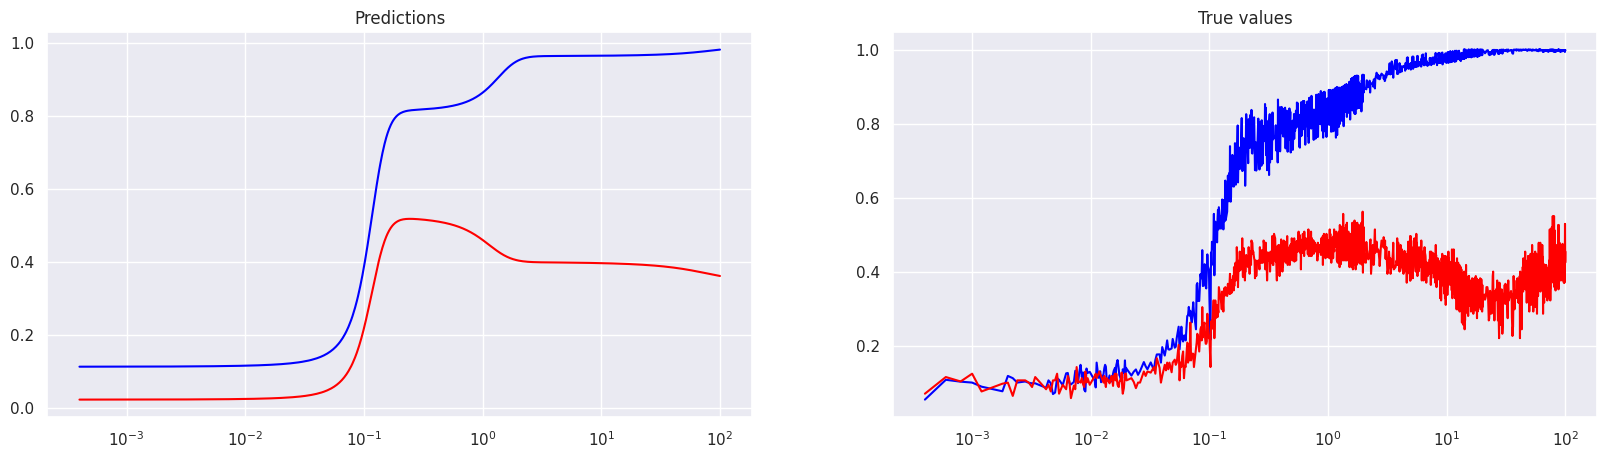

Epoch 26 - loss: 0.005318139214068651
Epoch 27 - loss: 0.005346914753317833
Epoch 28 - loss: 0.00538260955363512
Epoch 29 - loss: 0.005043691955506802
Epoch 30 - loss: 0.005043197423219681
Epoch 31 - loss: 0.004999643191695213
Epoch 32 - loss: 0.0047315871343016624
Epoch 33 - loss: 0.004648950416594744
Epoch 34 - loss: 0.004613132681697607
Epoch 35 - loss: 0.0043679578229784966
Epoch 36 - loss: 0.0043149683624506
Epoch 37 - loss: 0.004249865189194679
Epoch 38 - loss: 0.004065394401550293
Epoch 39 - loss: 0.004002575296908617
Epoch 40 - loss: 0.003948637749999762
Epoch 41 - loss: 0.003796075936406851
Epoch 42 - loss: 0.003783050924539566
Epoch 43 - loss: 0.003699886379763484
Epoch 44 - loss: 0.003605631412938237
Epoch 45 - loss: 0.0036003754939883947
Epoch 46 - loss: 0.0035002008080482483
Epoch 47 - loss: 0.0034810027573257685
Epoch 48 - loss: 0.0034468956291675568
Epoch 49 - loss: 0.0033829619642347097
Epoch 50 - loss: 0.003387138247489929


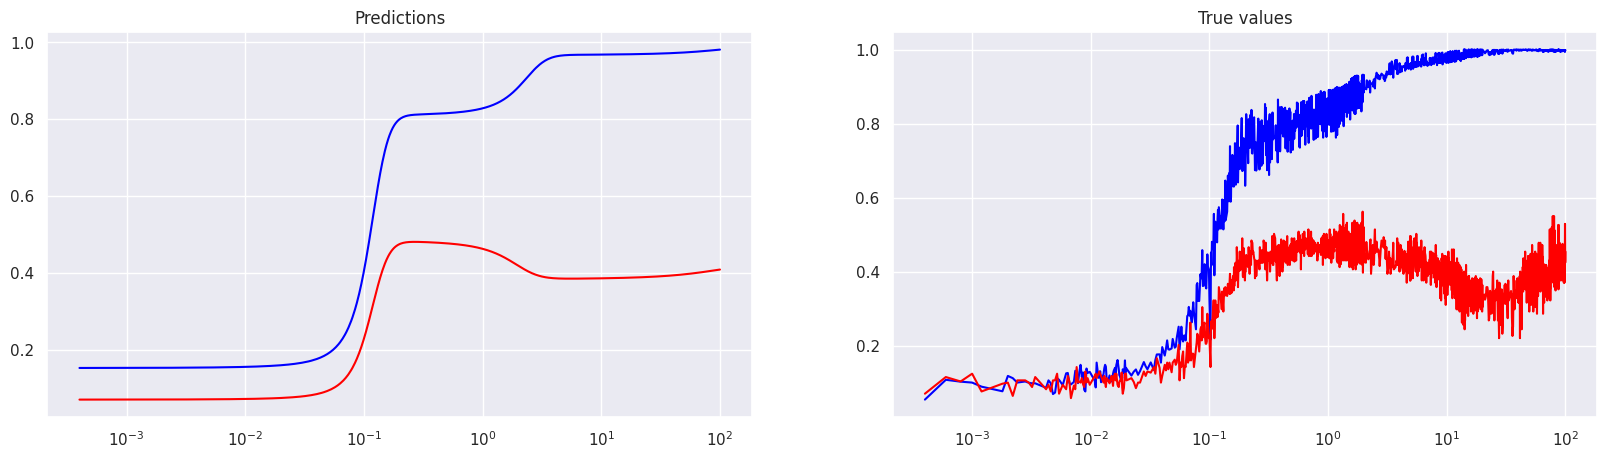

Epoch 51 - loss: 0.0033287606202065945
Epoch 52 - loss: 0.0033269175328314304
Epoch 53 - loss: 0.0033015809021890163
Epoch 54 - loss: 0.0032897843047976494
Epoch 55 - loss: 0.003276101779192686
Epoch 56 - loss: 0.0032671939115971327
Epoch 57 - loss: 0.003260671626776457
Epoch 58 - loss: 0.003254443872720003
Epoch 59 - loss: 0.0032454244792461395
Epoch 60 - loss: 0.0032468042336404324
Epoch 61 - loss: 0.0032305922359228134
Epoch 62 - loss: 0.0032429895363748074
Epoch 63 - loss: 0.003222947008907795
Epoch 64 - loss: 0.00322209345176816
Epoch 65 - loss: 0.0032200911082327366
Epoch 66 - loss: 0.0032038199715316296
Epoch 67 - loss: 0.0032060332596302032
Epoch 68 - loss: 0.0031962492503225803
Epoch 69 - loss: 0.003186963265761733
Epoch 70 - loss: 0.003187017049640417
Epoch 71 - loss: 0.003176353871822357
Epoch 72 - loss: 0.0031712965574115515
Epoch 73 - loss: 0.0031685312278568745
Epoch 74 - loss: 0.003159021493047476
Epoch 75 - loss: 0.0031565590761601925


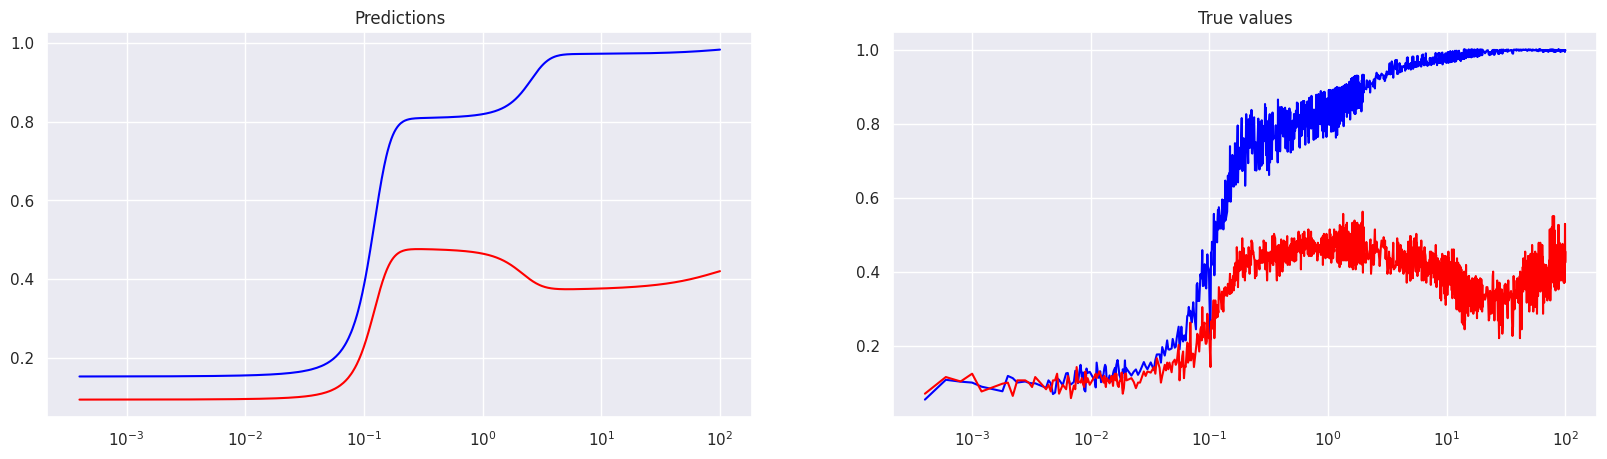

Epoch 76 - loss: 0.003152023535221815
Epoch 77 - loss: 0.0031441254541277885
Epoch 78 - loss: 0.0031424500048160553
Epoch 79 - loss: 0.003136856248602271
Epoch 80 - loss: 0.0031309458427131176
Epoch 81 - loss: 0.00312888715416193
Epoch 82 - loss: 0.0031227876897901297
Epoch 83 - loss: 0.003118695691227913
Epoch 84 - loss: 0.0031158877536654472
Epoch 85 - loss: 0.003110226010903716
Epoch 86 - loss: 0.0031073102727532387
Epoch 87 - loss: 0.0031039081513881683
Epoch 88 - loss: 0.0030994266271591187
Epoch 89 - loss: 0.003096991218626499
Epoch 90 - loss: 0.0030934177339076996
Epoch 91 - loss: 0.0030901406425982714
Epoch 92 - loss: 0.003087859135121107
Epoch 93 - loss: 0.0030844255816191435
Epoch 94 - loss: 0.0030818611849099398
Epoch 95 - loss: 0.003079440211877227
Epoch 96 - loss: 0.003076281165704131
Epoch 97 - loss: 0.00307391001842916
Epoch 98 - loss: 0.003071228973567486
Epoch 99 - loss: 0.0030682189390063286
Epoch 100 - loss: 0.003065783530473709


KeyboardInterrupt: 

In [194]:
model = PatternLearningModel(max_time=100.)

# Initialization
for i, pattern in enumerate(model.patterns):
    max_time = 100
    pattern.onset.data = torch.tensor(0.1 * (0.25 * max_time) ** i)
    pattern.speed.data = torch.tensor((max_time / 2) * 10 ** (-i))
    # pattern._strength.data = pattern._inv_sigmoid(torch.tensor([.8, 1.0, 1.0][i]))
    # pattern._generalization.data = torch.log(torch.tensor([.3, 0.01, .69][i]))

print(model.patterns)

def callback(x): 
    plot_patterns(x, rescaled_run, log=True)
    plt.show()

callback(model)

model.fit(rescaled_run, lr=0.1, num_epochs=500, callback=callback, callback_ivl=25)

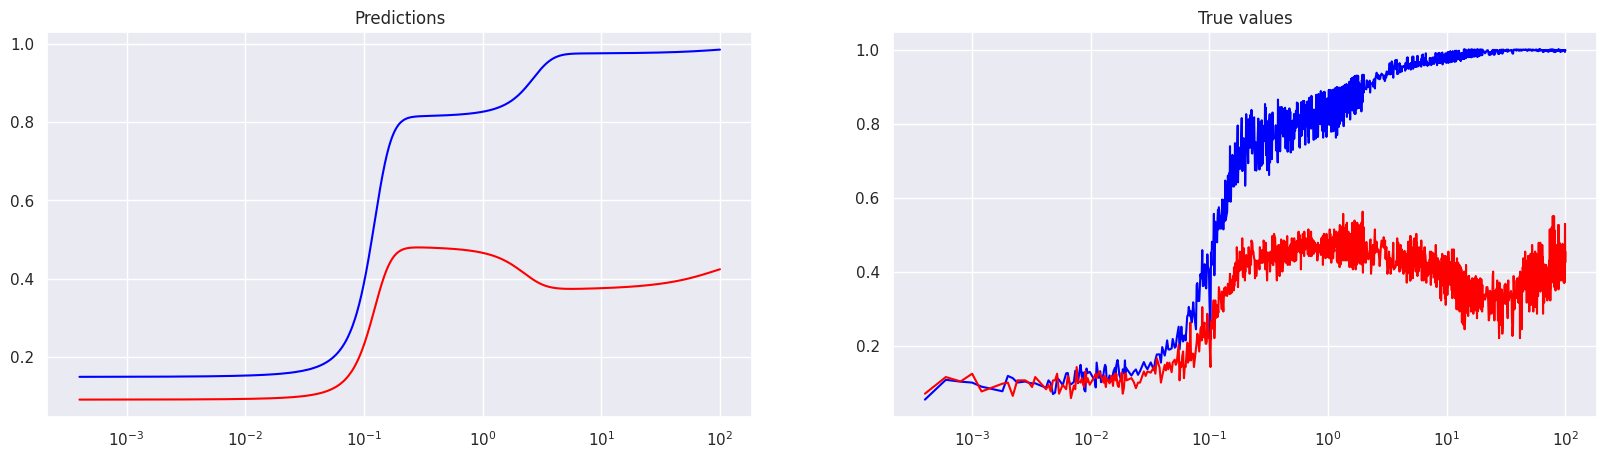

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 0 - loss: 0.003062895964831114


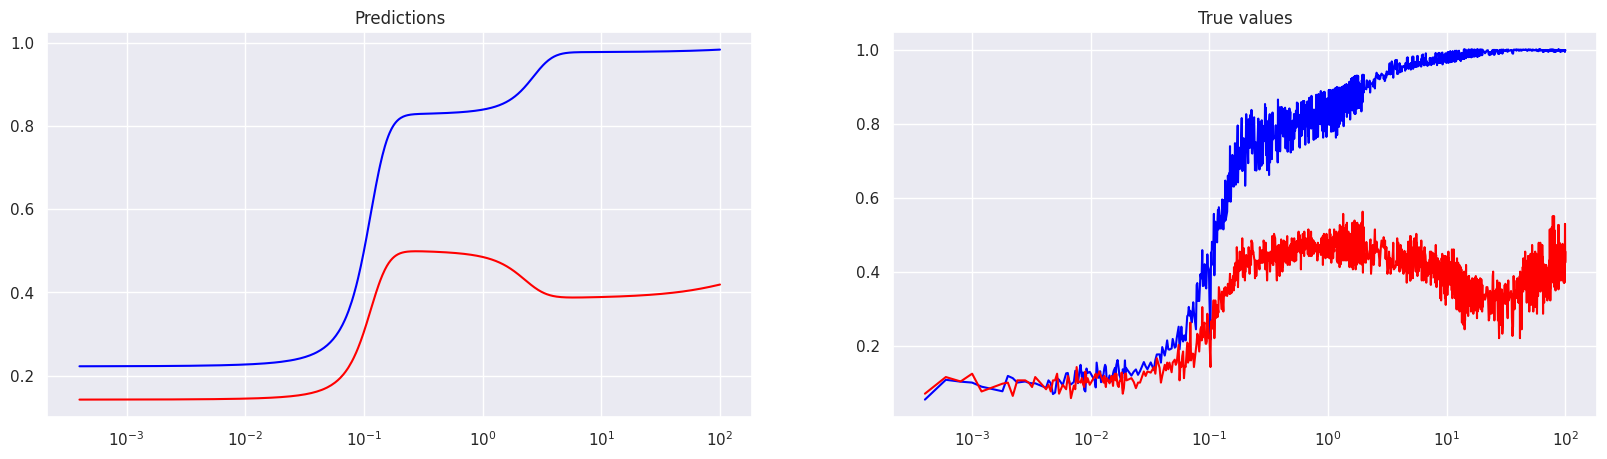

Epoch 1 - loss: 0.004308738280087709
Epoch 2 - loss: 0.0031071575358510017
Epoch 3 - loss: 0.0032998889219015837
Epoch 4 - loss: 0.003695613704621792
Epoch 5 - loss: 0.003710739314556122
Epoch 6 - loss: 0.003468093927949667
Epoch 7 - loss: 0.0031978152692317963
Epoch 8 - loss: 0.003083334770053625
Epoch 9 - loss: 0.003177222330123186
Epoch 10 - loss: 0.0033388854935765266
Epoch 11 - loss: 0.003373207524418831
Epoch 12 - loss: 0.003257123287767172
Epoch 13 - loss: 0.003116273321211338
Epoch 14 - loss: 0.0030592672992497683
Epoch 15 - loss: 0.0030960910953581333
Epoch 16 - loss: 0.003165564499795437
Epoch 17 - loss: 0.0032013054005801678
Epoch 18 - loss: 0.003176402300596237
Epoch 19 - loss: 0.0031108406838029623
Epoch 20 - loss: 0.00305244792252779
Epoch 21 - loss: 0.0030426476150751114
Epoch 22 - loss: 0.003080313093960285
Epoch 23 - loss: 0.0031177829951047897
Epoch 24 - loss: 0.003111594822257757
Epoch 25 - loss: 0.0030705658718943596


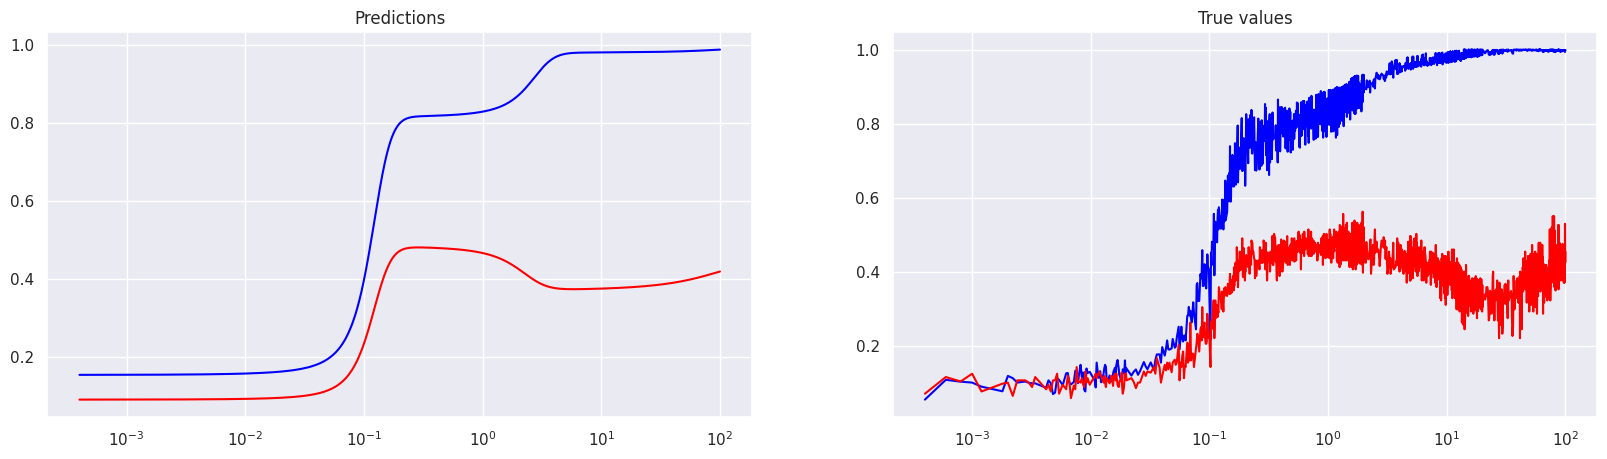

Epoch 26 - loss: 0.0030367919243872166
Epoch 27 - loss: 0.00303542148321867
Epoch 28 - loss: 0.003056226996704936
Epoch 29 - loss: 0.0030728322453796864
Epoch 30 - loss: 0.0030686515383422375
Epoch 31 - loss: 0.0030475854873657227
Epoch 32 - loss: 0.0030274088494479656
Epoch 33 - loss: 0.003023517318069935
Epoch 34 - loss: 0.003034869208931923
Epoch 35 - loss: 0.0030454215593636036
Epoch 36 - loss: 0.0030420604161918163
Epoch 37 - loss: 0.003028642386198044
Epoch 38 - loss: 0.0030190765392035246
Epoch 39 - loss: 0.0030206020455807447
Epoch 40 - loss: 0.00302786473184824
Epoch 41 - loss: 0.0030309646390378475
Epoch 42 - loss: 0.0030259350314736366
Epoch 43 - loss: 0.00301760109141469
Epoch 44 - loss: 0.003013676032423973
Epoch 45 - loss: 0.0030163954943418503
Epoch 46 - loss: 0.0030204295180737972
Epoch 47 - loss: 0.003019724739715457
Epoch 48 - loss: 0.003014795947819948
Epoch 49 - loss: 0.003011085093021393
Epoch 50 - loss: 0.003011629218235612


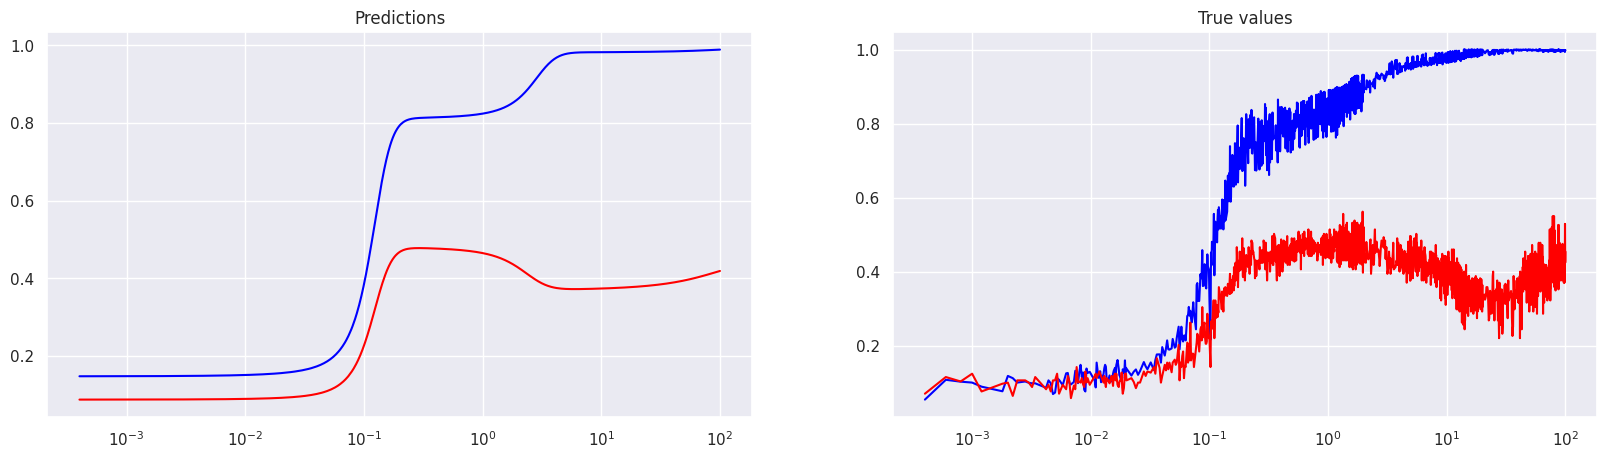

Epoch 51 - loss: 0.003014023881405592
Epoch 52 - loss: 0.003014231799170375
Epoch 53 - loss: 0.003011422697454691
Epoch 54 - loss: 0.0030083844903856516
Epoch 55 - loss: 0.003007797524333
Epoch 56 - loss: 0.003009048756211996
Epoch 57 - loss: 0.0030093903187662363
Epoch 58 - loss: 0.0030076890252530575
Epoch 59 - loss: 0.0030056003015488386
Epoch 60 - loss: 0.0030049793422222137
Epoch 61 - loss: 0.00300553347915411
Epoch 62 - loss: 0.0030056096147745848
Epoch 63 - loss: 0.003004468744620681
Epoch 64 - loss: 0.0030030207708477974
Epoch 65 - loss: 0.0030024282168596983
Epoch 66 - loss: 0.0030025974847376347
Epoch 67 - loss: 0.003002474084496498
Epoch 68 - loss: 0.003001566743478179
Epoch 69 - loss: 0.0030005057342350483
Epoch 70 - loss: 0.0030000205151736736
Epoch 71 - loss: 0.0029999632388353348
Epoch 72 - loss: 0.0029996628873050213
Epoch 73 - loss: 0.0029989019967615604
Epoch 74 - loss: 0.0029981257393956184
Epoch 75 - loss: 0.002997736446559429


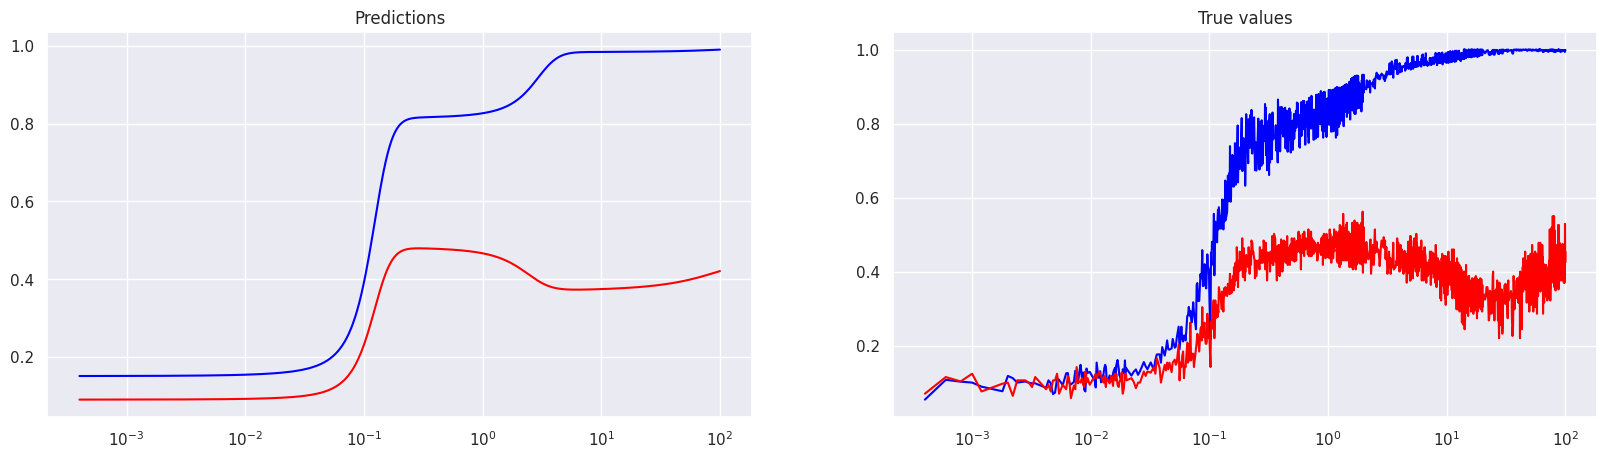

Epoch 76 - loss: 0.0029975459910929203
Epoch 77 - loss: 0.0029971227049827576
Epoch 78 - loss: 0.002996433060616255
Epoch 79 - loss: 0.0029958232771605253
Epoch 80 - loss: 0.0029954693745821714
Epoch 81 - loss: 0.0029951632022857666
Epoch 82 - loss: 0.0029946747235953808
Epoch 83 - loss: 0.002994079142808914
Epoch 84 - loss: 0.0029935971833765507
Epoch 85 - loss: 0.0029932530596852303
Epoch 86 - loss: 0.002992871683090925
Epoch 87 - loss: 0.002992363879457116
Epoch 88 - loss: 0.0029918430373072624
Epoch 89 - loss: 0.0029914239421486855
Epoch 90 - loss: 0.002991054207086563
Epoch 91 - loss: 0.0029906220734119415
Epoch 92 - loss: 0.0029901303350925446
Epoch 93 - loss: 0.002989673987030983
Epoch 94 - loss: 0.002989280503243208
Epoch 95 - loss: 0.0029888800345361233
Epoch 96 - loss: 0.002988427644595504
Epoch 97 - loss: 0.0029879682697355747
Epoch 98 - loss: 0.0029875515028834343
Epoch 99 - loss: 0.002987154759466648
Epoch 100 - loss: 0.0029867300763726234


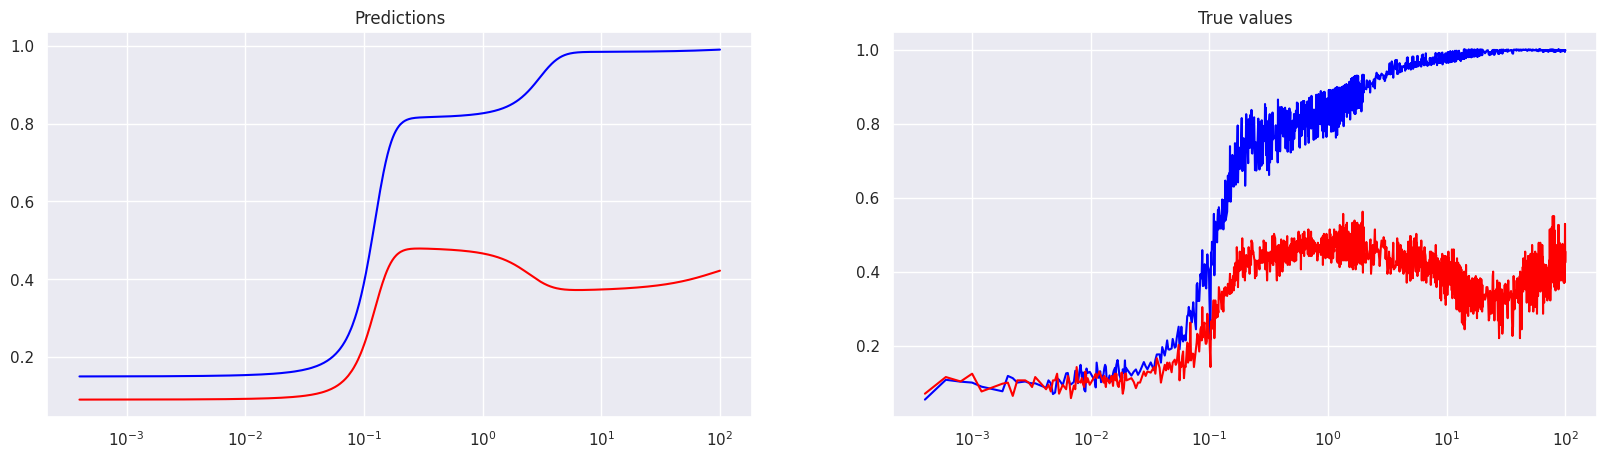

Epoch 101 - loss: 0.0029862828087061644
Epoch 102 - loss: 0.0029858548659831285
Epoch 103 - loss: 0.002985450904816389
Epoch 104 - loss: 0.0029850401915609837
Epoch 105 - loss: 0.002984609454870224
Epoch 106 - loss: 0.0029841819778084755
Epoch 107 - loss: 0.0029837735928595066
Epoch 108 - loss: 0.0029833687003701925
Epoch 109 - loss: 0.002982950769364834
Epoch 110 - loss: 0.0029825284145772457
Epoch 111 - loss: 0.0029821174684911966
Epoch 112 - loss: 0.002981714205816388
Epoch 113 - loss: 0.0029813041910529137
Epoch 114 - loss: 0.0029808885883539915
Epoch 115 - loss: 0.0029804790392518044
Epoch 116 - loss: 0.0029800767078995705
Epoch 117 - loss: 0.0029796725139021873
Epoch 118 - loss: 0.002979263197630644
Epoch 119 - loss: 0.002978856908157468
Epoch 120 - loss: 0.0029784557409584522
Epoch 121 - loss: 0.0029780548065900803
Epoch 122 - loss: 0.0029776510782539845
Epoch 123 - loss: 0.0029772480484098196
Epoch 124 - loss: 0.0029768485110253096
Epoch 125 - loss: 0.0029764508362859488


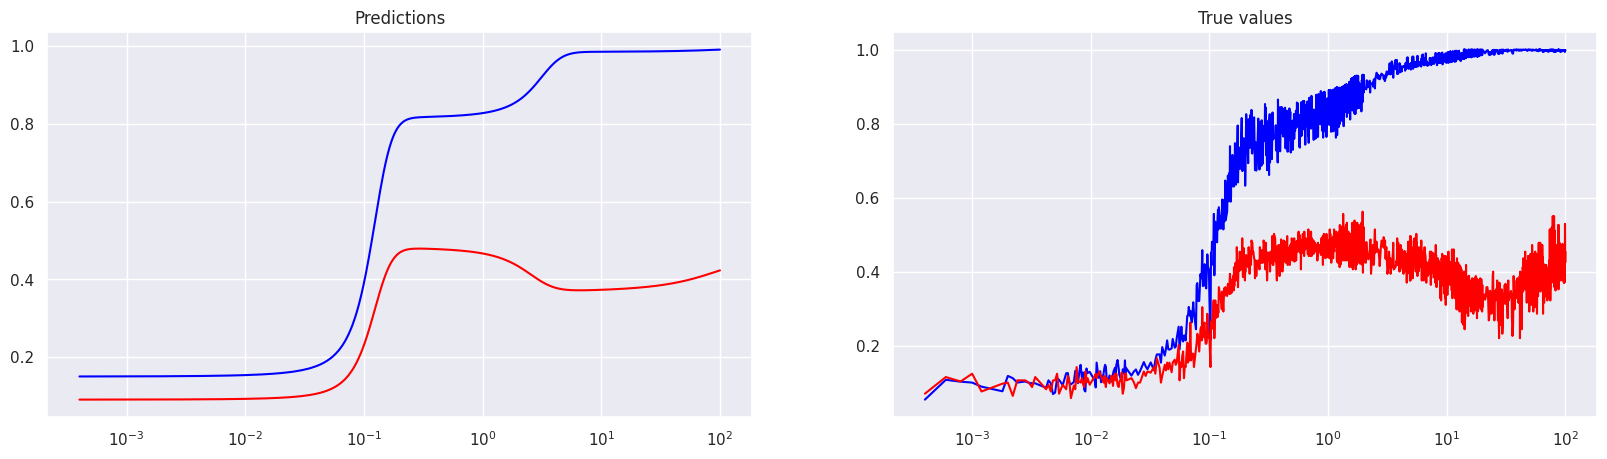

Epoch 126 - loss: 0.0029760515317320824
Epoch 127 - loss: 0.0029756524600088596
Epoch 128 - loss: 0.0029752557165920734
Epoch 129 - loss: 0.00297486106865108
Epoch 130 - loss: 0.0029744652565568686
Epoch 131 - loss: 0.0029740696772933006
Epoch 132 - loss: 0.0029736761935055256
Epoch 133 - loss: 0.0029732845723628998
Epoch 134 - loss: 0.002972892252728343
Epoch 135 - loss: 0.0029724999330937862
Epoch 136 - loss: 0.0029721094761043787
Epoch 137 - loss: 0.002971720416098833
Epoch 138 - loss: 0.002971331123262644
Epoch 139 - loss: 0.002970942296087742
Epoch 140 - loss: 0.0029705544002354145
Epoch 141 - loss: 0.002970167901366949
Epoch 142 - loss: 0.002969781868159771
Epoch 143 - loss: 0.0029693960677832365
Epoch 144 - loss: 0.0029690111987292767
Epoch 145 - loss: 0.0029686270281672478
Epoch 146 - loss: 0.0029682437889277935
Epoch 147 - loss: 0.0029678605496883392
Epoch 148 - loss: 0.0029674782417714596
Epoch 149 - loss: 0.002967097330838442
Epoch 150 - loss: 0.002966715954244137


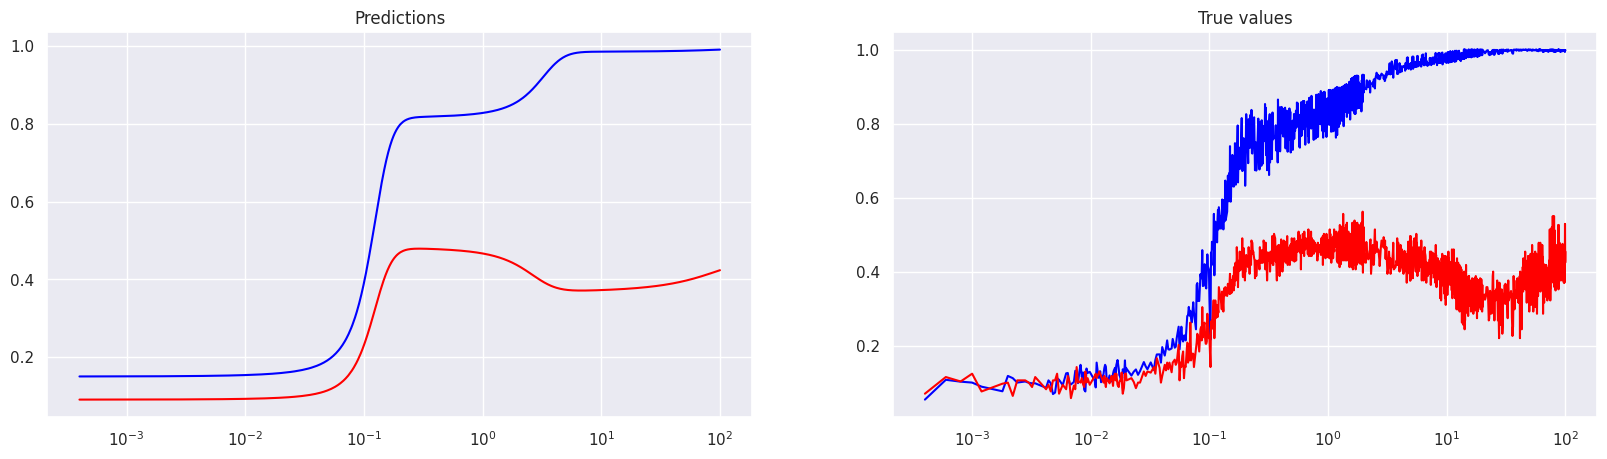

Epoch 151 - loss: 0.0029663355089724064
Epoch 152 - loss: 0.002965955762192607
Epoch 153 - loss: 0.0029655767139047384
Epoch 154 - loss: 0.0029651981312781572
Epoch 155 - loss: 0.0029648197814822197
Epoch 156 - loss: 0.0029644425958395004
Epoch 157 - loss: 0.002964065643027425
Epoch 158 - loss: 0.0029636891558766365
Epoch 159 - loss: 0.002963313367217779
Epoch 160 - loss: 0.0029629378113895655
Epoch 161 - loss: 0.002962562721222639
Epoch 162 - loss: 0.002962188795208931
Epoch 163 - loss: 0.0029618144035339355
Epoch 164 - loss: 0.0029614409431815147
Epoch 165 - loss: 0.002961068181321025
Epoch 166 - loss: 0.002960695419460535
Epoch 167 - loss: 0.00296032358892262
Epoch 168 - loss: 0.002959951525554061
Epoch 169 - loss: 0.002959580160677433
Epoch 170 - loss: 0.0029592090286314487
Epoch 171 - loss: 0.0029588385950773954
Epoch 172 - loss: 0.002958468394353986
Epoch 173 - loss: 0.00295809842646122
Epoch 174 - loss: 0.0029577286913990974
Epoch 175 - loss: 0.0029573598876595497


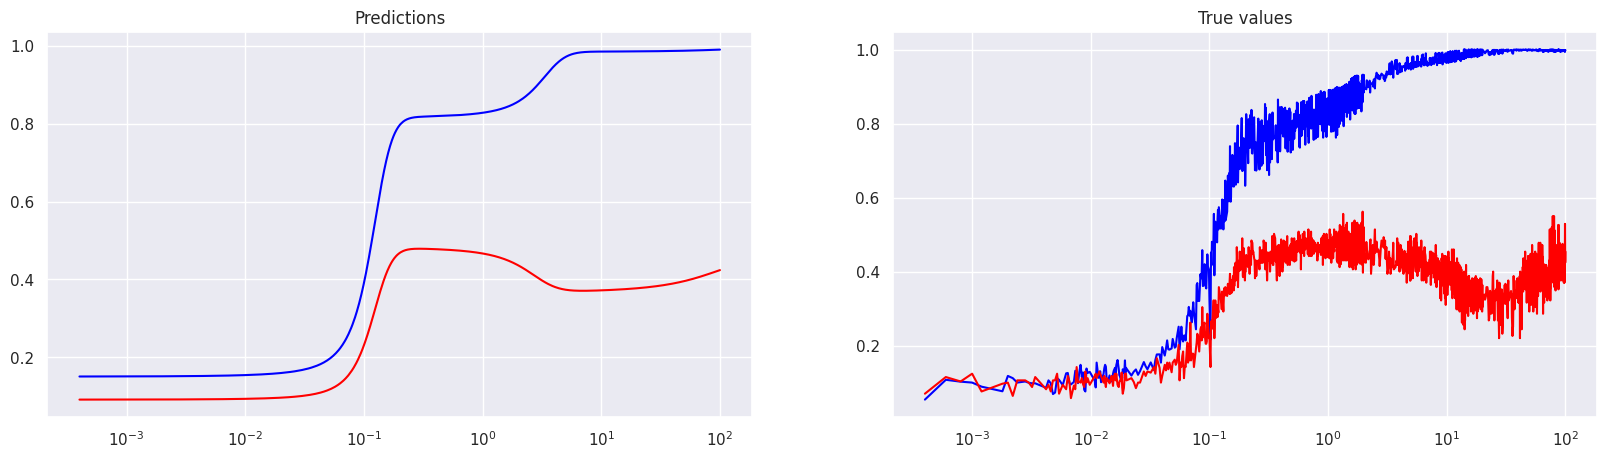

Epoch 176 - loss: 0.002956991083920002
Epoch 177 - loss: 0.0029566222801804543
Epoch 178 - loss: 0.00295625370927155
Epoch 179 - loss: 0.0029558856040239334
Epoch 180 - loss: 0.002955517964437604
Epoch 181 - loss: 0.0029551503248512745
Epoch 182 - loss: 0.002954783383756876
Epoch 183 - loss: 0.002954416209831834
Epoch 184 - loss: 0.0029540490359067917
Epoch 185 - loss: 0.002953682793304324
Epoch 186 - loss: 0.0029533160850405693
Epoch 187 - loss: 0.0029529500752687454
Epoch 188 - loss: 0.002952584531158209
Epoch 189 - loss: 0.0029522182885557413
Epoch 190 - loss: 0.0029518527444452047
Epoch 191 - loss: 0.002951486734673381
Epoch 192 - loss: 0.002951121423393488
Epoch 193 - loss: 0.0029507558792829514
Epoch 194 - loss: 0.0029503910336643457
Epoch 195 - loss: 0.0029500259552150965
Epoch 196 - loss: 0.002949661109596491
Epoch 197 - loss: 0.0029492960311472416
Epoch 198 - loss: 0.0029489316511899233
Epoch 199 - loss: 0.0029485668055713177
Epoch 200 - loss: 0.0029482021927833557


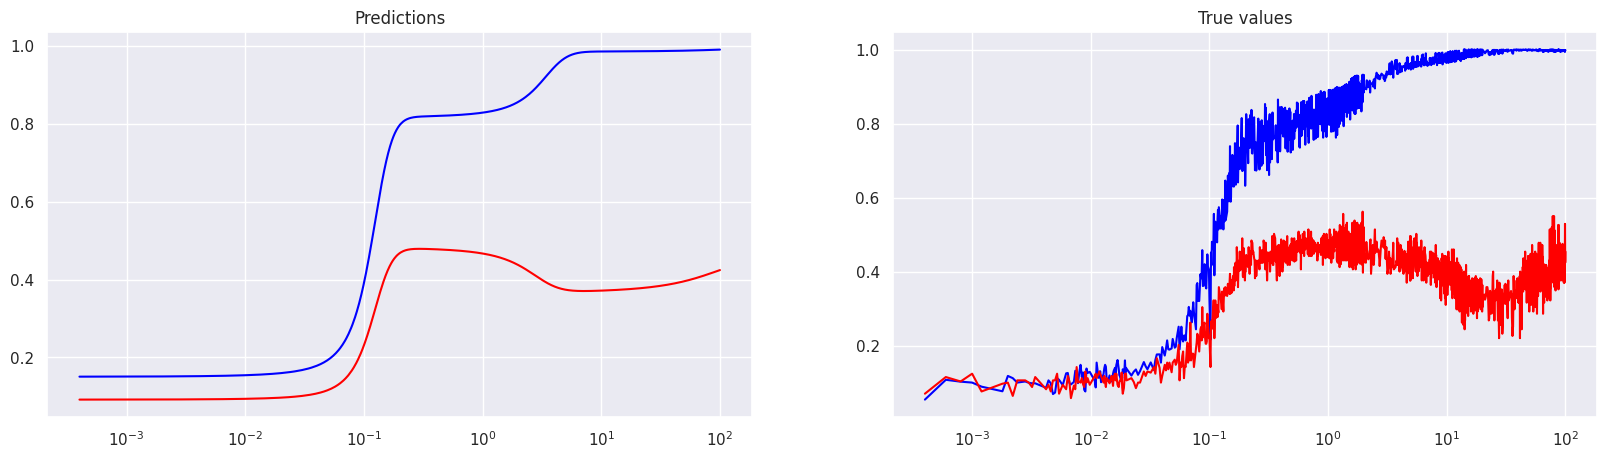

Epoch 201 - loss: 0.00294783734716475
Epoch 202 - loss: 0.002947472734376788
Epoch 203 - loss: 0.0029471078887581825
Epoch 204 - loss: 0.002946743741631508
Epoch 205 - loss: 0.002946379128843546
Epoch 206 - loss: 0.002946014516055584
Epoch 207 - loss: 0.0029456503689289093
Epoch 208 - loss: 0.0029452862218022346
Epoch 209 - loss: 0.002944921376183629
Epoch 210 - loss: 0.0029445565305650234
Epoch 211 - loss: 0.0029441919177770615
Epoch 212 - loss: 0.0029438273049890995
Epoch 213 - loss: 0.0029434626922011375
Epoch 214 - loss: 0.0029430980794131756
Epoch 215 - loss: 0.00294273323379457
Epoch 216 - loss: 0.0029423688538372517
Epoch 217 - loss: 0.0029420037753880024
Epoch 218 - loss: 0.002941638231277466
Epoch 219 - loss: 0.0029412731528282166
Epoch 220 - loss: 0.0029409080743789673
Epoch 221 - loss: 0.002940542995929718
Epoch 222 - loss: 0.0029401774518191814
Epoch 223 - loss: 0.002939811907708645
Epoch 224 - loss: 0.0029394463635981083
Epoch 225 - loss: 0.002939080586656928


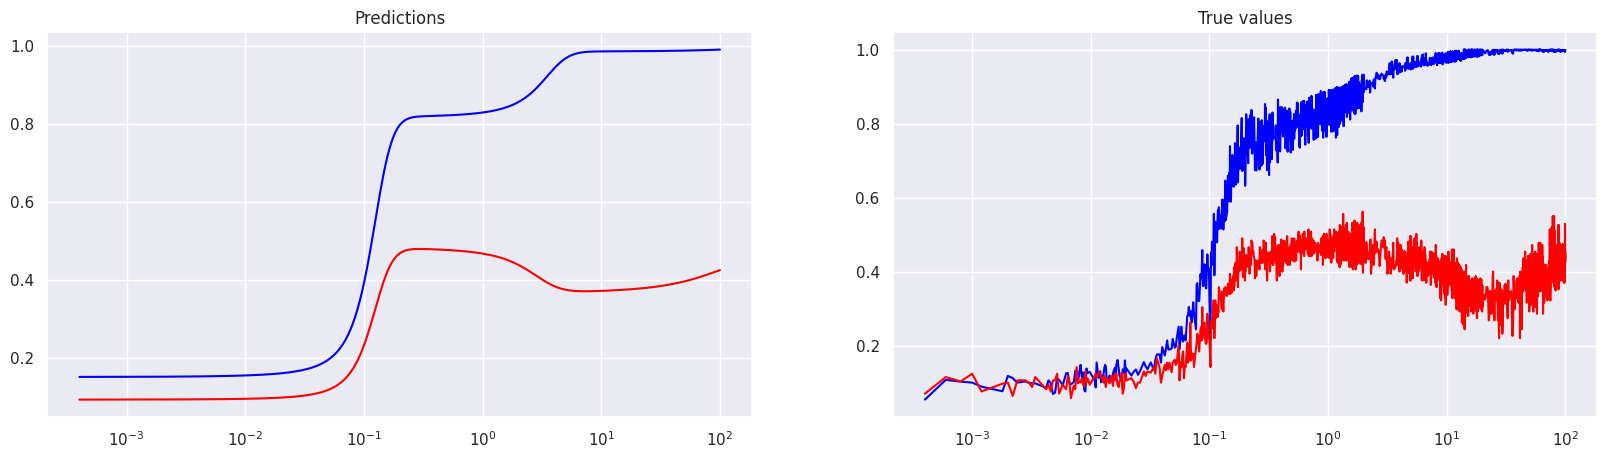

Epoch 226 - loss: 0.0029387143440544605
Epoch 227 - loss: 0.0029383483342826366
Epoch 228 - loss: 0.002937982091680169
Epoch 229 - loss: 0.0029376158490777016
Epoch 230 - loss: 0.002937248907983303
Epoch 231 - loss: 0.0029368821997195482
Epoch 232 - loss: 0.0029365154914557934
Epoch 233 - loss: 0.002936148550361395
Epoch 234 - loss: 0.002935781143605709
Epoch 235 - loss: 0.0029354137368500233
Epoch 236 - loss: 0.0029350463300943375
Epoch 237 - loss: 0.0029346784576773643
Epoch 238 - loss: 0.0029343103524297476
Epoch 239 - loss: 0.0029339417815208435
Epoch 240 - loss: 0.002933573443442583
Epoch 241 - loss: 0.002933204872533679
Epoch 242 - loss: 0.002932835603132844
Epoch 243 - loss: 0.0029324665665626526
Epoch 244 - loss: 0.0029320968315005302
Epoch 245 - loss: 0.0029317273292690516
Epoch 246 - loss: 0.0029313573613762856
Epoch 247 - loss: 0.002930987160652876
Epoch 248 - loss: 0.0029306169599294662
Epoch 249 - loss: 0.002930245827883482
Epoch 250 - loss: 0.002929875161498785


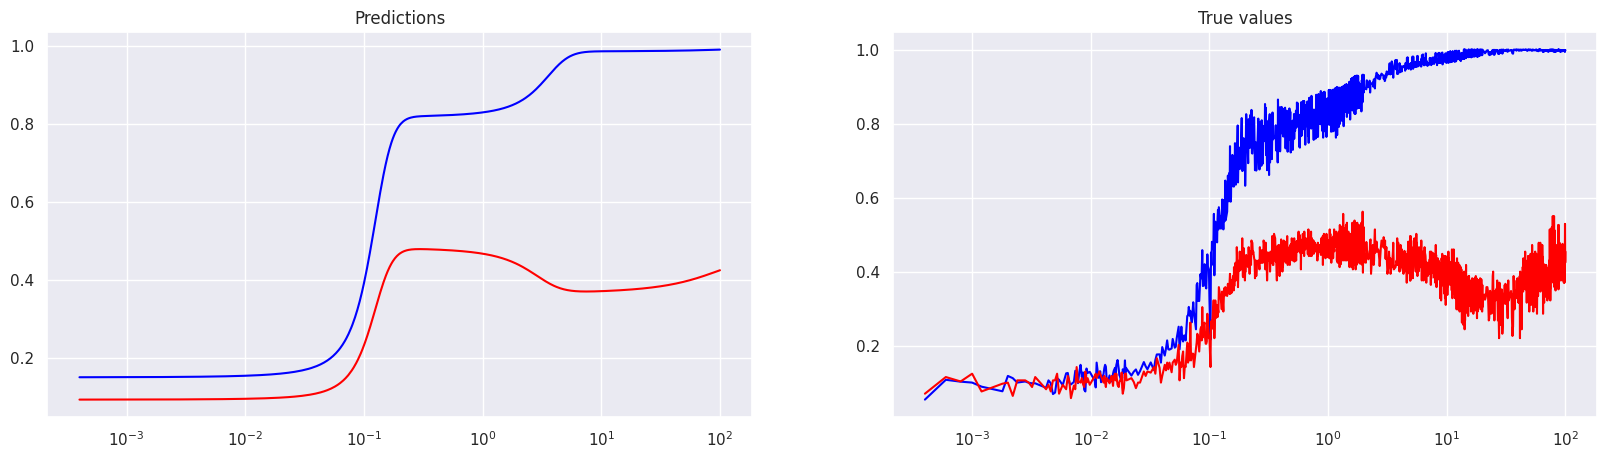

Epoch 251 - loss: 0.0029295040294528008
Epoch 252 - loss: 0.002929132431745529
Epoch 253 - loss: 0.0029287608340382576
Epoch 254 - loss: 0.0029283887706696987
Epoch 255 - loss: 0.0029280162416398525
Epoch 256 - loss: 0.0029276441782712936
Epoch 257 - loss: 0.00292727118358016
Epoch 258 - loss: 0.0029268977232277393
Epoch 259 - loss: 0.002926524728536606
Epoch 260 - loss: 0.0029261510353535414
Epoch 261 - loss: 0.0029257768765091896
Epoch 262 - loss: 0.002925402484834194
Epoch 263 - loss: 0.0029250280931591988
Epoch 264 - loss: 0.0029246527701616287
Epoch 265 - loss: 0.002924277912825346
Epoch 266 - loss: 0.002923902589827776
Epoch 267 - loss: 0.0029235268011689186
Epoch 268 - loss: 0.0029231507796794176
Epoch 269 - loss: 0.0029227742925286293
Epoch 270 - loss: 0.00292239710688591
Epoch 271 - loss: 0.002922020386904478
Epoch 272 - loss: 0.0029216427356004715
Epoch 273 - loss: 0.002921265084296465
Epoch 274 - loss: 0.002920886967331171
Epoch 275 - loss: 0.002920508850365877


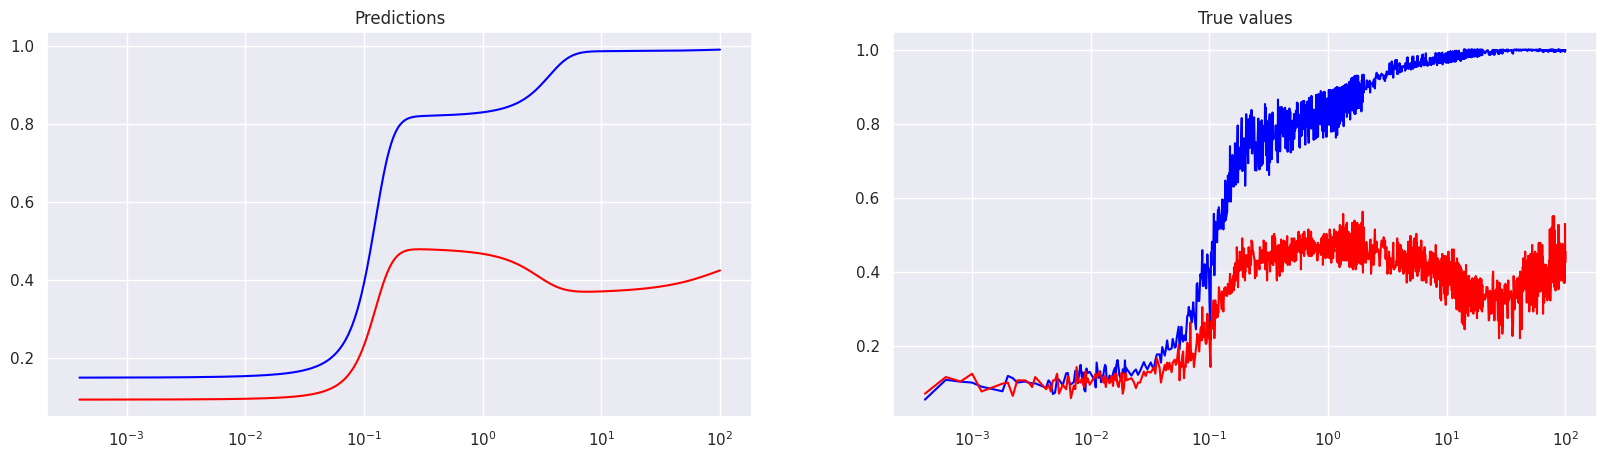

Epoch 276 - loss: 0.0029201298020780087
Epoch 277 - loss: 0.00291975075379014
Epoch 278 - loss: 0.0029193712398409843
Epoch 279 - loss: 0.0029189917258918285
Epoch 280 - loss: 0.0029186117462813854
Epoch 281 - loss: 0.002918231301009655
Epoch 282 - loss: 0.0029178503900766373
Epoch 283 - loss: 0.0029174694791436195
Epoch 284 - loss: 0.002917087869718671
Epoch 285 - loss: 0.0029167060274630785
Epoch 286 - loss: 0.0029163239523768425
Epoch 287 - loss: 0.002915941644459963
Epoch 288 - loss: 0.0029155586380511522
Epoch 289 - loss: 0.0029151756316423416
Epoch 290 - loss: 0.0029147921595722437
Epoch 291 - loss: 0.002914407756179571
Epoch 292 - loss: 0.0029140240512788296
Epoch 293 - loss: 0.0029136394150555134
Epoch 294 - loss: 0.0029132545460015535
Epoch 295 - loss: 0.0029128689784556627
Epoch 296 - loss: 0.0029124836437404156
Epoch 297 - loss: 0.0029120976105332375
Epoch 298 - loss: 0.0029117113444954157
Epoch 299 - loss: 0.0029113246127963066
Epoch 300 - loss: 0.0029109371826052666


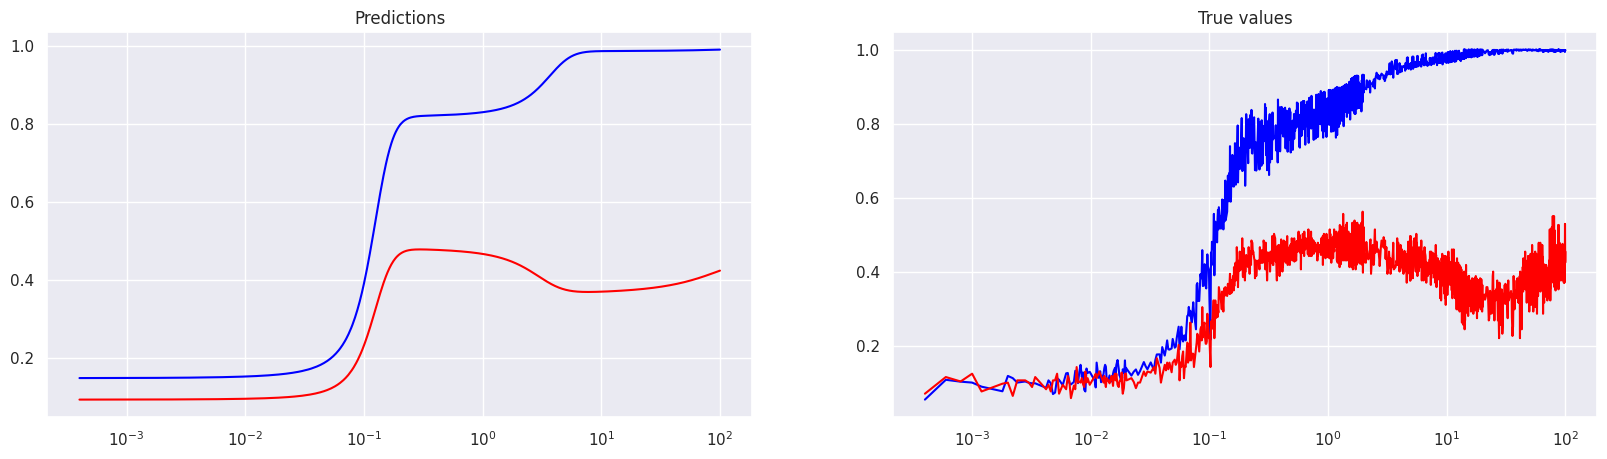

Epoch 301 - loss: 0.002910550218075514
Epoch 302 - loss: 0.0029101623222231865
Epoch 303 - loss: 0.002909774426370859
Epoch 304 - loss: 0.0029093860648572445
Epoch 305 - loss: 0.002908997004851699
Epoch 306 - loss: 0.0029086079448461533
Epoch 307 - loss: 0.0029082184191793203
Epoch 308 - loss: 0.0029078284278512
Epoch 309 - loss: 0.0029074382036924362
Epoch 310 - loss: 0.002907047513872385
Epoch 311 - loss: 0.002906656824052334
Epoch 312 - loss: 0.0029062656685709953
Epoch 313 - loss: 0.0029058740474283695
Epoch 314 - loss: 0.0029054824262857437
Epoch 315 - loss: 0.0029050898738205433
Epoch 316 - loss: 0.002904697321355343
Epoch 317 - loss: 0.002904304303228855
Epoch 318 - loss: 0.00290391081944108
Epoch 319 - loss: 0.002903517335653305
Epoch 320 - loss: 0.002903123153373599
Epoch 321 - loss: 0.002902728971093893
Epoch 322 - loss: 0.0029023343231528997
Epoch 323 - loss: 0.002901939209550619
Epoch 324 - loss: 0.002901543863117695
Epoch 325 - loss: 0.002901148283854127


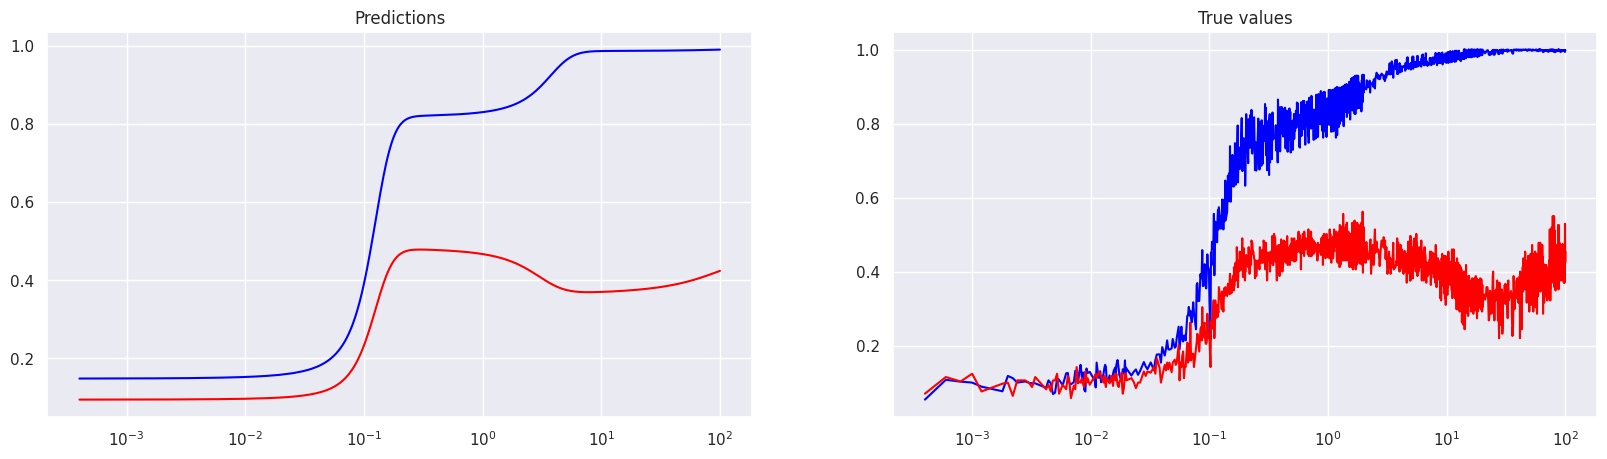

Epoch 326 - loss: 0.0029007524717599154
Epoch 327 - loss: 0.002900355961173773
Epoch 328 - loss: 0.0028999592177569866
Epoch 329 - loss: 0.002899562008678913
Epoch 330 - loss: 0.0028991647996008396
Epoch 331 - loss: 0.002898767590522766
Epoch 332 - loss: 0.0028983696829527617
Epoch 333 - loss: 0.00289797130972147
Epoch 334 - loss: 0.0028975727036595345
Epoch 335 - loss: 0.0028971738647669554
Epoch 336 - loss: 0.002896774560213089
Epoch 337 - loss: 0.002896375022828579
Epoch 338 - loss: 0.002895975485444069
Epoch 339 - loss: 0.0028955754823982716
Epoch 340 - loss: 0.002895175013691187
Epoch 341 - loss: 0.0028947745449841022
Epoch 342 - loss: 0.0028943736106157303
Epoch 343 - loss: 0.0028939719777554274
Epoch 344 - loss: 0.0028935703448951244
Epoch 345 - loss: 0.0028931687120348215
Epoch 346 - loss: 0.0028927666135132313
Epoch 347 - loss: 0.0028923642821609974
Epoch 348 - loss: 0.0028919619508087635
Epoch 349 - loss: 0.002891558688133955
Epoch 350 - loss: 0.0028911554254591465


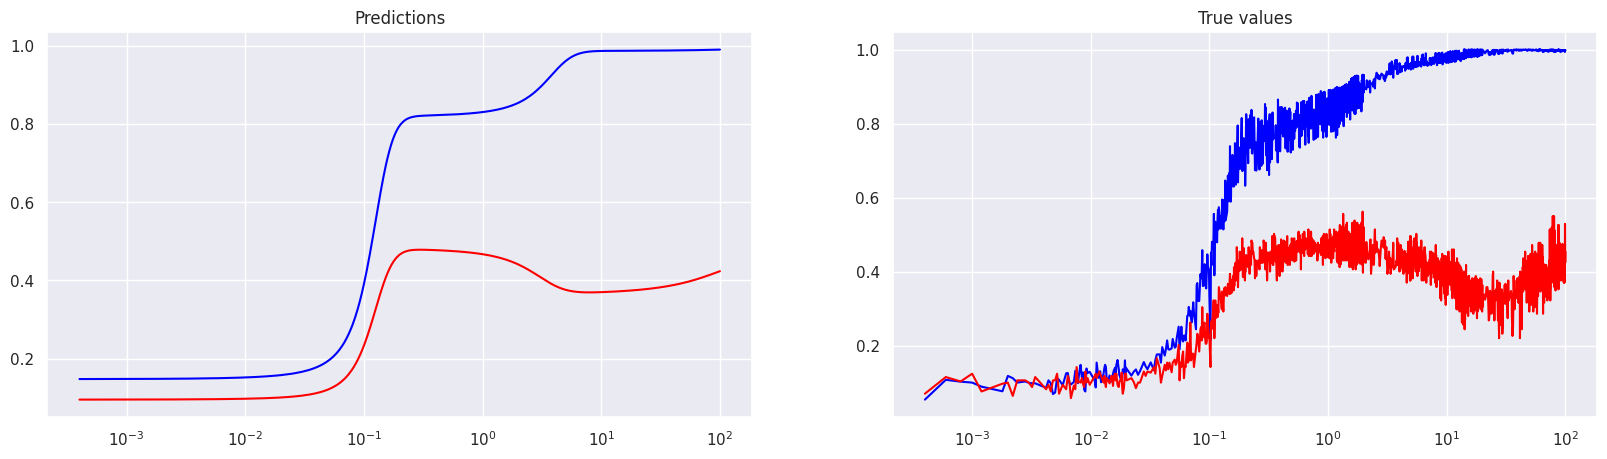

Epoch 351 - loss: 0.002890752162784338
Epoch 352 - loss: 0.002890348434448242
Epoch 353 - loss: 0.002889944240450859
Epoch 354 - loss: 0.002889540046453476
Epoch 355 - loss: 0.002889135619625449
Epoch 356 - loss: 0.0028887311927974224
Epoch 357 - loss: 0.002888325834646821
Epoch 358 - loss: 0.002887920942157507
Epoch 359 - loss: 0.002887515351176262
Epoch 360 - loss: 0.002887109760195017
Epoch 361 - loss: 0.002886703936383128
Epoch 362 - loss: 0.002886297646909952
Epoch 363 - loss: 0.00288589159026742
Epoch 364 - loss: 0.0028854850679636
Epoch 365 - loss: 0.002885078079998493
Epoch 366 - loss: 0.0028846710920333862
Epoch 367 - loss: 0.002884263638406992
Epoch 368 - loss: 0.002883856650441885
Epoch 369 - loss: 0.002883448963984847
Epoch 370 - loss: 0.0028830417431890965
Epoch 371 - loss: 0.0028826333582401276
Epoch 372 - loss: 0.002882225438952446
Epoch 373 - loss: 0.002881817054003477
Epoch 374 - loss: 0.0028814091347157955
Epoch 375 - loss: 0.0028810002841055393


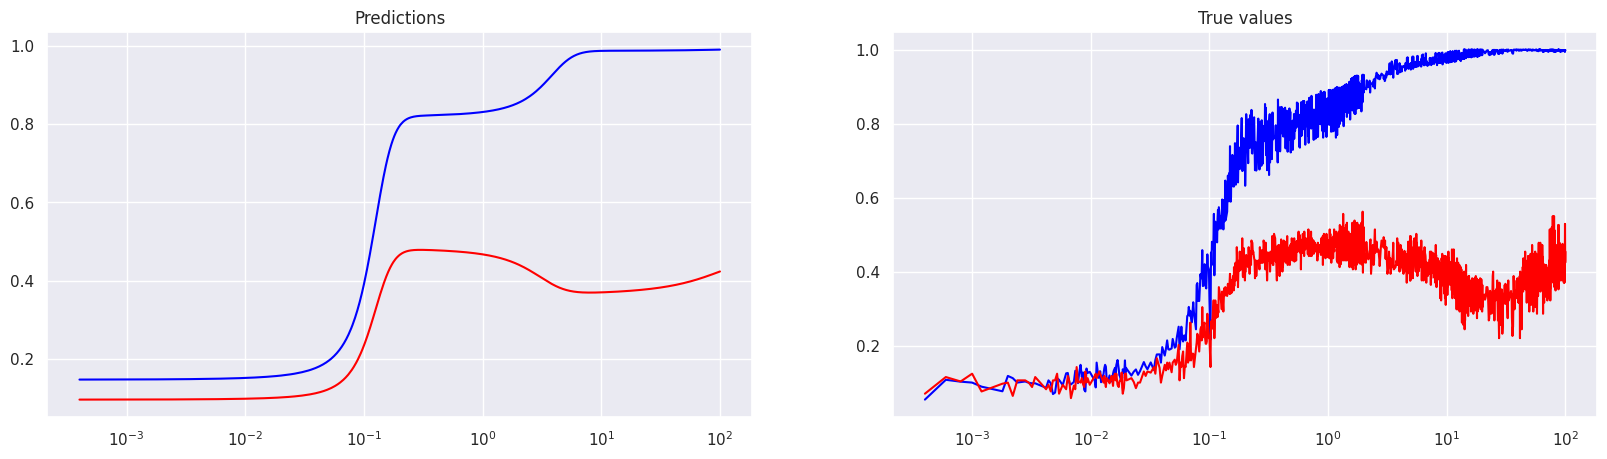

Epoch 376 - loss: 0.002880591433495283
Epoch 377 - loss: 0.002880182582885027
Epoch 378 - loss: 0.0028797737322747707
Epoch 379 - loss: 0.00287936395034194
Epoch 380 - loss: 0.0028789546340703964
Epoch 381 - loss: 0.002878545317798853
Epoch 382 - loss: 0.002878135535866022
Epoch 383 - loss: 0.0028777257539331913
Epoch 384 - loss: 0.002877316204831004
Epoch 385 - loss: 0.002876905957236886
Epoch 386 - loss: 0.002876495709642768
Epoch 387 - loss: 0.0028760856948792934
Epoch 388 - loss: 0.0028756754472851753
Epoch 389 - loss: 0.002875265199691057
Epoch 390 - loss: 0.0028748544864356518
Epoch 391 - loss: 0.0028744437731802464
Epoch 392 - loss: 0.0028740332927554846
Epoch 393 - loss: 0.002873622579500079
Epoch 394 - loss: 0.00287321163341403
Epoch 395 - loss: 0.0028728009201586246
Epoch 396 - loss: 0.0028723902069032192
Epoch 397 - loss: 0.0028719790279865265
Epoch 398 - loss: 0.0028715678490698338
Epoch 399 - loss: 0.002871156670153141


PatternLearningModel({'pattern_0/strength': tensor(0.7909), 'pattern_0/speed': tensor(37.7515), 'pattern_0/onset': tensor(0.1142), 'pattern_0/generalization': tensor(0.5752), 'pattern_1/strength': tensor(0.9353), 'pattern_1/speed': tensor(0.9204), 'pattern_1/onset': tensor(3.2300), 'pattern_1/generalization': tensor(0.1391), 'pattern_2/strength': tensor(0.4482), 'pattern_2/speed': tensor(0.0212), 'pattern_2/onset': tensor(61.3547), 'pattern_2/generalization': tensor(0.9157)})

In [195]:
model.fit(rescaled_run, lr=0.01, num_epochs=400, callback=callback, callback_ivl=25)

ModuleList(
  (0): Pattern(strength=0.7908795475959778, speed=37.7514762878418, onset=0.11423435062170029, generalization=0.575205385684967)
  (1): Pattern(strength=0.9352647066116333, speed=0.9203890562057495, onset=3.230018377304077, generalization=0.13906963169574738)
  (2): Pattern(strength=0.4481505751609802, speed=0.021193457767367363, onset=61.35466384887695, generalization=0.915656566619873)
)


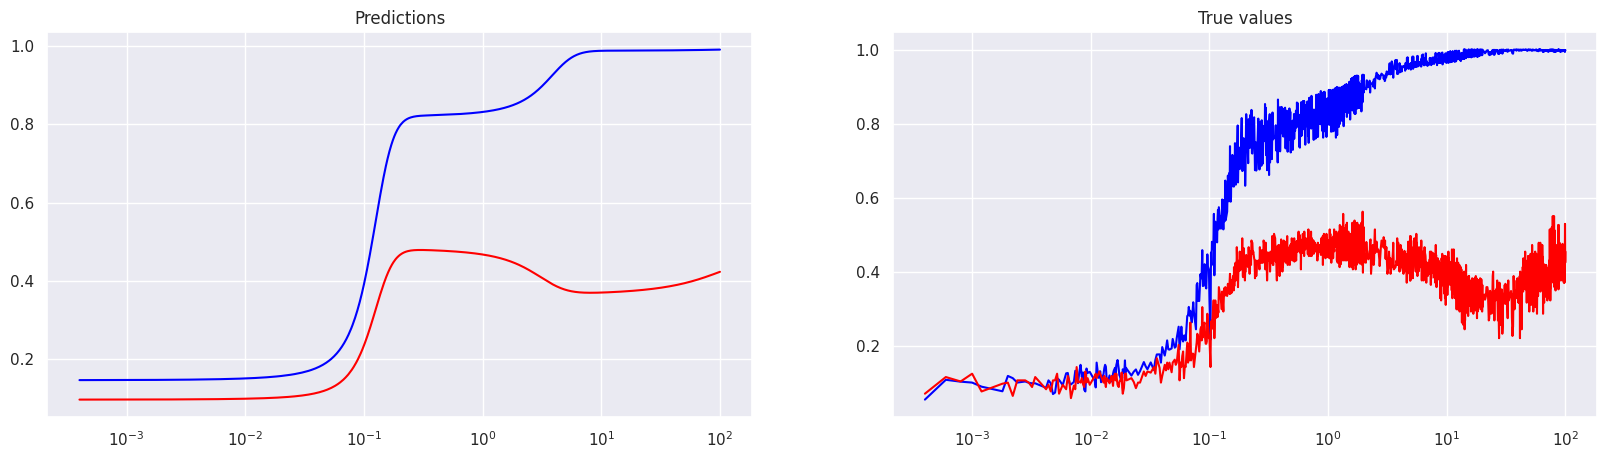

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0 - loss: 0.002870745724067092


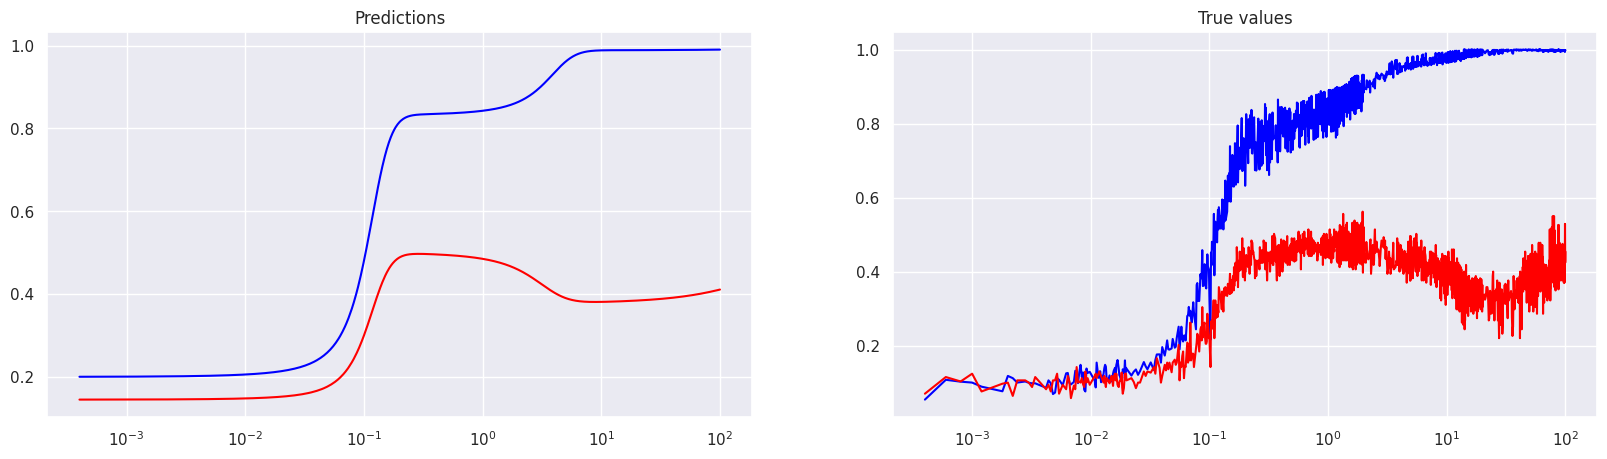

Epoch 1 - loss: 0.0038184085860848427
Epoch 2 - loss: 0.002904145047068596
Epoch 3 - loss: 0.00317283533513546
Epoch 4 - loss: 0.003443657886236906
Epoch 5 - loss: 0.0033352705650031567
Epoch 6 - loss: 0.0030614444985985756
Epoch 7 - loss: 0.002881044987589121
Epoch 8 - loss: 0.0029334700666368008
Epoch 9 - loss: 0.0031017474830150604
Epoch 10 - loss: 0.0031414495315402746
Epoch 11 - loss: 0.003025601152330637
Epoch 12 - loss: 0.0029047878924757242
Epoch 13 - loss: 0.0028823791071772575
Epoch 14 - loss: 0.002940406324341893
Epoch 15 - loss: 0.003002115059643984
Epoch 16 - loss: 0.003012538654729724
Epoch 17 - loss: 0.0029690605588257313
Epoch 18 - loss: 0.0029083979316055775
Epoch 19 - loss: 0.0028756954707205296
Epoch 20 - loss: 0.0028906255029141903
Epoch 21 - loss: 0.0029291706159710884
Epoch 22 - loss: 0.0029461742378771305
Epoch 23 - loss: 0.002923858817666769
Epoch 24 - loss: 0.00288693537004292
Epoch 25 - loss: 0.002869531512260437
Epoch 26 - loss: 0.002880419371649623
Epoch 27 

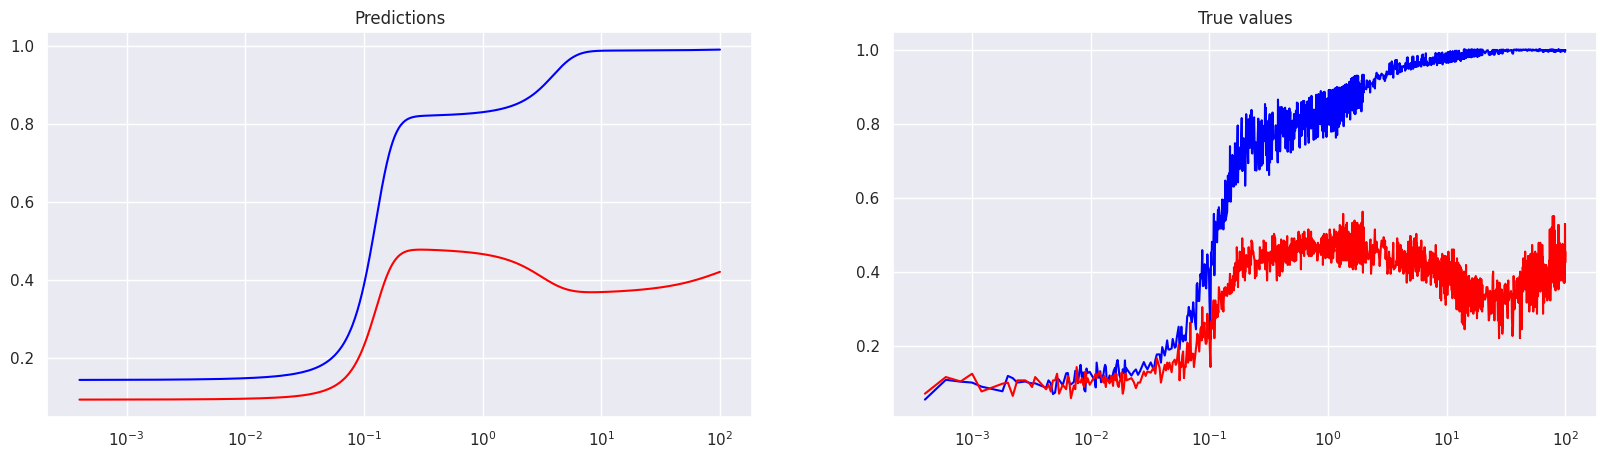

Epoch 51 - loss: 0.0028609628789126873
Epoch 52 - loss: 0.0028586576227098703
Epoch 53 - loss: 0.0028589817229658365
Epoch 54 - loss: 0.0028605086263269186
Epoch 55 - loss: 0.002860503736883402
Epoch 56 - loss: 0.0028586997650563717
Epoch 57 - loss: 0.002857252024114132
Epoch 58 - loss: 0.002857465762645006
Epoch 59 - loss: 0.0028582557570189238
Epoch 60 - loss: 0.0028580008074641228
Epoch 61 - loss: 0.0028567363042384386
Epoch 62 - loss: 0.0028558368794620037
Epoch 63 - loss: 0.0028559877537190914
Epoch 64 - loss: 0.0028563509695231915
Epoch 65 - loss: 0.0028559411875903606
Epoch 66 - loss: 0.002855023369193077
Epoch 67 - loss: 0.002854530233889818
Epoch 68 - loss: 0.0028546443209052086
Epoch 69 - loss: 0.0028546848334372044
Epoch 70 - loss: 0.002854203339666128
Epoch 71 - loss: 0.002853563753888011
Epoch 72 - loss: 0.002853292739018798
Epoch 73 - loss: 0.002853304147720337
Epoch 74 - loss: 0.0028531155548989773
Epoch 75 - loss: 0.0028526154346764088
Epoch 76 - loss: 0.002852170728147

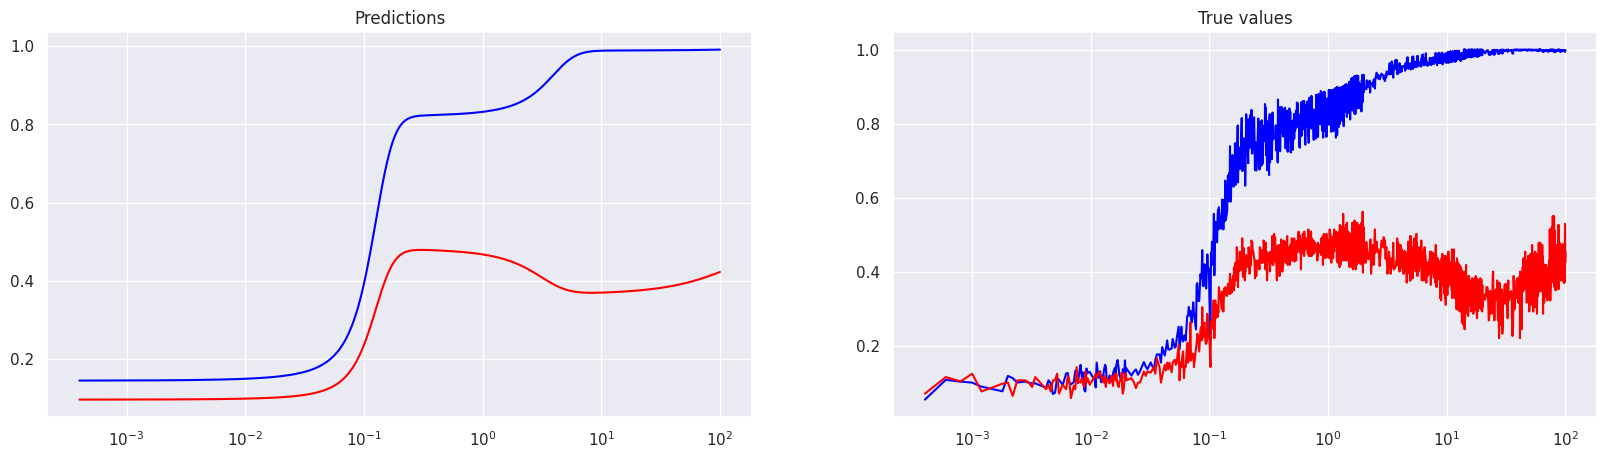

Epoch 101 - loss: 0.0028455927968025208
Epoch 102 - loss: 0.002845311537384987
Epoch 103 - loss: 0.0028450521640479565
Epoch 104 - loss: 0.002844798844307661
Epoch 105 - loss: 0.002844527829438448
Epoch 106 - loss: 0.0028442502953112125
Epoch 107 - loss: 0.002843986265361309
Epoch 108 - loss: 0.0028437285218387842
Epoch 109 - loss: 0.0028434605337679386
Epoch 110 - loss: 0.0028431853279471397
Epoch 111 - loss: 0.002842918038368225
Epoch 112 - loss: 0.0028426572680473328
Epoch 113 - loss: 0.0028423888143152
Epoch 114 - loss: 0.002842115703970194
Epoch 115 - loss: 0.0028418470174074173
Epoch 116 - loss: 0.00284158275462687
Epoch 117 - loss: 0.002841314533725381
Epoch 118 - loss: 0.002841042121872306
Epoch 119 - loss: 0.0028407727368175983
Epoch 120 - loss: 0.0028405063785612583
Epoch 121 - loss: 0.0028402372263371944
Epoch 122 - loss: 0.0028399648144841194
Epoch 123 - loss: 0.002839694730937481
Epoch 124 - loss: 0.0028394265100359917
Epoch 125 - loss: 0.002839156426489353
Epoch 126 - los

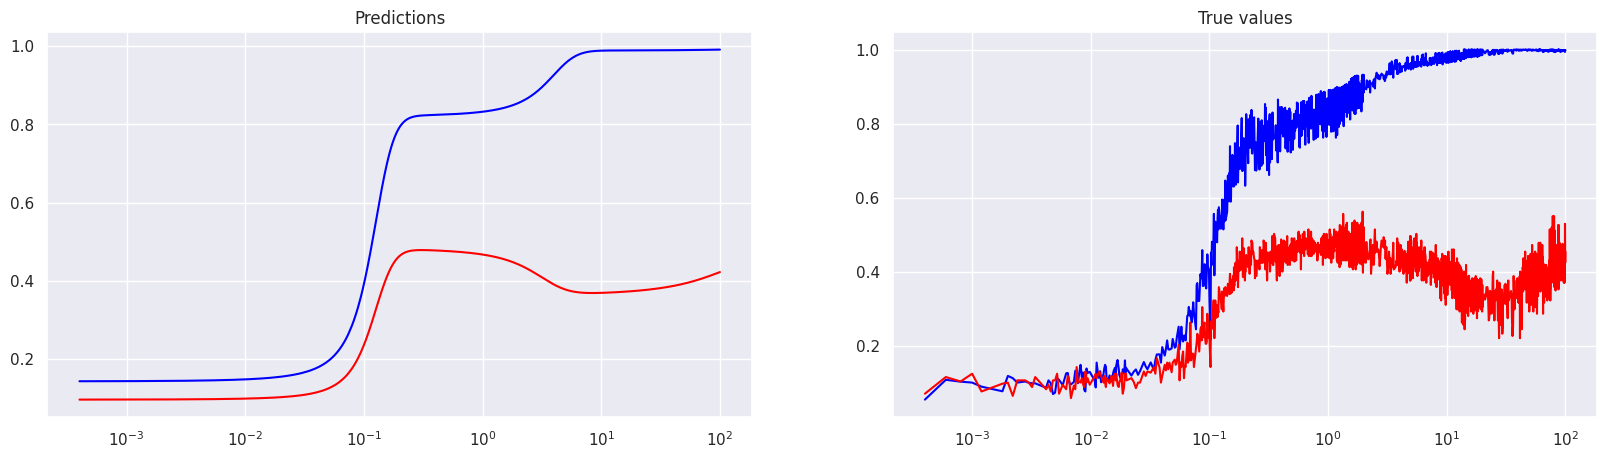

Epoch 151 - loss: 0.002832044381648302
Epoch 152 - loss: 0.0028317677788436413
Epoch 153 - loss: 0.0028314911760389805
Epoch 154 - loss: 0.0028312141075730324
Epoch 155 - loss: 0.0028309375047683716
Epoch 156 - loss: 0.00283066020347178
Epoch 157 - loss: 0.0028303831350058317
Epoch 158 - loss: 0.0028301056008785963
Epoch 159 - loss: 0.002829828066751361
Epoch 160 - loss: 0.002829550066962838
Epoch 161 - loss: 0.002829271834343672
Epoch 162 - loss: 0.002828993834555149
Epoch 163 - loss: 0.002828715369105339
Epoch 164 - loss: 0.002828436903655529
Epoch 165 - loss: 0.0028281579725444317
Epoch 166 - loss: 0.002827879274263978
Epoch 167 - loss: 0.002827600110322237
Epoch 168 - loss: 0.0028273211792111397
Epoch 169 - loss: 0.002827041782438755
Epoch 170 - loss: 0.0028267623856663704
Epoch 171 - loss: 0.002826482756063342
Epoch 172 - loss: 0.002826203126460314
Epoch 173 - loss: 0.002825923264026642
Epoch 174 - loss: 0.002825642703101039
Epoch 175 - loss: 0.0028253626078367233
Epoch 176 - loss

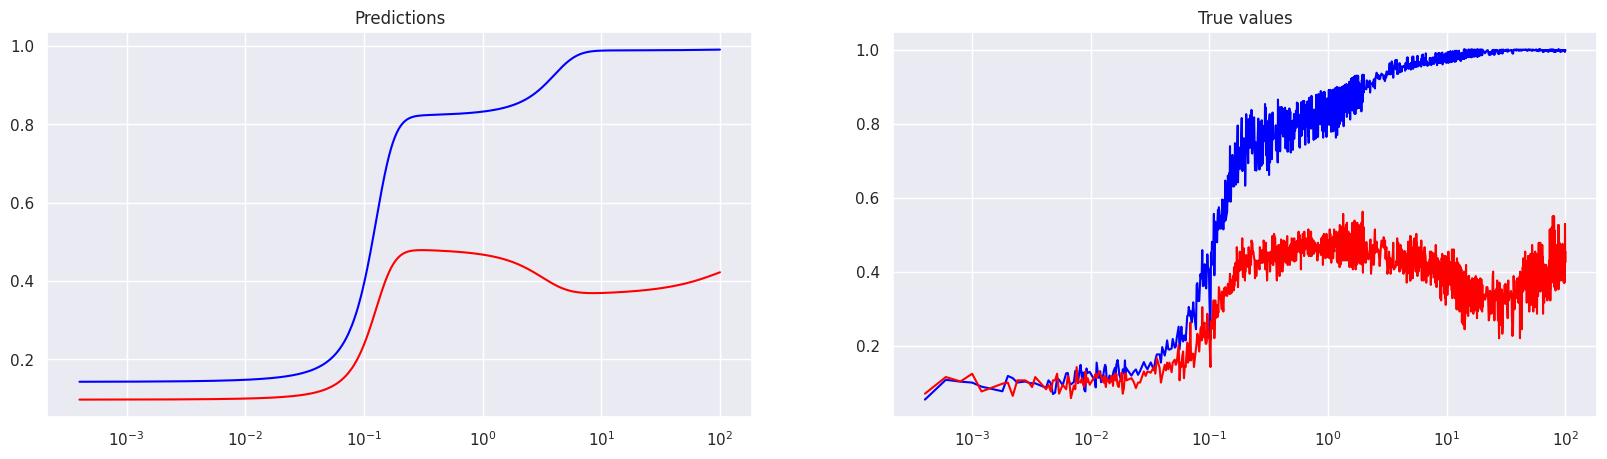

Epoch 201 - loss: 0.002818034030497074
Epoch 202 - loss: 0.002817750908434391
Epoch 203 - loss: 0.0028174675535410643
Epoch 204 - loss: 0.002817183965817094
Epoch 205 - loss: 0.0028169008437544107
Epoch 206 - loss: 0.0028166170231997967
Epoch 207 - loss: 0.0028163334354758263
Epoch 208 - loss: 0.002816049847751856
Epoch 209 - loss: 0.002815765794366598
Epoch 210 - loss: 0.0028154822066426277
Epoch 211 - loss: 0.00281519815325737
Epoch 212 - loss: 0.0028149140998721123
Epoch 213 - loss: 0.0028146300464868546
Epoch 214 - loss: 0.002814345993101597
Epoch 215 - loss: 0.002814061939716339
Epoch 216 - loss: 0.002813777420669794
Epoch 217 - loss: 0.0028134931344538927
Epoch 218 - loss: 0.002813209081068635
Epoch 219 - loss: 0.00281292456202209
Epoch 220 - loss: 0.0028126402758061886
Epoch 221 - loss: 0.0028123557567596436
Epoch 222 - loss: 0.0028120712377130985
Epoch 223 - loss: 0.002811786253005266
Epoch 224 - loss: 0.002811501733958721
Epoch 225 - loss: 0.002811217214912176
Epoch 226 - loss

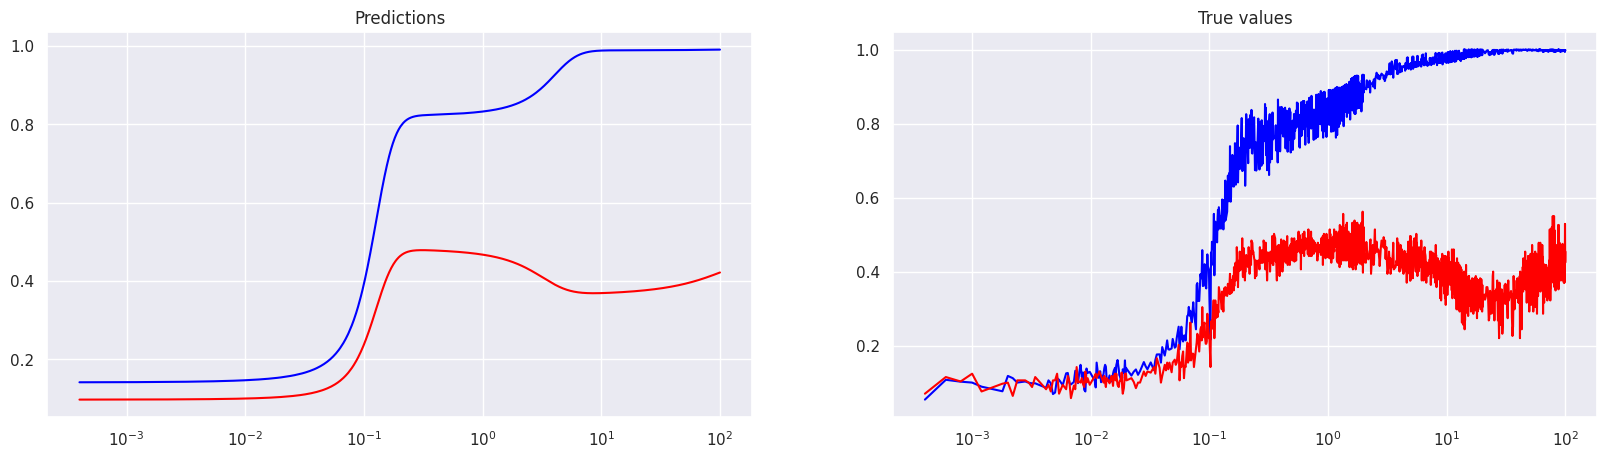

Epoch 251 - loss: 0.0028038080781698227
Epoch 252 - loss: 0.0028035228606313467
Epoch 253 - loss: 0.002803238108754158
Epoch 254 - loss: 0.0028029526583850384
Epoch 255 - loss: 0.002802667673677206
Epoch 256 - loss: 0.0028023826889693737
Epoch 257 - loss: 0.0028020977042615414
Epoch 258 - loss: 0.002801812719553709
Epoch 259 - loss: 0.0028015277348458767
Epoch 260 - loss: 0.0028012427501380444
Epoch 261 - loss: 0.0028009582310914993
Epoch 262 - loss: 0.002800673246383667
Epoch 263 - loss: 0.0028003882616758347
Epoch 264 - loss: 0.002800103509798646
Epoch 265 - loss: 0.0027998187579214573
Epoch 266 - loss: 0.0027995340060442686
Epoch 267 - loss: 0.00279924925416708
Epoch 268 - loss: 0.0027989645022898912
Epoch 269 - loss: 0.0027986797504127026
Epoch 270 - loss: 0.0027983952313661575
Epoch 271 - loss: 0.0027981107123196125
Epoch 272 - loss: 0.0027978261932730675
Epoch 273 - loss: 0.0027975416742265224
Epoch 274 - loss: 0.0027972571551799774
Epoch 275 - loss: 0.002796972868964076
Epoch 27

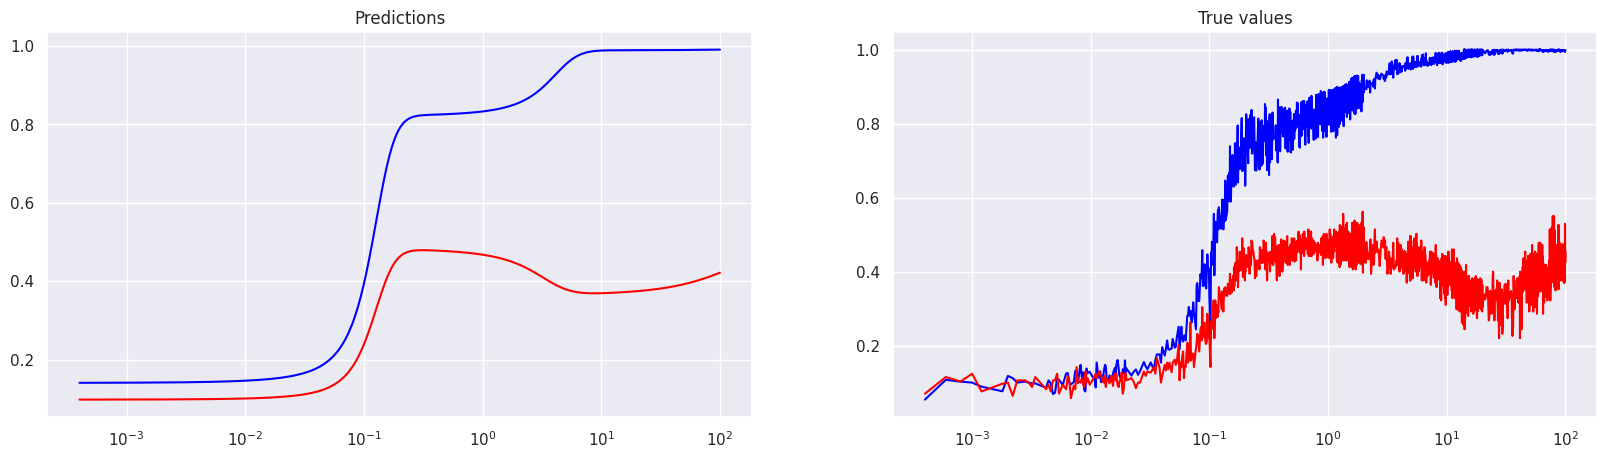

Epoch 301 - loss: 0.002789599820971489
Epoch 302 - loss: 0.0027893169317394495
Epoch 303 - loss: 0.002789034740999341
Epoch 304 - loss: 0.002788752317428589
Epoch 305 - loss: 0.0027884701266884804
Epoch 306 - loss: 0.0027881874702870846
Epoch 307 - loss: 0.0027879055123776197
Epoch 308 - loss: 0.002787623554468155
Epoch 309 - loss: 0.0027873413637280464
Epoch 310 - loss: 0.0027870596386492252
Epoch 311 - loss: 0.0027867783792316914
Epoch 312 - loss: 0.002786496188491583
Epoch 313 - loss: 0.002786214929074049
Epoch 314 - loss: 0.002785933669656515
Epoch 315 - loss: 0.0027856521774083376
Epoch 316 - loss: 0.0027853711508214474
Epoch 317 - loss: 0.0027850898914039135
Epoch 318 - loss: 0.002784809097647667
Epoch 319 - loss: 0.0027845280710607767
Epoch 320 - loss: 0.002784247510135174
Epoch 321 - loss: 0.0027839667163789272
Epoch 322 - loss: 0.002783686388283968
Epoch 323 - loss: 0.0027834060601890087
Epoch 324 - loss: 0.0027831257320940495
Epoch 325 - loss: 0.0027828458696603775
Epoch 326 

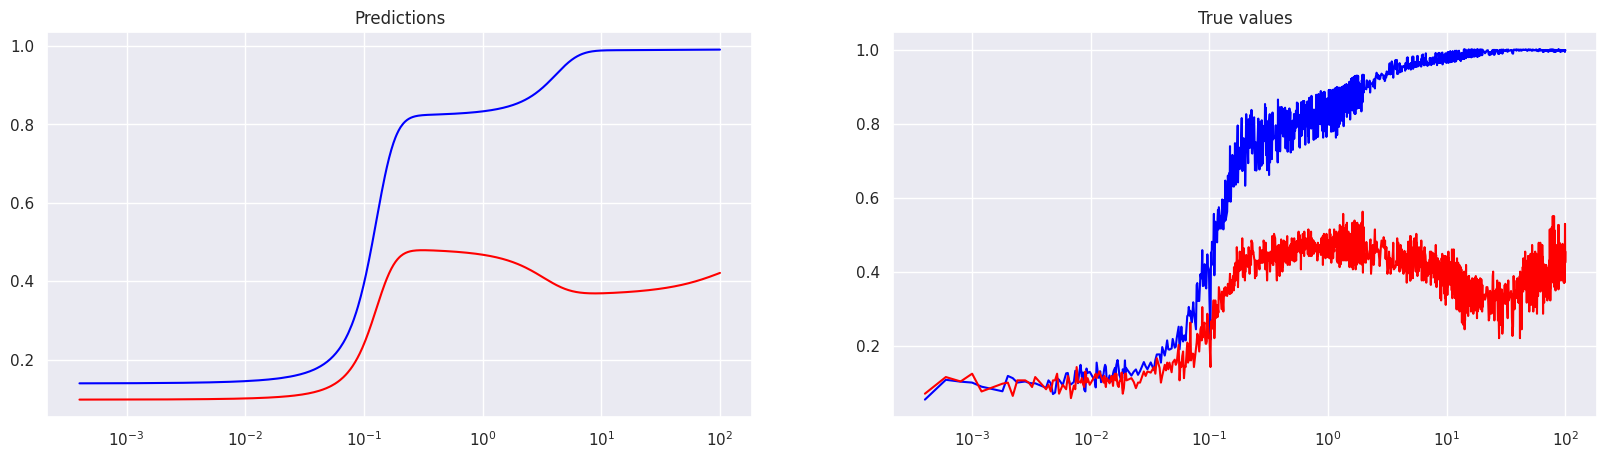

Epoch 351 - loss: 0.0027756080962717533
Epoch 352 - loss: 0.002775331027805805
Epoch 353 - loss: 0.0027750551234930754
Epoch 354 - loss: 0.0027747792191803455
Epoch 355 - loss: 0.002774503082036972
Epoch 356 - loss: 0.002774227410554886
Epoch 357 - loss: 0.0027739517390727997
Epoch 358 - loss: 0.0027736760675907135
Epoch 359 - loss: 0.0027734008617699146
Epoch 360 - loss: 0.002773125423118472
Epoch 361 - loss: 0.0027728506829589605
Epoch 362 - loss: 0.002772575942799449
Epoch 363 - loss: 0.0027723012026399374
Epoch 364 - loss: 0.0027720266953110695
Epoch 365 - loss: 0.002771751955151558
Epoch 366 - loss: 0.002771478146314621
Epoch 367 - loss: 0.0027712038718163967
Epoch 368 - loss: 0.0027709300629794598
Epoch 369 - loss: 0.00277065671980381
Epoch 370 - loss: 0.002770382910966873
Epoch 371 - loss: 0.0027701095677912235
Epoch 372 - loss: 0.0027698364574462175
Epoch 373 - loss: 0.0027695633471012115
Epoch 374 - loss: 0.0027692909352481365
Epoch 375 - loss: 0.002769018057733774
Epoch 376 -

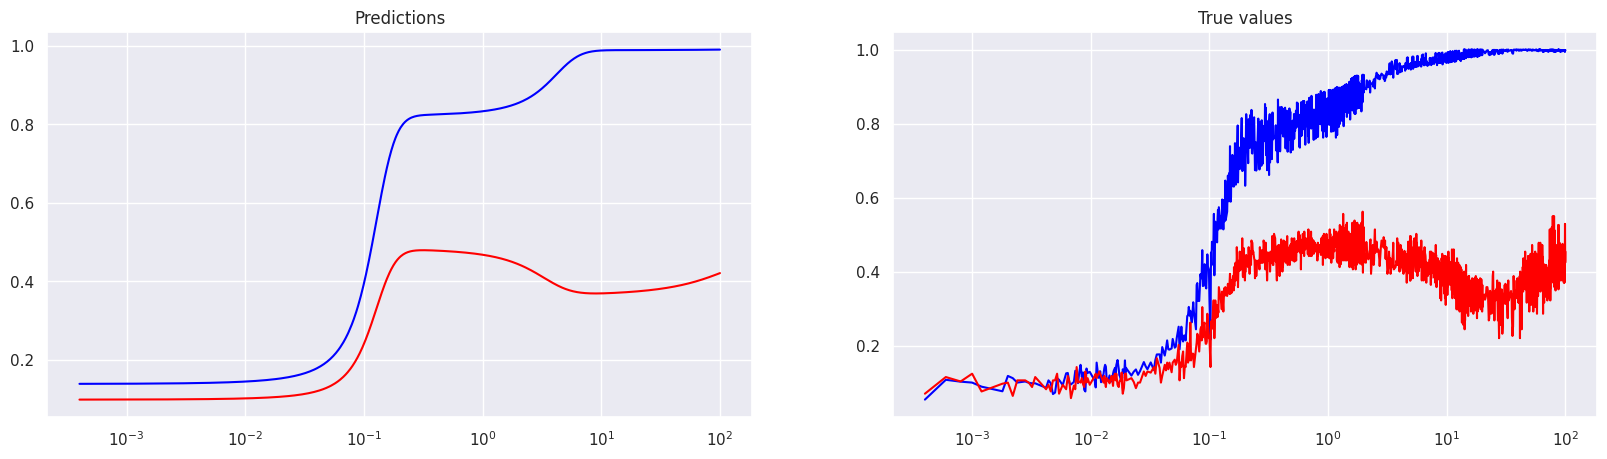

Epoch 401 - loss: 0.0027619958855211735
Epoch 402 - loss: 0.002761728595942259
Epoch 403 - loss: 0.002761461539193988
Epoch 404 - loss: 0.002761194249615073
Epoch 405 - loss: 0.002760927192866802
Epoch 406 - loss: 0.002760660834610462
Epoch 407 - loss: 0.002760394476354122
Epoch 408 - loss: 0.002760128118097782
Epoch 409 - loss: 0.0027598622255027294
Epoch 410 - loss: 0.0027595963329076767
Epoch 411 - loss: 0.002759330440312624
Epoch 412 - loss: 0.0027590650133788586
Epoch 413 - loss: 0.0027588000521063805
Epoch 414 - loss: 0.0027585348580032587
Epoch 415 - loss: 0.0027582701295614243
Epoch 416 - loss: 0.002758005866780877
Epoch 417 - loss: 0.00275774160400033
Epoch 418 - loss: 0.002757477341219783
Epoch 419 - loss: 0.002757213544100523
Epoch 420 - loss: 0.0027569495141506195
Epoch 421 - loss: 0.0027566864155232906
Epoch 422 - loss: 0.0027564228512346745
Epoch 423 - loss: 0.0027561599854379892
Epoch 424 - loss: 0.0027558973524719477
Epoch 425 - loss: 0.0027556344866752625
Epoch 426 - l

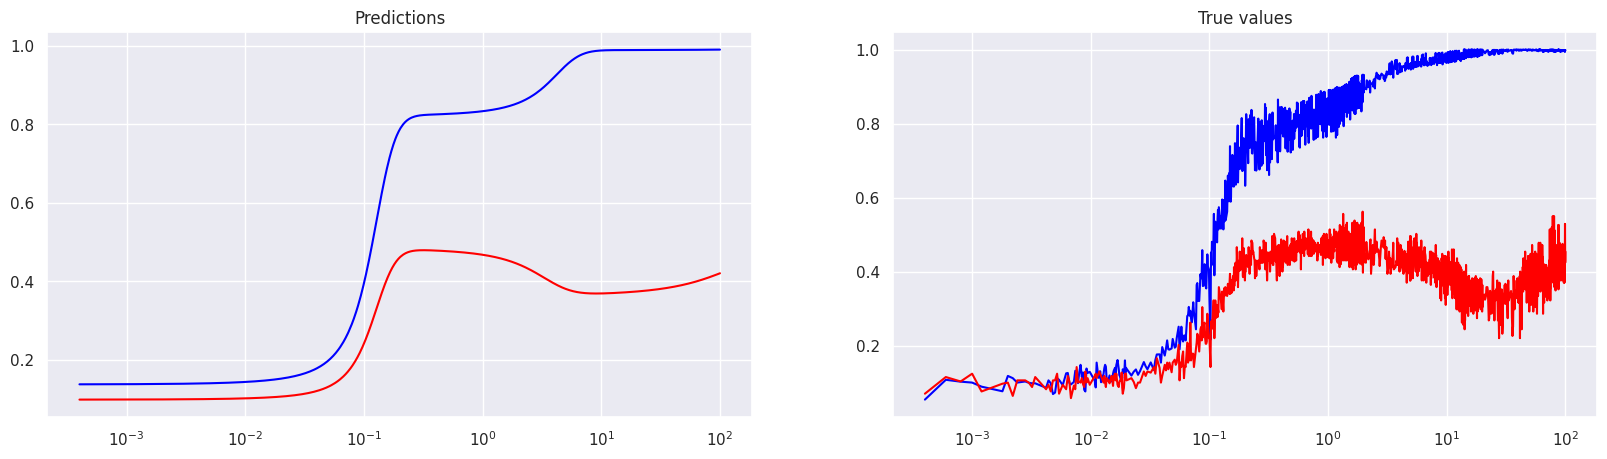

Epoch 451 - loss: 0.002748886588960886
Epoch 452 - loss: 0.0027486300095915794
Epoch 453 - loss: 0.00274837389588356
Epoch 454 - loss: 0.002748117782175541
Epoch 455 - loss: 0.0027478623669594526
Epoch 456 - loss: 0.0027476069517433643
Epoch 457 - loss: 0.0027473517693579197
Epoch 458 - loss: 0.002747096586972475
Epoch 459 - loss: 0.0027468418702483177
Epoch 460 - loss: 0.0027465871535241604
Epoch 461 - loss: 0.0027463333681225777
Epoch 462 - loss: 0.0027460791170597076
Epoch 463 - loss: 0.002745825331658125
Epoch 464 - loss: 0.002745571779087186
Epoch 465 - loss: 0.002745318226516247
Epoch 466 - loss: 0.0027450653724372387
Epoch 467 - loss: 0.0027448125183582306
Epoch 468 - loss: 0.0027445596642792225
Epoch 469 - loss: 0.0027443075086921453
Epoch 470 - loss: 0.002744055353105068
Epoch 471 - loss: 0.0027438034303486347
Epoch 472 - loss: 0.002743552206084132
Epoch 473 - loss: 0.0027433005161583424
Epoch 474 - loss: 0.0027430495247244835
Epoch 475 - loss: 0.0027427985332906246
Epoch 476 

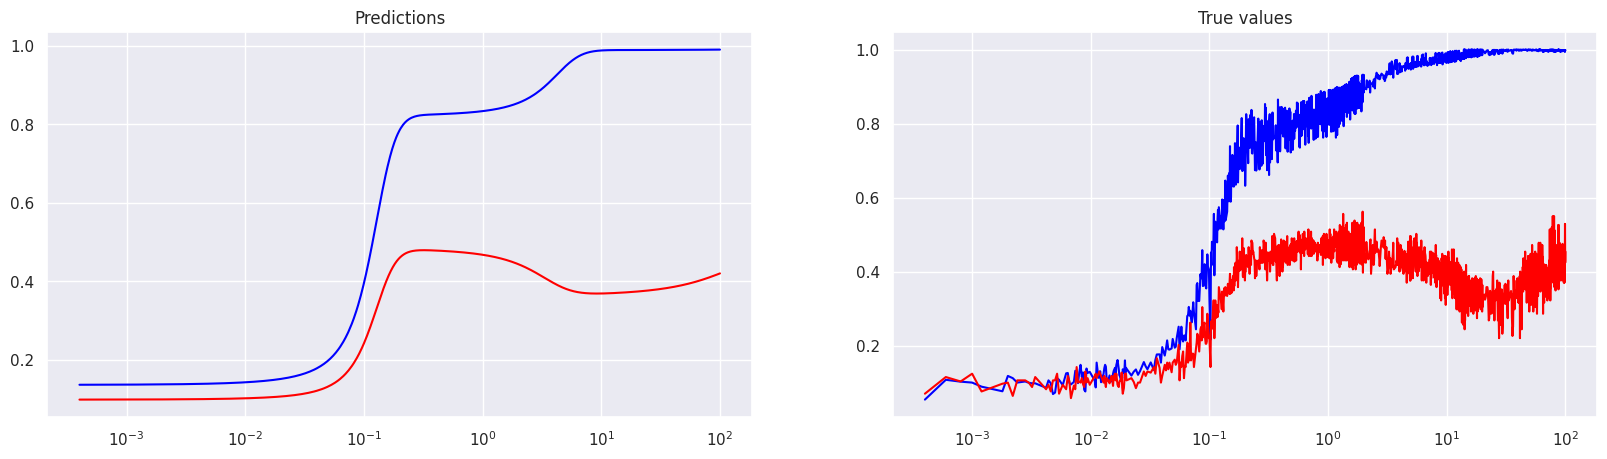

KeyboardInterrupt: 

In [197]:
print(model.patterns)
model.fit(rescaled_run, lr=0.01, num_epochs=1000, callback=callback, callback_ivl=50)

In [198]:
import pickle

with open("dd_fit.pkl", "wb") as f:
    pickle.dump(model, f)

model.patterns

ModuleList(
  (0): Pattern(strength=0.797573447227478, speed=33.066524505615234, onset=0.11366086453199387, generalization=0.564834475517273)
  (1): Pattern(strength=0.945742666721344, speed=0.7722194194793701, onset=3.430257797241211, generalization=0.13637502491474152)
  (2): Pattern(strength=0.25517624616622925, speed=0.018408609554171562, onset=62.154335021972656, generalization=1.3642507791519165)
)

In [216]:
# Investigate how local the minimum is

model.patterns[1].onset.data *= 2
model.patterns[1].speed.data /= 2.

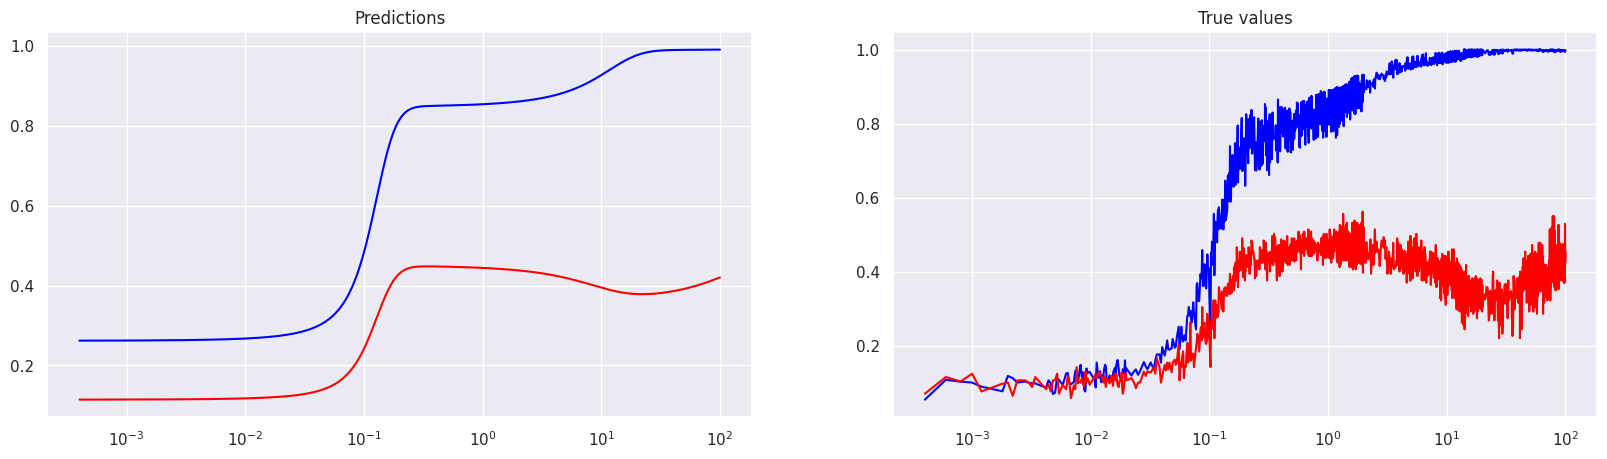

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 - loss: 0.005012889858335257


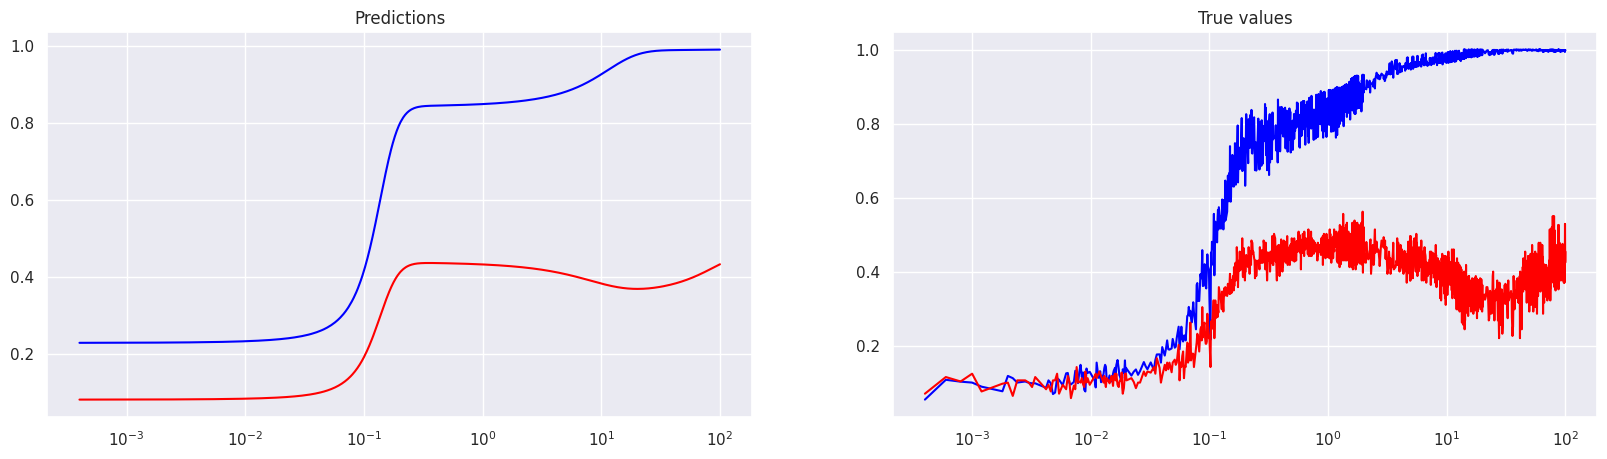

Epoch 1 - loss: 0.004540164023637772
Epoch 2 - loss: 0.004292404279112816
Epoch 3 - loss: 0.004063839558511972
Epoch 4 - loss: 0.004011875484138727
Epoch 5 - loss: 0.0039092921651899815
Epoch 6 - loss: 0.00370405288413167
Epoch 7 - loss: 0.0035486221313476562
Epoch 8 - loss: 0.0034616789780557156
Epoch 9 - loss: 0.0034076408483088017
Epoch 10 - loss: 0.0033698002807796
Epoch 11 - loss: 0.0033383634872734547
Epoch 12 - loss: 0.0032997759990394115
Epoch 13 - loss: 0.0032491255551576614
Epoch 14 - loss: 0.0031957284081727266
Epoch 15 - loss: 0.003154001198709011
Epoch 16 - loss: 0.003132440848276019
Epoch 17 - loss: 0.0031272531487047672
Epoch 18 - loss: 0.003124874085187912
Epoch 19 - loss: 0.0031133759766817093
Epoch 20 - loss: 0.0030916365794837475
Epoch 21 - loss: 0.0030675753951072693
Epoch 22 - loss: 0.0030497917905449867
Epoch 23 - loss: 0.003041232470422983
Epoch 24 - loss: 0.0030390445608645678
Epoch 25 - loss: 0.0030383325647562742
Epoch 26 - loss: 0.003035162575542927
Epoch 27 

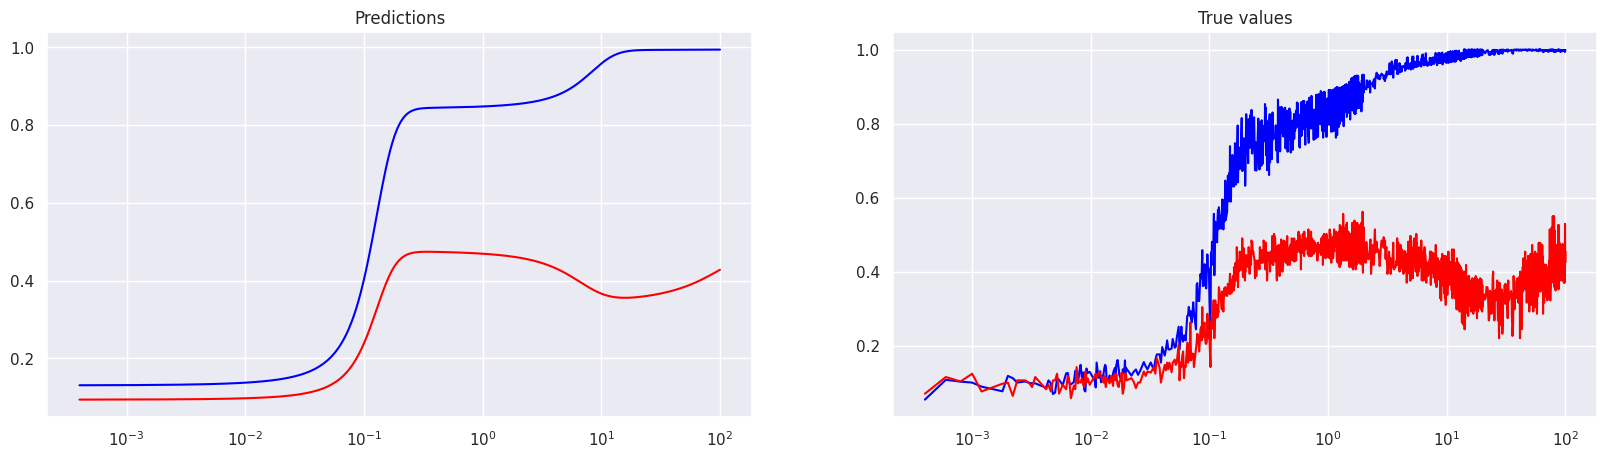

Epoch 51 - loss: 0.002908911556005478
Epoch 52 - loss: 0.0029064174741506577
Epoch 53 - loss: 0.0029036314226686954
Epoch 54 - loss: 0.0029010246507823467
Epoch 55 - loss: 0.002898538950830698
Epoch 56 - loss: 0.0028967743273824453
Epoch 57 - loss: 0.002895181765779853
Epoch 58 - loss: 0.002893189899623394
Epoch 59 - loss: 0.0028912280686199665
Epoch 60 - loss: 0.002889140509068966
Epoch 61 - loss: 0.0028873856645077467
Epoch 62 - loss: 0.0028860492166131735
Epoch 63 - loss: 0.0028846326749771833
Epoch 64 - loss: 0.002883280860260129
Epoch 65 - loss: 0.0028817562852054834
Epoch 66 - loss: 0.0028803544119000435
Epoch 67 - loss: 0.0028792002703994513
Epoch 68 - loss: 0.002878085244446993
Epoch 69 - loss: 0.0028770603239536285
Epoch 70 - loss: 0.0028758402913808823
Epoch 71 - loss: 0.0028746563475579023
Epoch 72 - loss: 0.002873496152460575
Epoch 73 - loss: 0.002872435376048088
Epoch 74 - loss: 0.0028714146465063095
Epoch 75 - loss: 0.0028703054413199425
Epoch 76 - loss: 0.002869196701794

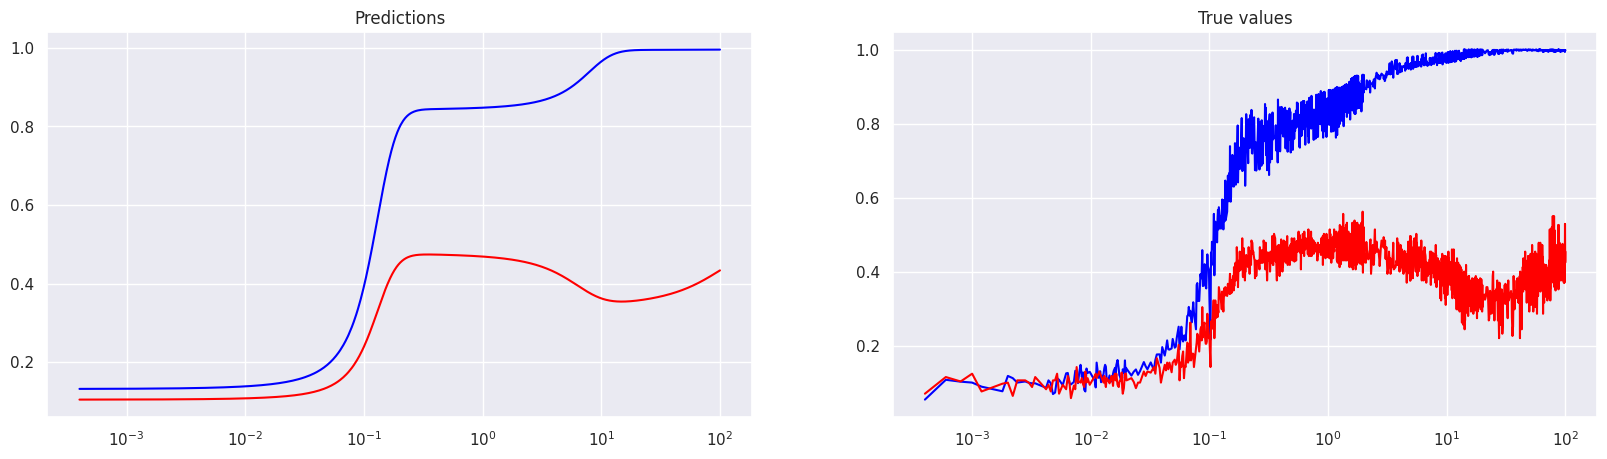

Epoch 101 - loss: 0.0028459972236305475
Epoch 102 - loss: 0.0028451529797166586
Epoch 103 - loss: 0.00284431385807693
Epoch 104 - loss: 0.002843479160219431
Epoch 105 - loss: 0.0028426500502973795
Epoch 106 - loss: 0.00284181977622211
Epoch 107 - loss: 0.002840990200638771
Epoch 108 - loss: 0.0028401631861925125
Epoch 109 - loss: 0.0028393426910042763
Epoch 110 - loss: 0.002838524989783764
Epoch 111 - loss: 0.0028377098497003317
Epoch 112 - loss: 0.002836894942447543
Epoch 113 - loss: 0.0028360839933156967
Epoch 114 - loss: 0.0028352770023047924
Epoch 115 - loss: 0.0028344732709228992
Epoch 116 - loss: 0.0028336704708635807
Epoch 117 - loss: 0.0028328702319413424
Epoch 118 - loss: 0.0028320723213255405
Epoch 119 - loss: 0.0028312793001532555
Epoch 120 - loss: 0.002830487908795476
Epoch 121 - loss: 0.0028296993114054203
Epoch 122 - loss: 0.0028289123438298702
Epoch 123 - loss: 0.002828129567205906
Epoch 124 - loss: 0.0028273495845496655
Epoch 125 - loss: 0.002826572395861149
Epoch 126 -

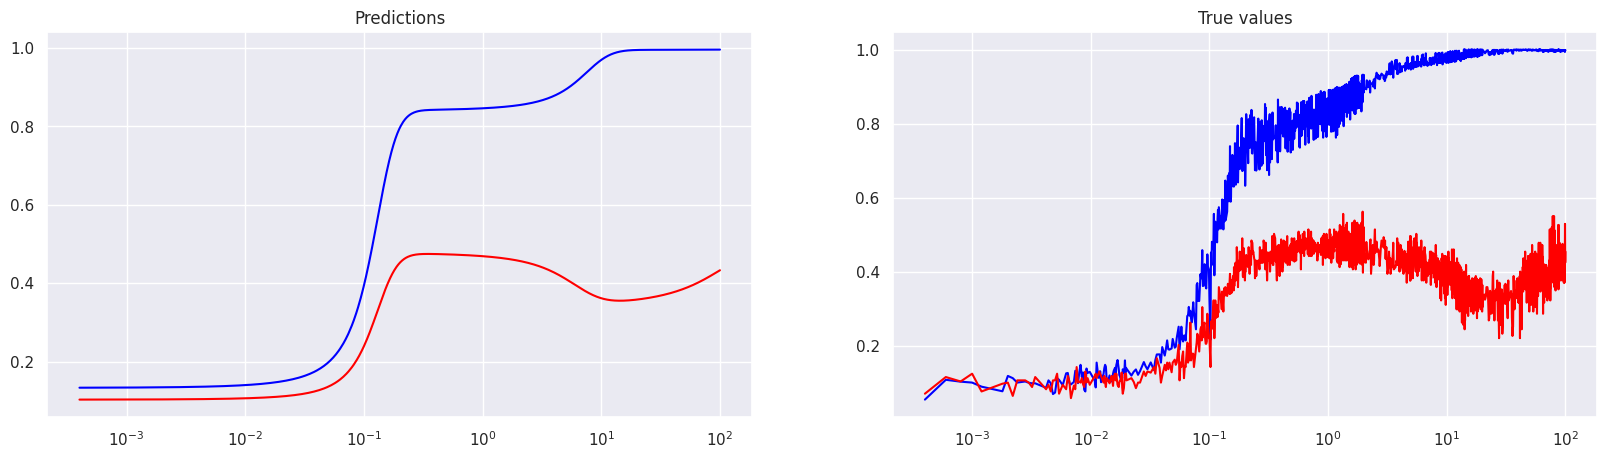

Epoch 151 - loss: 0.0028072483837604523
Epoch 152 - loss: 0.002806538250297308
Epoch 153 - loss: 0.002805829979479313
Epoch 154 - loss: 0.002805124968290329
Epoch 155 - loss: 0.0028044215869158506
Epoch 156 - loss: 0.002803720999509096
Epoch 157 - loss: 0.0028030220419168472
Epoch 158 - loss: 0.0028023263439536095
Epoch 159 - loss: 0.0028016320429742336
Epoch 160 - loss: 0.0028009407687932253
Epoch 161 - loss: 0.00280025159008801
Epoch 162 - loss: 0.0027995640411973
Epoch 163 - loss: 0.0027988795191049576
Epoch 164 - loss: 0.0027981966268271208
Epoch 165 - loss: 0.002797516528517008
Epoch 166 - loss: 0.0027968385256826878
Epoch 167 - loss: 0.0027961628511548042
Epoch 168 - loss: 0.0027954895049333572
Epoch 169 - loss: 0.0027948180213570595
Epoch 170 - loss: 0.002794149098917842
Epoch 171 - loss: 0.0027934822719544172
Epoch 172 - loss: 0.0027928173076361418
Epoch 173 - loss: 0.00279215513728559
Epoch 174 - loss: 0.0027914950624108315
Epoch 175 - loss: 0.002790836850181222
Epoch 176 - lo

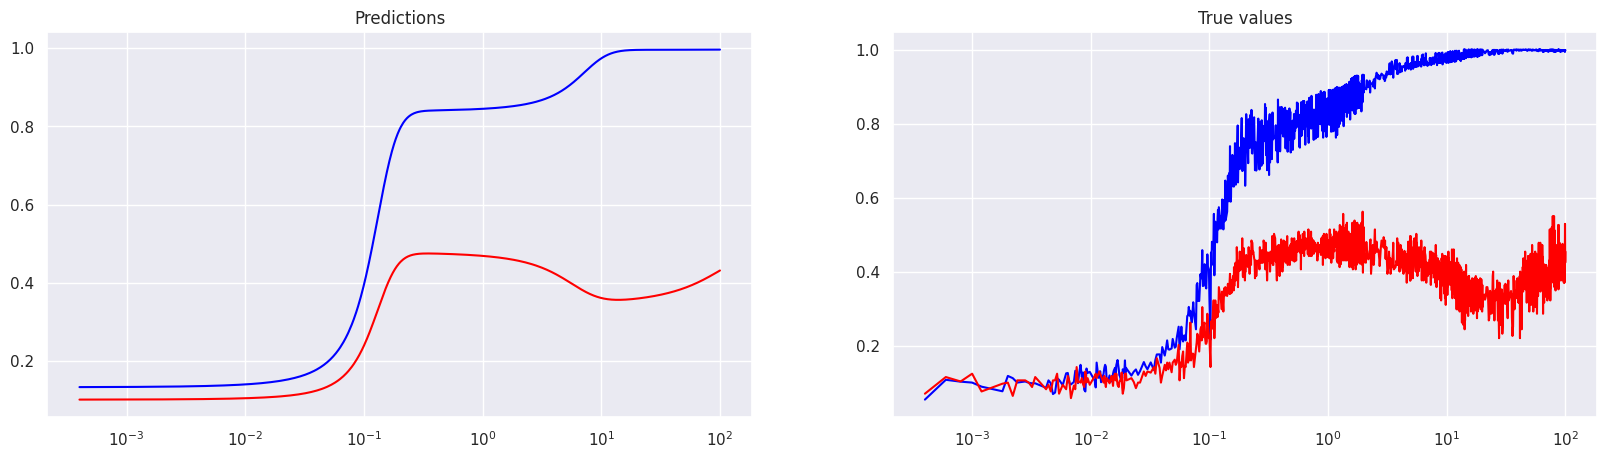

Epoch 201 - loss: 0.002774476073682308
Epoch 202 - loss: 0.002773874904960394
Epoch 203 - loss: 0.0027732758317142725
Epoch 204 - loss: 0.002772678155452013
Epoch 205 - loss: 0.0027720830403268337
Epoch 206 - loss: 0.002771490253508091
Epoch 207 - loss: 0.002770899096503854
Epoch 208 - loss: 0.002770310267806053
Epoch 209 - loss: 0.0027697228360921144
Epoch 210 - loss: 0.0027691377326846123
Epoch 211 - loss: 0.002768554724752903
Epoch 212 - loss: 0.002767973579466343
Epoch 213 - loss: 0.002767394296824932
Epoch 214 - loss: 0.0027668168768286705
Epoch 215 - loss: 0.002766241319477558
Epoch 216 - loss: 0.002765668323263526
Epoch 217 - loss: 0.0027650967240333557
Epoch 218 - loss: 0.0027645272202789783
Epoch 219 - loss: 0.0027639600448310375
Epoch 220 - loss: 0.0027633942663669586
Epoch 221 - loss: 0.0027628308162093163
Epoch 222 - loss: 0.002762268763035536
Epoch 223 - loss: 0.002761709038168192
Epoch 224 - loss: 0.0027611509431153536
Epoch 225 - loss: 0.0027605954091995955
Epoch 226 - l

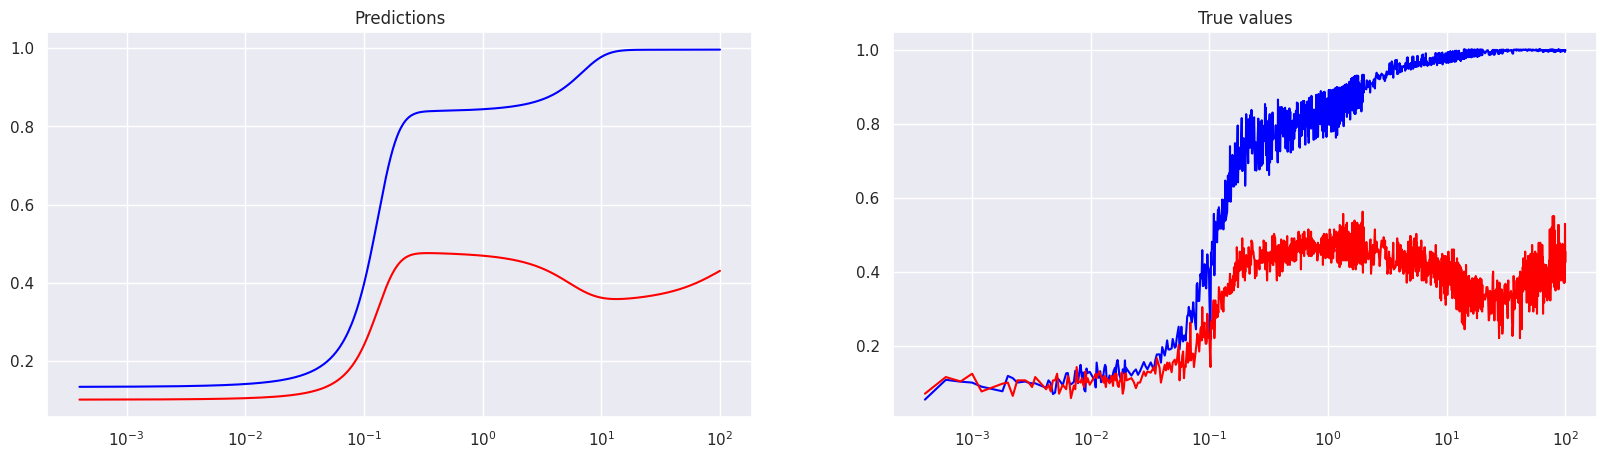

Epoch 251 - loss: 0.002746790647506714
Epoch 252 - loss: 0.002746284008026123
Epoch 253 - loss: 0.002745778998360038
Epoch 254 - loss: 0.002745276317000389
Epoch 255 - loss: 0.002744774566963315
Epoch 256 - loss: 0.0027442751452326775
Epoch 257 - loss: 0.002743777120485902
Epoch 258 - loss: 0.0027432809583842754
Epoch 259 - loss: 0.0027427866589277983
Epoch 260 - loss: 0.0027422939892858267
Epoch 261 - loss: 0.0027418029494583607
Epoch 262 - loss: 0.0027413135394454002
Epoch 263 - loss: 0.002740825992077589
Epoch 264 - loss: 0.002740340307354927
Epoch 265 - loss: 0.002739856019616127
Epoch 266 - loss: 0.0027393733616918325
Epoch 267 - loss: 0.0027388925664126873
Epoch 268 - loss: 0.0027384136337786913
Epoch 269 - loss: 0.0027379358652979136
Epoch 270 - loss: 0.002737459959462285
Epoch 271 - loss: 0.002736985683441162
Epoch 272 - loss: 0.0027365132700651884
Epoch 273 - loss: 0.0027360422536730766
Epoch 274 - loss: 0.002735573099926114
Epoch 275 - loss: 0.002735105575993657
Epoch 276 - l

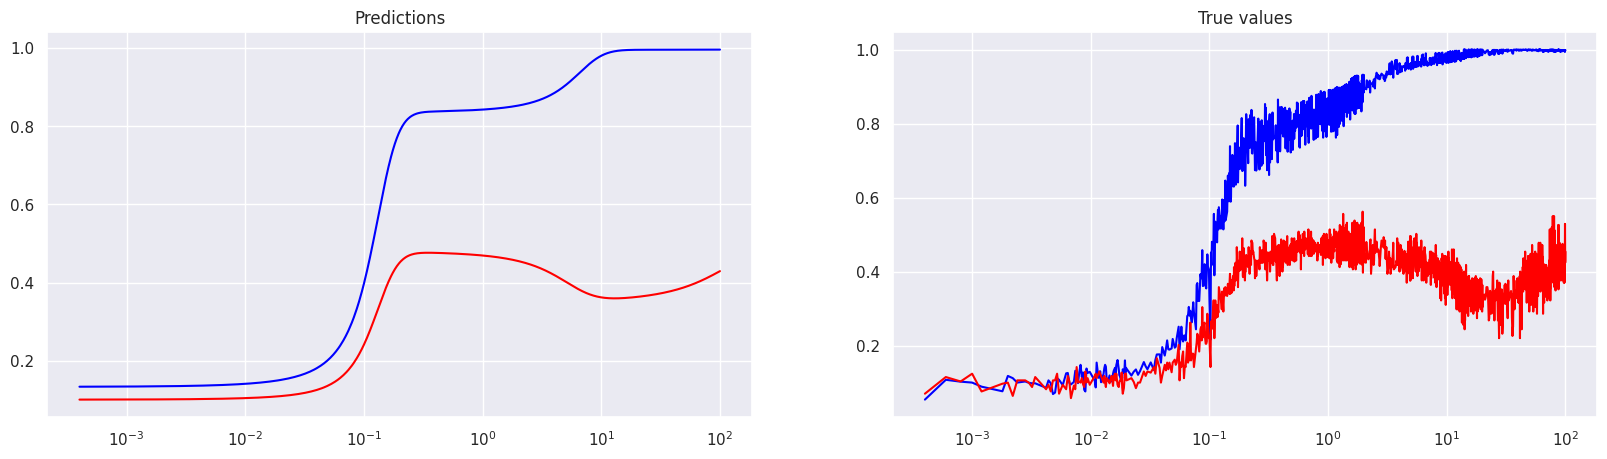

Epoch 301 - loss: 0.002723502926528454
Epoch 302 - loss: 0.0027230773121118546
Epoch 303 - loss: 0.0027226535603404045
Epoch 304 - loss: 0.002722230739891529
Epoch 305 - loss: 0.0027218095492571592
Epoch 306 - loss: 0.0027213902212679386
Epoch 307 - loss: 0.002720971591770649
Epoch 308 - loss: 0.002720555290579796
Epoch 309 - loss: 0.0027201399207115173
Epoch 310 - loss: 0.0027197259478271008
Epoch 311 - loss: 0.0027193136047571898
Epoch 312 - loss: 0.0027189026586711407
Epoch 313 - loss: 0.002718493342399597
Epoch 314 - loss: 0.0027180849574506283
Epoch 315 - loss: 0.0027176784351468086
Epoch 316 - loss: 0.0027172730769962072
Epoch 317 - loss: 0.0027168693486601114
Epoch 318 - loss: 0.002716466784477234
Epoch 319 - loss: 0.002716065850108862
Epoch 320 - loss: 0.002715666312724352
Epoch 321 - loss: 0.00271526793949306
Epoch 322 - loss: 0.002714871196076274
Epoch 323 - loss: 0.0027144753839820623
Epoch 324 - loss: 0.0027140812017023563
Epoch 325 - loss: 0.002713688649237156
Epoch 326 - 

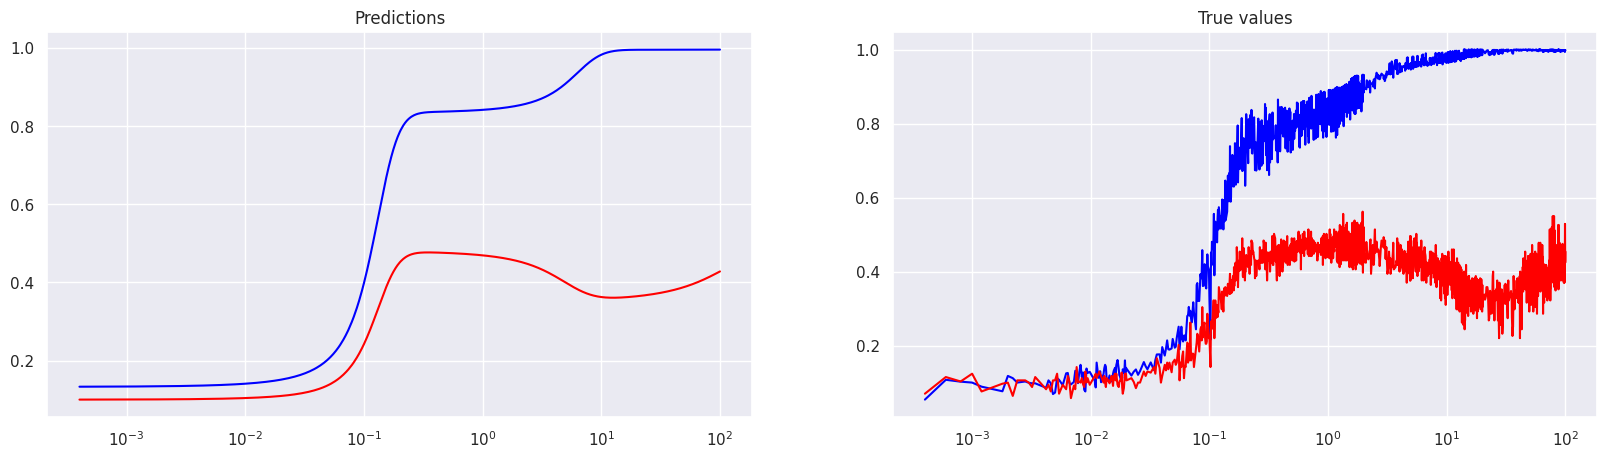

Epoch 351 - loss: 0.002703937701880932
Epoch 352 - loss: 0.002703579841181636
Epoch 353 - loss: 0.002703223144635558
Epoch 354 - loss: 0.0027028676122426987
Epoch 355 - loss: 0.002702513476833701
Epoch 356 - loss: 0.0027021607384085655
Epoch 357 - loss: 0.0027018082328140736
Epoch 358 - loss: 0.002701457589864731


KeyboardInterrupt: 

In [201]:
model.fit(rescaled_run, lr=0.01, num_epochs=500, callback=callback, callback_ivl=50)

In [202]:
import pickle

with open("dd_fit.pkl", "wb") as f:
    pickle.dump(model, f)

model.patterns

ModuleList(
  (0): Pattern(strength=0.8138683438301086, speed=29.97869873046875, onset=0.11406392604112625, generalization=0.5456590056419373)
  (1): Pattern(strength=0.9782488346099854, speed=0.5074016451835632, onset=4.952835559844971, generalization=0.12456056475639343)
  (2): Pattern(strength=0.18264204263687134, speed=0.02067597210407257, onset=62.871578216552734, generalization=2.0634448528289795)
)

In [79]:
model.rescale(500_000) 
model.patterns

ModuleList(
  (0): Pattern(strength=0.8598001003265381, speed=24.121509552001953, onset=0.10115106403827667, generalization=0.5016812682151794)
  (1): Pattern(strength=0.9492841958999634, speed=1.7669602632522583, onset=2.1641852855682373, generalization=0.1769353449344635)
  (2): Pattern(strength=0.33629870414733887, speed=0.04316259175539017, onset=48.40985107421875, generalization=1.7254242897033691)
)

/home/paperspace/Projects/quanta-learning/.venv/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/tmp/ipykernel_4071/687688425.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["$10^0$", "$10^1$", "$10^2$", "$10^3$", "$10^4$", "$10^5$"])


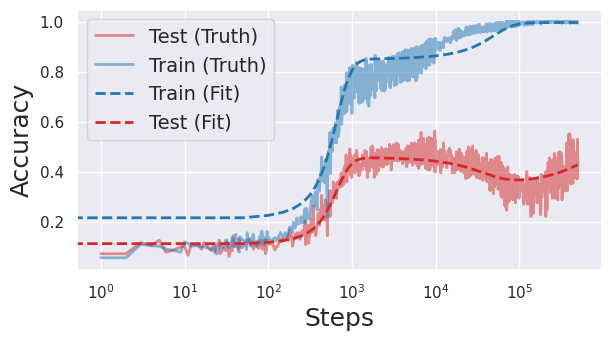

In [217]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

ax.plot(run["_step"], run["test/acc"], label="Test (Truth)", color=RED, linewidth=2, alpha=0.5)
ax.plot(run["_step"], run["train/acc"], label="Train (Truth)", color=BLUE, linewidth=2, alpha=0.5)
ax.set_ylabel("Accuracy", fontsize=18)
# ax.set_xlabel("Steps", fontsize=18)
# ax.set_xticklabels(["", "", "", "", "", ""], color="white")

min_, max_ = 0, 100
ts = torch.linspace(min_, max_, 10000)
TS = ts * 500_000 / 100
train_ys = [model(t).detach().numpy() for t in ts]
test_ys = [model.test(t).detach().numpy() for t in ts]
ax.plot(TS, train_ys, label="Train (Fit)", color=BLUE, linewidth=2, linestyle="--")
ax.plot(TS, test_ys, label="Test (Fit)", color=RED, linewidth=2, linestyle="--")
# ax.set_title("Fit", )
ax.legend(fontsize=14)

ax.set_xticklabels(["$10^0$", "$10^1$", "$10^2$", "$10^3$", "$10^4$", "$10^5$"])
# ax.set_xlim(10, 100)
ax.set_xscale("log")
# ax.set_xticks([0.01, 0.1, 1, 10, 100])

fig.tight_layout(pad=0.25)
ax.set_xlabel("Steps", fontsize=18)


# Already in log scale
# train_ys, test_ys

plt.savefig("../figures/dd-fit.pdf", bbox_inches="tight")

# Fit the sweeps

In [12]:
api = wandb.Api()
runs = api.runs(f"jqhoogland/fit-toy-model")
[run for run in runs]

[<Run jqhoogland/fit-toy-model/adwkvhjw (running)>,
 <Run jqhoogland/fit-toy-model/n35nig8t (running)>,
 <Run jqhoogland/fit-toy-model/qc4itmz1 (running)>,
 <Run jqhoogland/fit-toy-model/0v1thdzj (finished)>,
 <Run jqhoogland/fit-toy-model/1gthqqg5 (finished)>,
 <Run jqhoogland/fit-toy-model/5s56iliv (crashed)>]

In [28]:
mw_fit_run_id = "1gthqq5"
run = runs[2]
df = run.history()

col = "d_model"
unique_vals = df.loc[:, col].unique()
print(unique_vals)
df

[  1   2   3   4   5   6   8   9  11  14  17  20  25  30  37  44  54  65
  79  95 115 140 169 205 248 300]


pattern_0/onset  _step  modulus   log  pattern_1/speed  d_vocab   
0       1586.732178      0      113  True        -0.006830      114  \
1       1062.660767      1      113  True        -0.006865      114   
2       1223.991821      2      113  True        -0.006661      114   
3       1343.376587      3      113  True        -0.007134      114   
4       1485.789429      4      113  True        -0.006551      114   
5       1435.536377      5      113  True        -0.004474      114   
6       1208.405396      6      113  True        -0.006050      114   
7       1379.252686      7      113  True        -0.006602      114   
8       2736.685059      8      113  True         0.005848      114   
9       2740.774902      9      113  True         0.007786      114   
10      1540.739868     10      113  True         0.001078      114   
11      2812.603271     11      113  True         0.001943      114   
12      2792.589111     12      113  True         0.008985      114   
13      2778.623047     13      113  True         0.002927      114   
14      2931.515625     14      113  True         0.002506      114   
15      3250.532715     15      113  True         0.002387      114   
16      2882.756592     16      113  True         0.002416      114   
17      3020.263184     17      113  True         0.002451      114   
18      3047.846436     18      113  True         0.003404      114   
19      2933.126221     19      113  True         0.006027      114   
20      3307.669922     20      113  True         0.007610      114   
21      3381.428955     21      113  True         0.009970      114   
22      3047.957275     22      113  True         0.006230      114   
23      3620.579346     23      113  True         0.011217      114   
24      3296.354736     24      113  True         0.007823      114   
25      3412.167480     25      113  True         0.009108      114   

    num_training_steps  weight_decay  _runtime     sweep  ...  frac_train   
0               100000           0.3  2.410218  l1b2mmci  ...         0.4  \
1               100000           0.3  2.410218  l1b2mmci  ...         0.4   
2               100000           0.3  2.410218  l1b2mmci  ...         0.4   
3               100000           0.3  2.410218  l1b2mmci  ...         0.4   
4               100000           0.3  2.410218  l1b2mmci  ...         0.4   
5               100000           0.3  2.410218  l1b2mmci  ...         0.4   
6               100000           0.3  2.410218  l1b2mmci  ...         0.4   
7               100000           0.3  2.410218  l1b2mmci  ...         0.4   
8               100000           0.3  2.410218  l1b2mmci  ...         0.4   
9               100000           0.3  2.410218  l1b2mmci  ...         0.4   
10              100000           0.3  2.410218  l1b2mmci  ...         0.4   
11              100000           0.3  2.410218  l1b2mmci  ...         0.4   
12              100000           0.3  2.410218  l1b2mmci  ...         0.4   
13              100000           0.3  2.410218  l1b2mmci  ...         0.4   
14              100000           0.3  2.410218  l1b2mmci  ...         0.4   
15              100000           0.3  2.410218  l1b2mmci  ...         0.4   
16              100000           0.3  2.410218  l1b2mmci  ...         0.4   
17              100000           0.3  2.410218  l1b2mmci  ...         0.4   
18              100000           0.3  2.410218  l1b2mmci  ...         0.4   
19              100000           0.3  2.410218  l1b2mmci  ...         0.4   
20              100000           0.3  2.410218  l1b2mmci  ...         0.4   
21              100000           0.3  2.410218  l1b2mmci  ...         0.4   
22              100000           0.3  2.410218  l1b2mmci  ...         0.4   
23              100000           0.3  2.410218  l1b2mmci  ...         0.4   
24              100000           0.3  2.410218  l1b2mmci  ...         0.4   
25              100000           0.3  2.410218  l1b2mmci  ...         0.4   

    pa

In [35]:
def df_row_to_toy_model(row):
    model = PatternLearningModel(max_time=1.)

    for i, pattern in enumerate(model.patterns):
        pattern.onset.data = torch.tensor(row[f"pattern_{i}/onset"])
        pattern.speed.data = torch.tensor(row[f"pattern_{i}/speed"])
        pattern._strength.data = pattern._inv_sigmoid(torch.tensor(row[f"pattern_{i}/strength"]))  # type: ignore
        pattern._generalization.data = torch.log(torch.tensor(row[f"pattern_{i}/generalization"]))

    return model

D_MODEL = 115
co9l = "d_model"
model_entry = df.loc[df[col] == D_MODEL, :].iloc[0, :]
print(model_entry)
model = df_row_to_toy_model(model_entry)
model.rescale(100)
model.patterns

pattern_0/onset                   3307.669922
_step                                      20
modulus                                   113
log                                      True
pattern_1/speed                       0.00761
d_vocab                                   114
num_training_steps                     100000
weight_decay                              0.3
_runtime                             2.410218
sweep                                l1b2mmci
pattern_1/onset                   4938.347168
lr                                      0.001
seed                                        0
pattern_1/generalization             0.701577
pattern_2/generalization             6.939834
num_layers                                  1
log_interval                               10
pattern_1/strength                     0.9862
pattern_0/strength                   0.077263
pattern_0/speed                      0.004219
d_model                                   115
pattern_2/strength                

/home/paperspace/Projects/quanta-learning/.venv/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


ModuleList(
  (0): Pattern(strength=0.0772629827260971, speed=0.4218541085720062, onset=33.076698303222656, generalization=0.014402443543076515)
  (1): Pattern(strength=0.9861999750137329, speed=0.760972797870636, onset=49.38347244262695, generalization=0.7015765905380249)
  (2): Pattern(strength=0.9925130605697632, speed=0.5755707621574402, onset=75.50422668457031, generalization=6.939833641052246)
)

In [37]:
# Get corresponding original run
og_df = get_history(DM_SWEEP_ID, unique_cols="d_model")
run = og_df.loc[og_df.d_model==D_MODEL,:] #.plot(x="_step", y="test/acc")

/tmp/ipykernel_39642/2223921967.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(["", "", "", "", "", ""], color="white")
/home/paperspace/Projects/quanta-learning/.venv/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/tmp/ipykernel_39642/2223921967.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(["$10^0$", "$10^1$", "$10^2$", "$10^3$", "$10^4$", "$10^5$"])


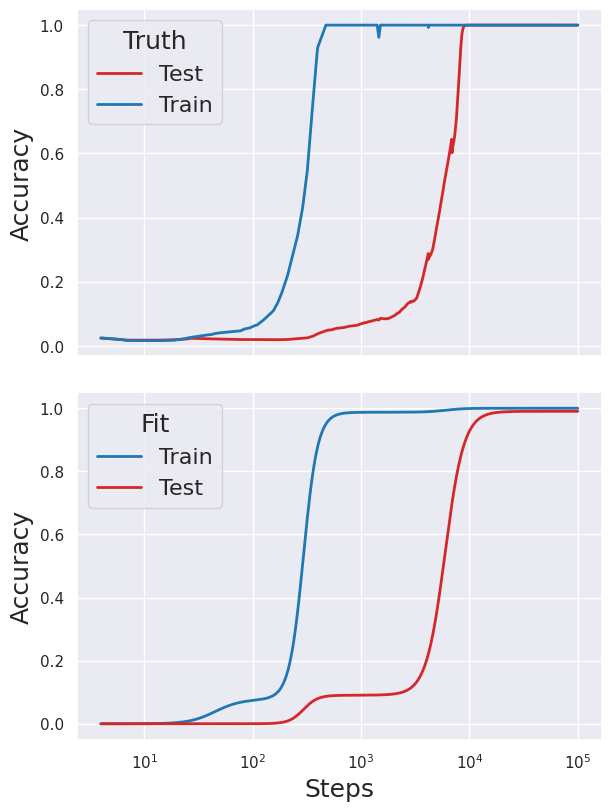

In [65]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

ax1.plot(run["_step"], run["test/acc"], label="Test", color=RED, linewidth=2)
ax1.plot(run["_step"], run["train/acc"], label="Train", color=BLUE, linewidth=2)
ax1.set_ylabel("Accuracy", fontsize=18)
# ax1.set_xlabel("Steps", fontsize=18)
ax1.set_xticklabels(["", "", "", "", "", ""], color="white")
ax1.set_xscale("log")
ax1.legend(title="Truth", fontsize=16, title_fontsize=18)

min_step, max_step = og_df["_step"].min(), 100 # run["_step"].max()

ts = np.linspace(12, max_step, 1000)
train_ys = [model(t).detach().numpy() for t in ts]
test_ys = [model.test(t).detach().numpy() for t in ts]
ax2.plot(ts, train_ys, label="Train", color=BLUE, linewidth=2)
ax2.plot(ts, test_ys, label="Test", color=RED, linewidth=2)
ax2.set_ylabel("Accuracy", fontsize=18)
ax2.set_xlabel("Steps", fontsize=18)
# ax2.set_title("Fit", )
ax2.legend(title="Fit", fontsize=16, title_fontsize=18)

ax2.set_xticklabels(["$10^0$", "$10^1$", "$10^2$", "$10^3$", "$10^4$", "$10^5$"])
# ax2.set_xlim(10, 100)

fig.tight_layout(pad=0.25)

# Already in log scale
# train_ys, test_ys

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

ax1.plot(run["_step"], run["test/acc"], label="Test", color=RED, linewidth=2)
ax1.plot(run["_step"], run["train/acc"], label="Train", color=BLUE, linewidth=2)
ax1.set_ylabel("Accuracy", fontsize=18)
# ax1.set_xlabel("Steps", fontsize=18)
ax1.set_xticklabels(["", "", "", "", "", ""], color="white")
ax1.set_xscale("log")
ax1.legend(title="Truth", fontsize=16, title_fontsize=18)

min_step, max_step = og_df["_step"].min(), 100 # run["_step"].max()

ts = np.linspace(12, max_step, 1000)
train_ys = [model(t).detach().numpy() for t in ts]
test_ys = [model.test(t).detach().numpy() for t in ts]
ax2.plot(ts, train_ys, label="Train", color=BLUE, linewidth=2)
ax2.plot(ts, test_ys, label="Test", color=RED, linewidth=2)
ax2.set_ylabel("Accuracy", fontsize=18)
ax2.set_xlabel("Steps", fontsize=18)
# ax2.set_title("Fit", )
ax2.legend(title="Fit", fontsize=16, title_fontsize=18)
ax2.set_xticklabels(["$10^0$", "$10^1$", "$10^2$", "$10^3$", "$10^4$", "$10^5$"])
# ax2.set_xlim(10, 100)

fig.tight_layout(pad=0.25)

# Already in log scale
# train_ys, test_ys

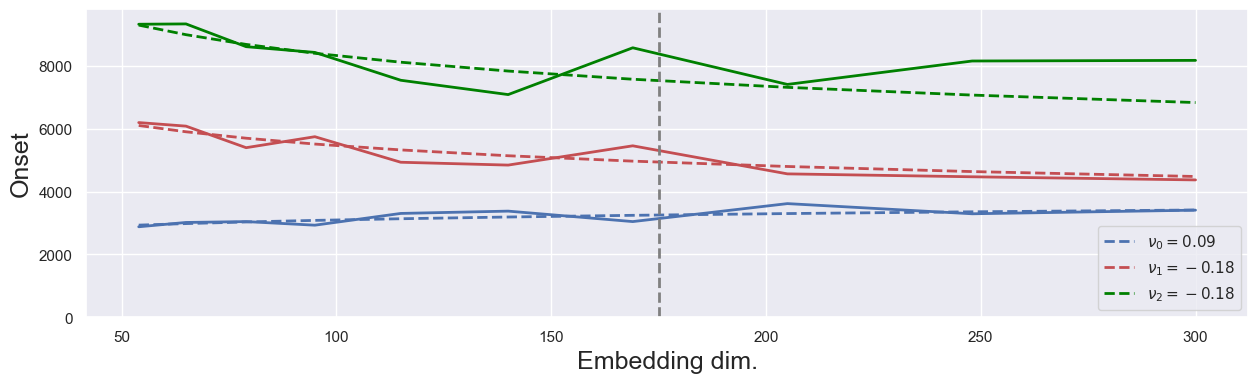

In [70]:
# Ignore any d_model < 50
df_cleaned = df.loc[df["d_model"] >= 50, :]
d_models = df_cleaned.loc[:, "d_model"].unique()

# Scaling analysis
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

colors = [BLUE, RED, "green"]
y_max = 0

for i in range(3):
    slice = df_cleaned.loc[:, f"pattern_{i}/onset"]
    y_max = max(y_max, slice.max())
    ax.plot(d_models, slice, label=f"", color=colors[i], linewidth=2)

ax.set_xlabel("d_model", fontsize=18)
ax.set_ylabel("Onset", fontsize=18)


# Fit a power-law to the onsets 
from scipy.optimize import curve_fit

def power_law(x, a, b):
    return a * x**b

def fit_power_law(x, y):
    popt, pcov = curve_fit(power_law, x, y)
    return popt


CUTOFF = 175

# Fit power law to onset
for i in range(3):
    # Train up to a specific point
    df_to_fit = df_cleaned.loc[df_cleaned["d_model"] <= CUTOFF, :]
    d_models_to_fit = df_to_fit.loc[:, "d_model"].unique()

    onset_popt = fit_power_law(d_models_to_fit, df_to_fit.loc[:, f"pattern_{i}/onset"])
    exponent = round(onset_popt[1], 2)
    ax.plot(d_models, power_law(d_models, *onset_popt), label=f"$\\nu_{i} = {exponent}$", color=colors[i], linestyle="--", linewidth=2)

ax.vlines(CUTOFF, 0, y_max * 1.05, color="grey", linestyle="--", linewidth=2)
ax.set_xlabel("Embedding dim.", fontsize=18)
ax.set_ylim(0, y_max * 1.05)

ax.legend()

/tmp/ipykernel_409543/540945436.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_to_decompose.sort_values(by="_step", inplace=True)
/tmp/ipykernel_409543/540945436.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_to_decompose["test/acc"] = gaussian_filter1d(run_to_decompose["test/acc"], sigma=15)
/tmp/ipykernel_409543/540945436.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

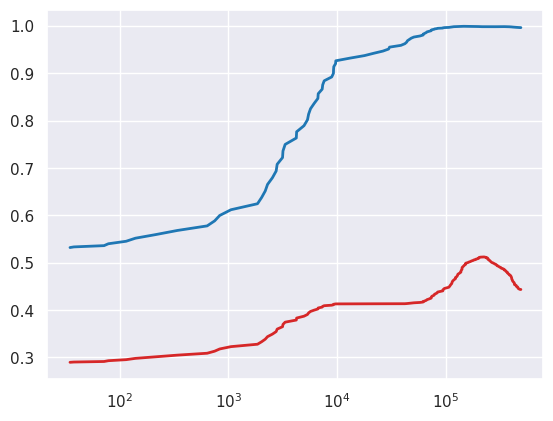

In [95]:
# Fit the model & show the pattern. 

run_to_decompose = interp_sweep.loc[interp_sweep.lr_factor == 6, :]
# Sort
run_to_decompose.sort_values(by="_step", inplace=True)
steps = run_to_decompose._step

# Apply a gaussian filter with sigma=2
from scipy.ndimage import gaussian_filter1d

run_to_decompose["test/acc"] = gaussian_filter1d(run_to_decompose["test/acc"], sigma=15)
run_to_decompose["train/acc"] = gaussian_filter1d(run_to_decompose["train/acc"], sigma=15)

plt.plot(steps, run_to_decompose["test/acc"], label="Test", color=RED, linewidth=2)
plt.plot(steps, run_to_decompose["train/acc"], label="Train", color=BLUE, linewidth=2)

plt.xscale("log")

run_to_decompose_rescaled = rescale_run(run_to_decompose, new_max=100)


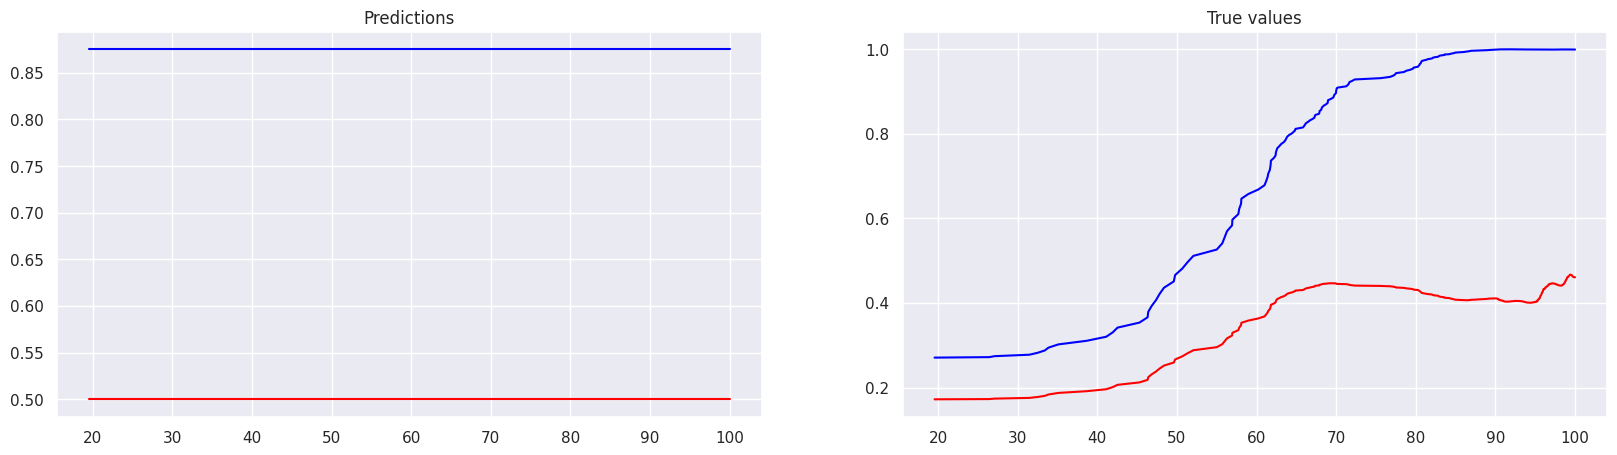

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 - loss: 0.039858635514974594


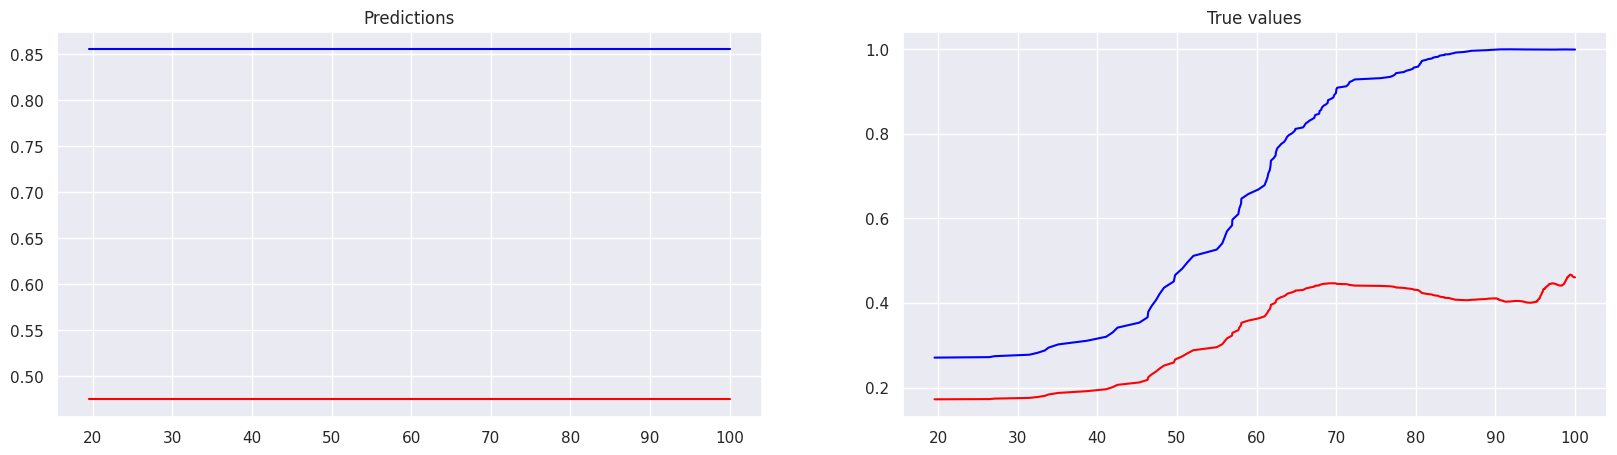

Epoch 1 - loss: 0.03857443481683731
Epoch 2 - loss: 0.03909042477607727
Epoch 3 - loss: 0.039265766739845276
Epoch 4 - loss: 0.03888075053691864
Epoch 5 - loss: 0.03856044262647629
Epoch 6 - loss: 0.038498394191265106
Epoch 7 - loss: 0.03841610625386238
Epoch 8 - loss: 0.03802547603845596
Epoch 9 - loss: 0.037287112325429916
Epoch 10 - loss: 0.03629075735807419
Epoch 11 - loss: 0.035145748406648636
Epoch 12 - loss: 0.033965788781642914
Epoch 13 - loss: 0.03289315104484558
Epoch 14 - loss: 0.032070208340883255
Epoch 15 - loss: 0.03153051808476448
Epoch 16 - loss: 0.03114066831767559
Epoch 17 - loss: 0.030748026445508003
Epoch 18 - loss: 0.030343100428581238
Epoch 19 - loss: 0.030026793479919434
Epoch 20 - loss: 0.02990177646279335
Epoch 21 - loss: 0.02999171055853367
Epoch 22 - loss: 0.03021114133298397
Epoch 23 - loss: 0.030416550114750862
Epoch 24 - loss: 0.03051588498055935
Epoch 25 - loss: 0.03052421286702156


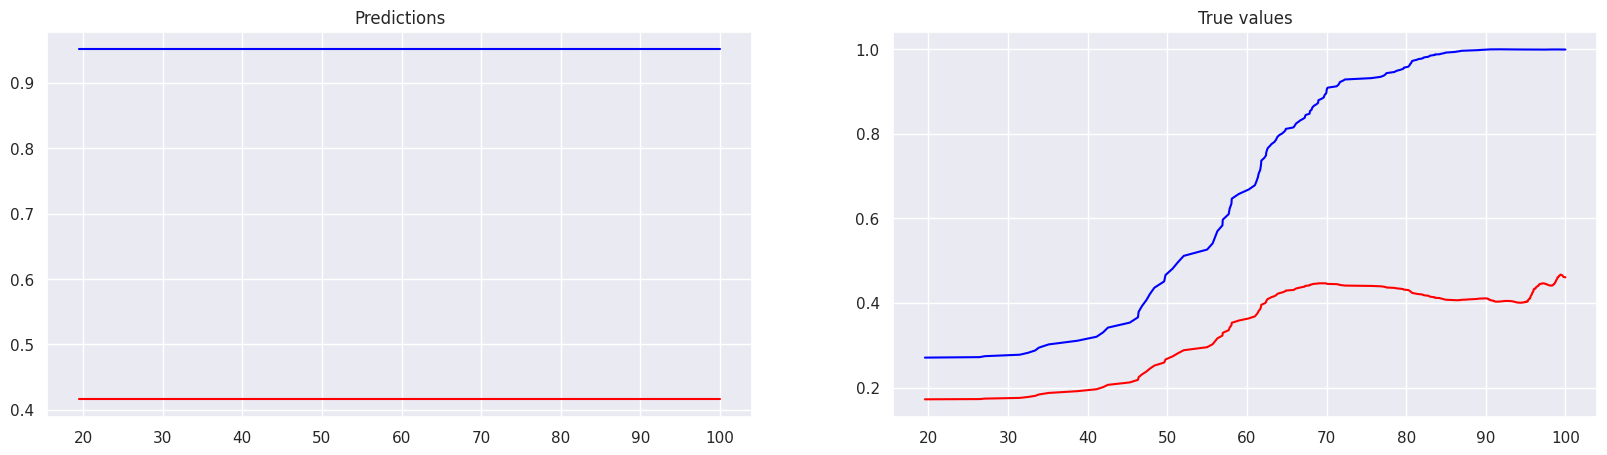

Epoch 26 - loss: 0.03051900491118431
Epoch 27 - loss: 0.030559193342924118
Epoch 28 - loss: 0.030638298019766808
Epoch 29 - loss: 0.030701184645295143
Epoch 30 - loss: 0.03070010244846344
Epoch 31 - loss: 0.03063318505883217
Epoch 32 - loss: 0.030537845566868782
Epoch 33 - loss: 0.030456120148301125
Epoch 34 - loss: 0.030402377247810364
Epoch 35 - loss: 0.030356958508491516
Epoch 36 - loss: 0.030290547758340836
Epoch 37 - loss: 0.030195388942956924
Epoch 38 - loss: 0.030092263594269753
Epoch 39 - loss: 0.03001013584434986
Epoch 40 - loss: 0.029961928725242615
Epoch 41 - loss: 0.0299382321536541
Epoch 42 - loss: 0.029920758679509163
Epoch 43 - loss: 0.029900139197707176
Epoch 44 - loss: 0.029881920665502548
Epoch 45 - loss: 0.02987818792462349
Epoch 46 - loss: 0.029894327744841576
Epoch 47 - loss: 0.029922882094979286
Epoch 48 - loss: 0.029949355870485306
Epoch 49 - loss: 0.029963528737425804
Epoch 50 - loss: 0.029965411871671677


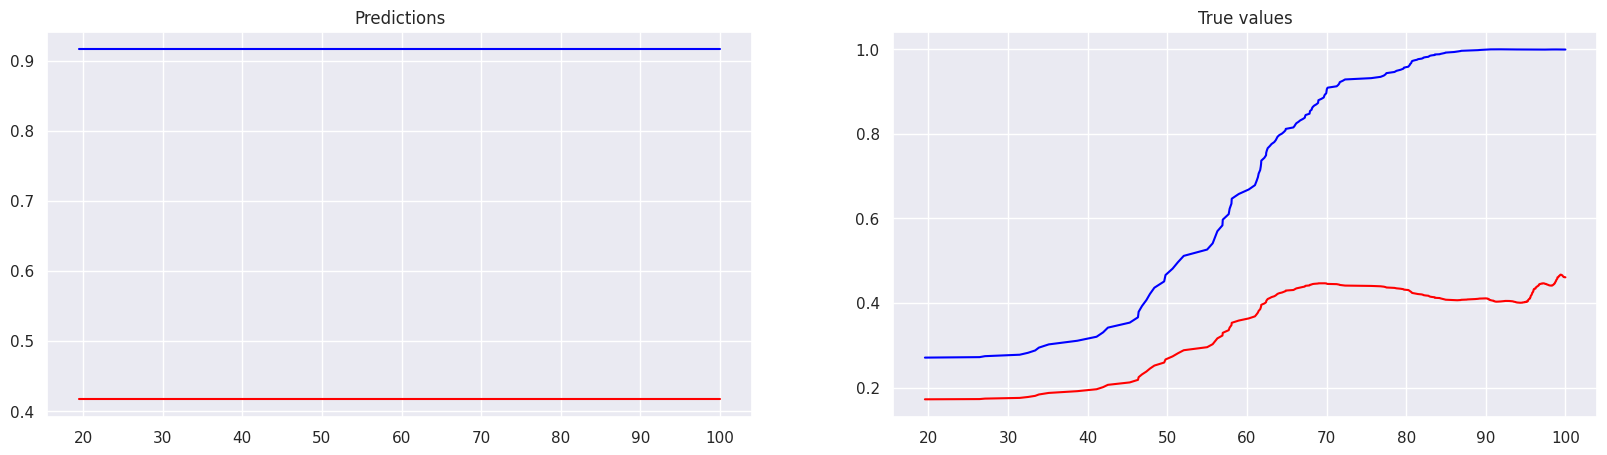

Epoch 51 - loss: 0.029961522668600082
Epoch 52 - loss: 0.029956942424178123
Epoch 53 - loss: 0.02995111234486103
Epoch 54 - loss: 0.029940379783511162
Epoch 55 - loss: 0.029923412948846817
Epoch 56 - loss: 0.029903750866651535
Epoch 57 - loss: 0.029887231066823006
Epoch 58 - loss: 0.029877347871661186
Epoch 59 - loss: 0.029873128980398178
Epoch 60 - loss: 0.02987128123641014
Epoch 61 - loss: 0.02986982837319374
Epoch 62 - loss: 0.029869478195905685
Epoch 63 - loss: 0.029871737584471703
Epoch 64 - loss: 0.029876401647925377
Epoch 65 - loss: 0.02988123893737793
Epoch 66 - loss: 0.029884010553359985
Epoch 67 - loss: 0.029884321615099907
Epoch 68 - loss: 0.02988344617187977
Epoch 69 - loss: 0.029882589355111122
Epoch 70 - loss: 0.02988165244460106
Epoch 71 - loss: 0.029879748821258545
Epoch 72 - loss: 0.02987658977508545
Epoch 73 - loss: 0.02987302839756012
Epoch 74 - loss: 0.029870260506868362
Epoch 75 - loss: 0.02986872009932995


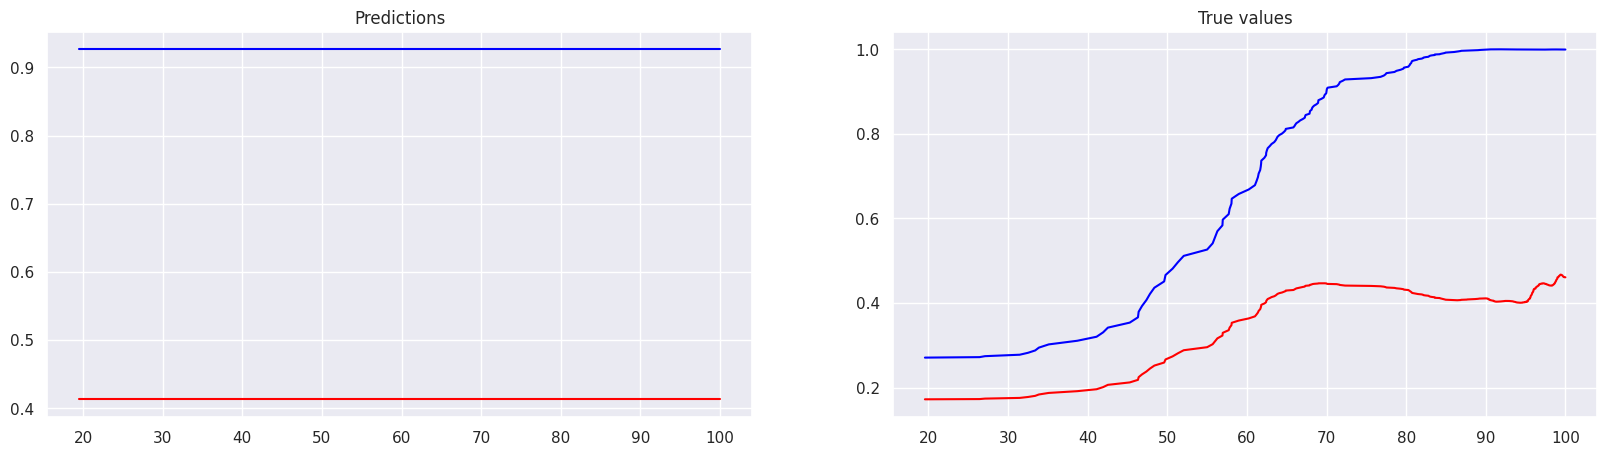

Epoch 76 - loss: 0.029867926612496376
Epoch 77 - loss: 0.02986728399991989
Epoch 78 - loss: 0.029866766184568405
Epoch 79 - loss: 0.029866792261600494
Epoch 80 - loss: 0.029867537319660187
Epoch 81 - loss: 0.0298685971647501
Epoch 82 - loss: 0.02986937388777733
Epoch 83 - loss: 0.02986963465809822
Epoch 84 - loss: 0.029869580641388893
Epoch 85 - loss: 0.029869485646486282
Epoch 86 - loss: 0.02986934222280979
Epoch 87 - loss: 0.02986895479261875
Epoch 88 - loss: 0.029868289828300476
Epoch 89 - loss: 0.029867546632885933
Epoch 90 - loss: 0.029867012053728104
Epoch 91 - loss: 0.029866736382246017
Epoch 92 - loss: 0.029866592958569527
Epoch 93 - loss: 0.029866471886634827
Epoch 94 - loss: 0.02986641228199005
Epoch 95 - loss: 0.029866499826312065
Epoch 96 - loss: 0.02986670844256878
Epoch 97 - loss: 0.029866913333535194
Epoch 98 - loss: 0.029867013916373253
Epoch 99 - loss: 0.029867012053728104


PatternLearningModel({'pattern_0/strength': tensor(0.6620), 'pattern_0/speed': tensor(10.), 'pattern_0/onset': tensor(0.2500), 'pattern_0/generalization': tensor(0.1706), 'pattern_1/strength': tensor(0.6624), 'pattern_1/speed': tensor(10.), 'pattern_1/onset': tensor(0.5000), 'pattern_1/generalization': tensor(0.1702), 'pattern_2/strength': tensor(0.3576), 'pattern_2/speed': tensor(10.), 'pattern_2/onset': tensor(0.7500), 'pattern_2/generalization': tensor(1.5037)})

In [87]:
model = PatternLearningModel()

def callback(x): 
    plot_patterns(x, run_to_decompose_rescaled)
    plt.show()

model.fit(run_to_decompose_rescaled, num_epochs=100, callback=callback, callback_ivl=25)

In [209]:
from scipy.ndimage import gaussian_filter1d

r_uncorrupted = gaussian_filter1d(run["uncorrupted/acc"], 2.)
r_corrupted = gaussian_filter1d(run["corrupted/acc"], 2.)

r_uncorrupted

array([0.10806458, 0.10697712, 0.10467782, ..., 0.99810091, 0.99810116,
       0.9981013 ])

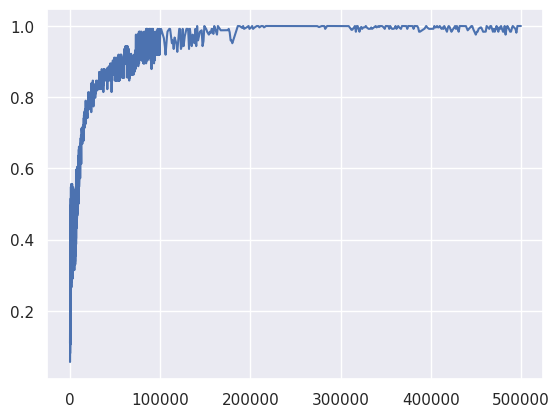

In [210]:
plt.plot(steps, run["corrupted/acc"])

/home/paperspace/Projects/quanta-learning/.venv/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/tmp/ipykernel_4071/1270688411.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "", "$10^0$", "$10^1$", "$10^2$", "$10^3$", "$10^4$", "$10^5$", ])


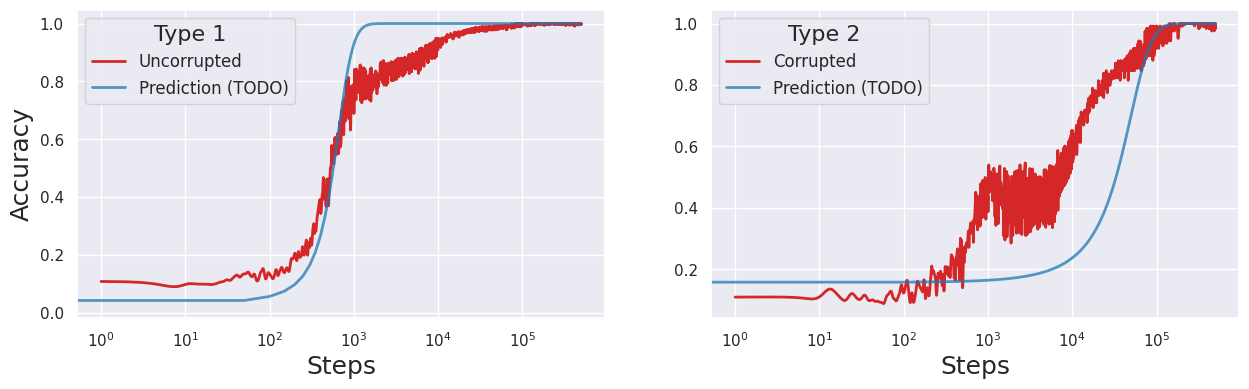

In [218]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

type_1 = [(model.patterns[0](t) / model.patterns[0].strength).detach().float() for t in ts]
type_2 = [(model.patterns[1](t) / model.patterns[1].strength).detach().float() for t in ts]
type_3 = [(model.patterns[2](t) / model.patterns[2].strength).detach().float() for t in ts]

TS = ts * 500_000 / 100

# Plot 1: Uncorrupted data / Type 1 Pattern
ax1.plot(steps, r_uncorrupted, label="Uncorrupted", color=RED, linewidth=2)
ax1.plot(TS, type_1, label="Prediction (TODO)", color=BLUE, linestyle="-", linewidth=2, alpha=0.75)
ax1.legend(title="Type 1", fontsize=12, title_fontsize=16, loc="upper left")

# TODO: Plot pattern 1
# ax1.plot(steps, )

# Plot 2: Corrupted data / Type 2 Pattern
ax2.plot(steps, r_corrupted, label="Corrupted", color=RED, linewidth=2)
ax2.plot(TS, type_2, label="Prediction (TODO)", color=BLUE, linestyle="-", linewidth=2, alpha=0.75)
ax2.legend(title="Type 2", fontsize=12, title_fontsize=16, loc="upper left")


# Plot 3: Type 3 Pattern

# ax3.plot(TS, type_3, label="Prediction (TODO)", color=BLUE, linestyle="--", linewidth=2)
# ax3.legend(title="Type 3", fontsize=12, title_fontsize=16, loc="upper left")

ax1.set_ylabel("Accuracy", fontsize=18)

# for ax in [ax1, ax2, ax3]:
for ax in [ax1, ax2]:
    ax.set_xlabel("Steps", fontsize=18)
    ax.set_xscale("log")
    ax.set_xticklabels(["", "", "$10^0$", "$10^1$", "$10^2$", "$10^3$", "$10^4$", "$10^5$", ])

plt.savefig("../figures/pattern-predictions.pdf", bbox_inches="tight")

13          NaN
32          NaN
35          NaN
62     0.120968
71          NaN
         ...   
314         NaN
3           NaN
21          NaN
211         NaN
116         NaN
Name: corrupted/acc, Length: 432, dtype: float64

In [93]:

def get_history(
    *sweep_ids,
    unique_cols: Union[List[str], str] = "weight_decay",
    entity: str = "jqhoogland",
    project: str = "grokking",
    allow_duplicates=False,
    combine_seeds=False,
):
    """
    Gathers all the runs from a series of sweeps and combines them into a single dataframe.

    `unique_col` is used to identify duplicate runs. By default, `"_step"` is added.
    If there are duplicates, the run from the last sweep is kept.
    """
    api = wandb.Api()
    unique_cols = unique_cols if isinstance(unique_cols, list) else [unique_cols]

    def _get_history(sweep_id):
        """Get a dataframe for a single sweep."""
        sweep = api.sweep(f"{entity}/{project}/{sweep_id}")
        runs = sweep.runs

        def create_run_df(history, config):
            for k, v in config.items():
                if k == "momentum" and isinstance(v, list):
                    v = [tuple(v)] * len(history)
                history[k] = v

            return history

        return pd.concat([create_run_df(run.history(), run.config) for run in runs])

    histories = pd.concat([_get_history(sweep_id) for sweep_id in sweep_ids])

    if not allow_duplicates:
        histories = histories.drop_duplicates(["_step", *unique_cols], keep="last")

    # Change step 0 to 1 to avoid issues with log plots
    histories.loc[histories._step == 0, "_step"] = 1

    # Fix types
    histories.applymap(lambda x: x.item() if isinstance(x, np.generic) else x)
    non_numeric_columns = histories.select_dtypes(
        exclude=["int", "float", "int64", "float64"]
    ).columns
    histories = histories.drop(columns=non_numeric_columns)

    # Sort
    histories = histories.sort_values(by=[*unique_cols, "_step"])

    # Remove any runs that didn't have any steps after 1000
    for unique_col in unique_cols:
        valid_runs = histories.groupby(unique_col).apply(
            lambda x: x["_step"].max() > 1000
        )
        histories = histories[histories[unique_col].isin(valid_runs[valid_runs].index)]


    return histories


INTERP_SWEEPS = ["kodd01ka", "wecya83q", "wqnakkjd"]  # "awxzpem1"
interp_sweep = get_history(*INTERP_SWEEPS, project="mnist-grokking", allow_duplicates=True, combine_seeds=True)
# interp_sweep.drop(["weight/cos_sim_with_init", "test/efficiency", "train/efficiency", "weight/dist_from_init"])
interp_sweep

_step  test/acc  train/acc  weight/cos_sim_with_init    _timestamp   
1         1  0.155689   0.124750                  1.000000  1.684039e+09  \
1         1  0.155689   0.125749                  0.999999  1.684012e+09   
1         1  0.071856   0.057884                       NaN  1.684132e+09   
1         1  0.107784   0.085828                       NaN  1.684106e+09   
1         1  0.119760   0.103792                       NaN  1.684101e+09   
..      ...       ...        ...                       ...           ...   
283  499998  0.401198   1.000000                       NaN  1.684079e+09   
252  499998  0.353293   0.994012                       NaN  1.684188e+09   
42   499998  0.293413   0.994012                       NaN  1.684178e+09   
475  499998  0.341317   0.995010                       NaN  1.684174e+09   
166  499998  0.443114   0.998004                       NaN  1.684154e+09   

     test/efficiency  weight/dist_from_init     test/loss    train/loss   
1         132.051244               0.022019   9714.351796   9843.892607  \
1         113.369359               0.090618   8339.961826   8474.183179   
1                NaN                    NaN  10396.254491  10570.136699   
1                NaN                    NaN   2612.323540   2793.174760   
1                NaN                    NaN   3196.420659   3367.801459   
..               ...                    ...           ...           ...   
283              NaN                    NaN      5.157521      0.000284   
252              NaN                    NaN      0.933705      0.008942   
42               NaN                    NaN      0.999522      0.009808   
475              NaN                    NaN      0.859243      0.007038   
166              NaN                    NaN      0.820470      0.004319   

        _runtime  ...  num_classes  log_interval  weight_decay   
1       1.657578  ...           10            10          0.01  \
1       1.839550  ...           10            10          0.01   
1       1.737261  ...           10            10          0.01   
1       1.775621  ...           10            10          0.01   
1       1.729723  ...           10            10          0.01   
..           ...  ...          ...           ...           ...   
283  4566.878387  ...           10            10          0.01   
252  4959.604672  ...           10            10          0.01   
42   4761.409576  ...           10            10          0.01   
475  4758.374334  ...           10            10          0.01   
166  4704.569134  ...           10            10          0.01   

     frac_label_noise  num_training_steps  test_acc_criterion  corrupted/acc   
1                 0.1              500000                   1            NaN  \
1                 0.1              500000                   1            NaN   
1                 0.1              500000                   1            NaN   
1                 0.1              500000                   1            NaN   
1                 0.1              500000                   1            NaN   
..                ...                 ...                 ...            ...   
283               0.1              500000                   1            NaN   
252               0.1              500000                   1       1.000000   
42                0.1              500000                   1       1.000000   
475               0.1              500000                   1       0.991935   
166               0.1              500000                   1       1.000000   

     corrupted/loss  uncorrupted/acc  uncorrupted/loss  
1               NaN              NaN               NaN  
1               NaN              NaN               NaN  
1               NaN              NaN               NaN  
1               NaN              NaN               NaN  
1               NaN              NaN               NaN  
..              ...              ...               ...  
283             NaN              NaN   

In [97]:
histories = interp_sweep.copy()
unique_cols = ["lr_factor"]

assert (
    len(unique_cols) == 1
), "Can only combine seeds if there is a single unique column"

unique_col = unique_cols[0]
unique_vals = histories[unique_col].unique()

for val in unique_vals:
    runs = histories[histories[unique_col] == val]
    seeds = runs.seed.unique()

    if len(seeds) > 1:
        # Define the metrics that need to be averaged
        metrics = ["train/acc", "test/acc", "train/loss", "test/loss", "corrupted/acc", "uncorrupted/acc"]
        for metric in metrics:
            # Calculate the mean value for each metric and _step
            means_groups = runs.groupby("_step")[metric]

            means = means_groups.apply(
                lambda x: x.ffill().bfill().mean() if x.isna().any() else x.mean()
            )

            if metric == "corrupted/acc":
                print(means)

            # Update the histories dataframe
            for _step, mean_value in means.items():
                mask = (histories[unique_col] == val) & (
                    histories._step == _step
                )
                histories.loc[mask, metric] = mean_value

# Remove duplicate rows
histories = histories.drop_duplicates(subset=[*unique_cols, "_step"])

_step
1         0.107527
2         0.075269
3         0.092742
4         0.048387
5         0.056452
            ...   
496600         NaN
497100         NaN
498000         NaN
499000    1.000000
499998    0.997312
Name: corrupted/acc, Length: 2411, dtype: float64
_step
1         0.123656
2         0.104839
3         0.104839
5         0.129032
6         0.092742
            ...   
494000    0.979839
496000    0.987903
498000    1.000000
499000    0.995161
499998    1.000000
Name: corrupted/acc, Length: 1810, dtype: float64
